In [1]:
!pip install sklearn progressbar2

     |████████████████████████████████| 6.8 MB 3.9 MB/s eta 0:00:01     |██████████████████              | 3.8 MB 802 kB/s eta 0:00:04
     |████████████████████████████████| 300 kB 8.6 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=2397 sha256=85c8c63165b6ee1f81a84b6da4e7089b9afa8d618ccc013d7dde2d644bff0ecb
  Stored in directory: /root/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os
import h5py
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow import keras
import gc
from sys import getsizeof
import datetime
import random
import math
from sklearn.metrics import classification_report, confusion_matrix
import progressbar

In [3]:
GB = 1
gpus = tf.config.experimental.list_physical_devices('GPU')
#The variable GB is the memory size you want to use.
config = [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024*GB))]
if gpus:
  # Restrict TensorFlow to only allocate 1*X GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], config)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
np.set_printoptions(threshold=40*40)


In [4]:
def load_data(res, source_labels, dataset='train', size=1., verbosity = False, shuffle = True):
    data = np.zeros((0, res, res, res), dtype=int)
    labels = np.empty(0, int)
    for i, label in enumerate(source_labels):
        filename = './output/' + label + '/output-' + dataset + '-' + str(res) + '.h5'
        file = h5py.File(filename, 'r')
        tensor_len = len(file['tensor'])
        picked_ids = range(math.ceil(tensor_len * size) - 1)
        if verbosity:
            print(filename)
            print(picked_ids)
            print('Picking ' + str(math.ceil(tensor_len * size)) + ' from ' + str(len(file['tensor'])) )
        data = np.concatenate((data, [file['tensor'][index] for index in picked_ids]))
        labels = np.concatenate((labels, np.full(len(picked_ids), i, dtype=int)))
        file.close()
        gc.collect()
    if shuffle:
        if verbosity:
            print("Shuffling data")
        rng_state = np.random.get_state()
        np.random.shuffle(data)
        np.random.set_state(rng_state)
        np.random.shuffle(labels)
    return (data, labels)



In [ ]:
def prepare_model(res, num_classes, verbosity = 0):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(res, res, res)),
        keras.layers.Dense(res*2, activation='relu'),
        keras.layers.Dense(res/2, activation='sigmoid'),
        keras.layers.Dropout(.2, input_shape=(2,)),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    learning_rate = 0.0001

    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    if (verbosity == 1):
        print(model.summary())
    return model
def prepare_data(data, num_classes):
    return data
model_type = 'dense'
prepare_model(24, 20, 1)

In [5]:
def prepare_model(res, num_classes, verbosity = 0):
    model = keras.Sequential([
        keras.layers.Conv3D(
                res, 
                kernel_size=(6),
                strides=(2),
                activation='relu', 
                kernel_initializer='he_uniform', 
                data_format="channels_last",
                input_shape=(res, res, res, 1)
            ),        
        keras.layers.Conv3D(
                res, 
                kernel_size=(5),
                strides=(2),
                activation='relu', 
                kernel_initializer='he_uniform'
            ),        
        keras.layers.Conv3D(
                res, 
                kernel_size=(2),
                activation='relu', 
                kernel_initializer='he_uniform'
            ),        
   
#        keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(res/2, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    learning_rate = 0.0001

    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    if (verbosity == 1):
        print(model.summary())
    return model
def prepare_data(data, num_classes, res):
    return data.reshape(len(data), res, res, res, 1)
model_type = 'conv3d'
prepare_model(24, 10, 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 10, 10, 10, 24)    5208      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 3, 3, 24)       72024     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 2, 2, 24)       4632      
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                2316      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                130       
Total params: 84,310
Trainable params: 84,310
Non-trainable params: 0
____________________________________________________

In [6]:
def train(model, training, training_labels, res, num_classes, verbosity = 0):
    log_dir = "logs/fit/" + str(res) + '-' + str(num_classes) + '-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    if verbosity == 1:
        print("Log file " + log_dir)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    validation_split = 0.1
    epochs = 10 * num_classes
    
#    model.fit(
#        keras.utils.to_categorical(training, num_clases), 
#        training_labels, 
#        epochs=epochs)
    
    model.fit(
        prepare_data(training, num_classes, res), 
        training_labels, 
        epochs=epochs,
        verbose=verbosity,
        callbacks=[tensorboard_callback],
        validation_split=validation_split
    )

In [7]:
#Confusion Matrix and Classification Report
def print_confusion_matrix(test, test_labels, base_labels):
    Y_pred = model.predict(prepare_data(test, len(base_labels)), len(test))
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(test_labels, y_pred))
    #print('Classification Report')
    #print(classification_report(test_labels, y_pred, target_names=base_labels))

In [8]:
#base_labels = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
all_labels = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone', 
                 'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar','keyboard', 'lamp',
                 'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 
                 'radio', 'range_hood', 'sink', 'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 
                 'vase', 'wardrobe', 'xbox']


In [11]:
subclases = [10, 20, 30, 40]
resolutions = [24]#, 32]#, 48]
num_classes = 2

for i in range(len(all_labels)):
    for j in range(i + 1, len(all_labels)):
        base_labels = [all_labels[i]] + [all_labels[j]]
        print(i, j, base_labels)
        for n, res in enumerate(resolutions):
            training, training_labels = load_data(res, base_labels, 'train', 1, False)
            test, test_labels = load_data(res, base_labels, 'test', 1.0, False)
            model = prepare_model(res, num_classes, 0)
            model_name = 'models/' + model_type + '-' + all_labels[i] + '-' + all_labels[j] + '.h5'
            test_acc = 0
            tries = 0
            while test_acc < 0.9 and tries < 3:
                train(model, training, training_labels, res, num_classes, 1)
                test_loss, test_acc = model.evaluate(
                    prepare_data(test, num_classes, res),  
                    test_labels, 
                    verbose=2
                )
                tries = tries + 1
            model.save(model_name)
            print('\nTest accuracy for ' + all_labels[i] + '-' + all_labels[j] + ' classes width res ' + str(res) + ':', test_acc)
            f = open(model_name + ".txt", "a")
            f.write('Test accuracy for ' + all_labels[i] + '-' + all_labels[j] + ' classes width res ' + str(res) + ':' + str(test_acc))
            f.close()
            #print_confusion_matrix(test, test_labels, all_labels)
            gc.collect()          


0 1 ['airplane', 'bathtub']
Log file logs/fit/24-2-20200721-062848
Epoch 1/20
21/21 [==============================] - 2s 85ms/step - loss: 0.3321 - accuracy: 0.8858 - val_loss: 0.1447 - val_accuracy: 0.9726
Epoch 2/20
21/21 [==============================] - 2s 77ms/step - loss: 0.1002 - accuracy: 0.9787 - val_loss: 0.0661 - val_accuracy: 0.9726
Epoch 3/20
21/21 [==============================] - 2s 81ms/step - loss: 0.0404 - accuracy: 0.9909 - val_loss: 0.0381 - val_accuracy: 0.9863
Epoch 4/20
21/21 [==============================] - 2s 77ms/step - loss: 0.0245 - accuracy: 0.9939 - val_loss: 0.0273 - val_accuracy: 0.9863
Epoch 5/20
21/21 [==============================] - 2s 75ms/step - loss: 0.0180 - accuracy: 0.9954 - val_loss: 0.0219 - val_accuracy: 0.9863
Epoch 6/20
21/21 [==============================] - 2s 75ms/step - loss: 0.0141 - accuracy: 0.9970 - val_loss: 0.0174 - val_accuracy: 1.0000
Epoch 7/20
21/21 [==============================] - 2s 78ms/step - loss: 0.0118 - accur

Epoch 16/20
23/23 [==============================] - 2s 83ms/step - loss: 0.0379 - accuracy: 0.9874 - val_loss: 0.0964 - val_accuracy: 0.9500
Epoch 17/20
23/23 [==============================] - 2s 82ms/step - loss: 0.0367 - accuracy: 0.9874 - val_loss: 0.0972 - val_accuracy: 0.9500
Epoch 18/20
23/23 [==============================] - 2s 83ms/step - loss: 0.0357 - accuracy: 0.9902 - val_loss: 0.1009 - val_accuracy: 0.9500
Epoch 19/20
23/23 [==============================] - 2s 82ms/step - loss: 0.0321 - accuracy: 0.9888 - val_loss: 0.0958 - val_accuracy: 0.9500
Epoch 20/20
23/23 [==============================] - 2s 81ms/step - loss: 0.0308 - accuracy: 0.9902 - val_loss: 0.0945 - val_accuracy: 0.9500
4/4 - 0s - loss: 0.0416 - accuracy: 0.9831

Test accuracy for airplane-bench classes width res 24: 0.9830508232116699
0 4 ['airplane', 'bookshelf']
Log file logs/fit/24-2-20200721-063105
Epoch 1/20
34/34 [==============================] - 3s 88ms/step - loss: 0.3701 - accuracy: 0.8587 - va

Epoch 10/20
20/20 [==============================] - 1s 75ms/step - loss: 0.0290 - accuracy: 0.9919 - val_loss: 0.0342 - val_accuracy: 0.9855
Epoch 11/20
20/20 [==============================] - 2s 76ms/step - loss: 0.0240 - accuracy: 0.9935 - val_loss: 0.0326 - val_accuracy: 0.9855
Epoch 12/20
20/20 [==============================] - 2s 75ms/step - loss: 0.0218 - accuracy: 0.9952 - val_loss: 0.0313 - val_accuracy: 0.9855
Epoch 13/20
20/20 [==============================] - 1s 75ms/step - loss: 0.0206 - accuracy: 0.9968 - val_loss: 0.0303 - val_accuracy: 0.9855
Epoch 14/20
20/20 [==============================] - 2s 81ms/step - loss: 0.0183 - accuracy: 0.9968 - val_loss: 0.0279 - val_accuracy: 0.9855
Epoch 15/20
20/20 [==============================] - 2s 79ms/step - loss: 0.0170 - accuracy: 0.9968 - val_loss: 0.0262 - val_accuracy: 0.9855
Epoch 16/20
20/20 [==============================] - 2s 79ms/step - loss: 0.0157 - accuracy: 0.9968 - val_loss: 0.0258 - val_accuracy: 0.9855
Epoch 

Epoch 4/20
23/23 [==============================] - 2s 101ms/step - loss: 0.0451 - accuracy: 0.9859 - val_loss: 0.0991 - val_accuracy: 0.9625
Epoch 5/20
23/23 [==============================] - 2s 100ms/step - loss: 0.0341 - accuracy: 0.9902 - val_loss: 0.0917 - val_accuracy: 0.9625
Epoch 6/20
23/23 [==============================] - 2s 100ms/step - loss: 0.0285 - accuracy: 0.9902 - val_loss: 0.0866 - val_accuracy: 0.9625
Epoch 7/20
23/23 [==============================] - 2s 102ms/step - loss: 0.0241 - accuracy: 0.9916 - val_loss: 0.0803 - val_accuracy: 0.9625
Epoch 8/20
23/23 [==============================] - 2s 101ms/step - loss: 0.0211 - accuracy: 0.9930 - val_loss: 0.0762 - val_accuracy: 0.9625
Epoch 9/20
23/23 [==============================] - 2s 103ms/step - loss: 0.0187 - accuracy: 0.9930 - val_loss: 0.0707 - val_accuracy: 0.9625
Epoch 10/20
23/23 [==============================] - 2s 101ms/step - loss: 0.0169 - accuracy: 0.9944 - val_loss: 0.0658 - val_accuracy: 0.9625
Epoch

24/24 [==============================] - 2s 100ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 14/20
24/24 [==============================] - 2s 101ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 15/20
24/24 [==============================] - 2s 102ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 16/20
24/24 [==============================] - 2s 101ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 17/20
24/24 [==============================] - 2s 103ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 18/20
24/24 [==============================] - 2s 100ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 19/20
24/24 [==============================] - 2s 102ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 20/20

Epoch 7/20
22/22 [==============================] - 2s 84ms/step - loss: 0.0861 - accuracy: 0.9658 - val_loss: 0.0872 - val_accuracy: 0.9487
Epoch 8/20
22/22 [==============================] - 2s 82ms/step - loss: 0.0780 - accuracy: 0.9757 - val_loss: 0.0783 - val_accuracy: 0.9487
Epoch 9/20
22/22 [==============================] - 2s 82ms/step - loss: 0.0712 - accuracy: 0.9772 - val_loss: 0.0763 - val_accuracy: 0.9487
Epoch 10/20
22/22 [==============================] - 2s 84ms/step - loss: 0.0649 - accuracy: 0.9800 - val_loss: 0.0735 - val_accuracy: 0.9487
Epoch 11/20
22/22 [==============================] - 2s 82ms/step - loss: 0.0598 - accuracy: 0.9829 - val_loss: 0.0739 - val_accuracy: 0.9487
Epoch 12/20
22/22 [==============================] - 2s 83ms/step - loss: 0.0550 - accuracy: 0.9800 - val_loss: 0.0642 - val_accuracy: 0.9615
Epoch 13/20
22/22 [==============================] - 2s 82ms/step - loss: 0.0521 - accuracy: 0.9815 - val_loss: 0.0755 - val_accuracy: 0.9615
Epoch 14/

Epoch 1/20
22/22 [==============================] - 2s 113ms/step - loss: 0.3626 - accuracy: 0.8403 - val_loss: 0.3501 - val_accuracy: 0.8462
Epoch 2/20
22/22 [==============================] - 2s 105ms/step - loss: 0.1970 - accuracy: 0.9165 - val_loss: 0.2680 - val_accuracy: 0.8846
Epoch 3/20
22/22 [==============================] - 2s 103ms/step - loss: 0.1334 - accuracy: 0.9381 - val_loss: 0.1991 - val_accuracy: 0.8846
Epoch 4/20
22/22 [==============================] - 2s 104ms/step - loss: 0.0961 - accuracy: 0.9468 - val_loss: 0.1488 - val_accuracy: 0.9359
Epoch 5/20
22/22 [==============================] - 2s 103ms/step - loss: 0.0742 - accuracy: 0.9640 - val_loss: 0.1179 - val_accuracy: 0.9487
Epoch 6/20
22/22 [==============================] - 2s 105ms/step - loss: 0.0621 - accuracy: 0.9755 - val_loss: 0.0993 - val_accuracy: 0.9744
Epoch 7/20
22/22 [==============================] - 2s 102ms/step - loss: 0.0533 - accuracy: 0.9827 - val_loss: 0.0890 - val_accuracy: 0.9744
Epoch 

Epoch 10/20
25/25 [==============================] - 2s 80ms/step - loss: 0.0288 - accuracy: 0.9896 - val_loss: 0.1198 - val_accuracy: 0.9651
Epoch 11/20
25/25 [==============================] - 2s 81ms/step - loss: 0.0268 - accuracy: 0.9909 - val_loss: 0.1046 - val_accuracy: 0.9651
Epoch 12/20
25/25 [==============================] - 2s 80ms/step - loss: 0.0242 - accuracy: 0.9922 - val_loss: 0.1087 - val_accuracy: 0.9651
Epoch 13/20
25/25 [==============================] - 2s 80ms/step - loss: 0.0223 - accuracy: 0.9935 - val_loss: 0.1126 - val_accuracy: 0.9651
Epoch 14/20
25/25 [==============================] - 2s 82ms/step - loss: 0.0206 - accuracy: 0.9935 - val_loss: 0.1094 - val_accuracy: 0.9651
Epoch 15/20
25/25 [==============================] - 2s 80ms/step - loss: 0.0194 - accuracy: 0.9961 - val_loss: 0.1142 - val_accuracy: 0.9651
Epoch 16/20
25/25 [==============================] - 2s 82ms/step - loss: 0.0185 - accuracy: 0.9961 - val_loss: 0.1076 - val_accuracy: 0.9651
Epoch 

Epoch 4/20
21/21 [==============================] - 2s 76ms/step - loss: 0.0494 - accuracy: 0.9880 - val_loss: 0.0328 - val_accuracy: 1.0000
Epoch 5/20
21/21 [==============================] - 2s 76ms/step - loss: 0.0374 - accuracy: 0.9910 - val_loss: 0.0270 - val_accuracy: 1.0000
Epoch 6/20
21/21 [==============================] - 2s 78ms/step - loss: 0.0308 - accuracy: 0.9910 - val_loss: 0.0235 - val_accuracy: 1.0000
Epoch 7/20
21/21 [==============================] - 2s 76ms/step - loss: 0.0262 - accuracy: 0.9925 - val_loss: 0.0204 - val_accuracy: 1.0000
Epoch 8/20
21/21 [==============================] - 2s 77ms/step - loss: 0.0234 - accuracy: 0.9940 - val_loss: 0.0187 - val_accuracy: 1.0000
Epoch 9/20
21/21 [==============================] - 2s 78ms/step - loss: 0.0205 - accuracy: 0.9955 - val_loss: 0.0171 - val_accuracy: 1.0000
Epoch 10/20
21/21 [==============================] - 2s 83ms/step - loss: 0.0174 - accuracy: 0.9955 - val_loss: 0.0149 - val_accuracy: 1.0000
Epoch 11/20


Epoch 13/20
29/29 [==============================] - 2s 83ms/step - loss: 0.0057 - accuracy: 0.9989 - val_loss: 0.0472 - val_accuracy: 0.9902
Epoch 14/20
29/29 [==============================] - 2s 85ms/step - loss: 0.0051 - accuracy: 0.9989 - val_loss: 0.0472 - val_accuracy: 0.9902
Epoch 15/20
29/29 [==============================] - 2s 82ms/step - loss: 0.0046 - accuracy: 0.9989 - val_loss: 0.0480 - val_accuracy: 0.9902
Epoch 16/20
29/29 [==============================] - 2s 83ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.0482 - val_accuracy: 0.9902
Epoch 17/20
29/29 [==============================] - 2s 82ms/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.0485 - val_accuracy: 0.9902
Epoch 18/20
29/29 [==============================] - 2s 83ms/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.0493 - val_accuracy: 0.9902
Epoch 19/20
29/29 [==============================] - 2s 83ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.0498 - val_accuracy: 0.9902
Epoch 

26/26 [==============================] - 3s 102ms/step - loss: 0.0480 - accuracy: 0.9825 - val_loss: 0.0386 - val_accuracy: 0.9889
Epoch 8/20
26/26 [==============================] - 3s 101ms/step - loss: 0.0433 - accuracy: 0.9813 - val_loss: 0.0348 - val_accuracy: 0.9889
Epoch 9/20
26/26 [==============================] - 3s 100ms/step - loss: 0.0379 - accuracy: 0.9875 - val_loss: 0.0327 - val_accuracy: 1.0000
Epoch 10/20
26/26 [==============================] - 3s 102ms/step - loss: 0.0366 - accuracy: 0.9875 - val_loss: 0.0336 - val_accuracy: 0.9889
Epoch 11/20
26/26 [==============================] - 3s 100ms/step - loss: 0.0321 - accuracy: 0.9925 - val_loss: 0.0263 - val_accuracy: 1.0000
Epoch 12/20
26/26 [==============================] - 3s 102ms/step - loss: 0.0285 - accuracy: 0.9950 - val_loss: 0.0252 - val_accuracy: 0.9889
Epoch 13/20
26/26 [==============================] - 3s 100ms/step - loss: 0.0270 - accuracy: 0.9938 - val_loss: 0.0222 - val_accuracy: 0.9889
Epoch 14/20
2

Epoch 1/20
21/21 [==============================] - 2s 90ms/step - loss: 0.5428 - accuracy: 0.8364 - val_loss: 0.4217 - val_accuracy: 0.8356
Epoch 2/20
21/21 [==============================] - 2s 81ms/step - loss: 0.2812 - accuracy: 0.9220 - val_loss: 0.2152 - val_accuracy: 0.9315
Epoch 3/20
21/21 [==============================] - 2s 79ms/step - loss: 0.1389 - accuracy: 0.9526 - val_loss: 0.1080 - val_accuracy: 0.9589
Epoch 4/20
21/21 [==============================] - 2s 88ms/step - loss: 0.0839 - accuracy: 0.9694 - val_loss: 0.0709 - val_accuracy: 0.9726
Epoch 5/20
21/21 [==============================] - 2s 82ms/step - loss: 0.0679 - accuracy: 0.9725 - val_loss: 0.0516 - val_accuracy: 0.9726
Epoch 6/20
21/21 [==============================] - 2s 80ms/step - loss: 0.0515 - accuracy: 0.9786 - val_loss: 0.0433 - val_accuracy: 0.9726
Epoch 7/20
21/21 [==============================] - 2s 82ms/step - loss: 0.0439 - accuracy: 0.9832 - val_loss: 0.0391 - val_accuracy: 0.9726
Epoch 8/20
21

5/5 [==============================] - 0s 68ms/step - loss: 0.2591 - accuracy: 0.9139 - val_loss: 0.2465 - val_accuracy: 0.8824
Epoch 11/20
5/5 [==============================] - 0s 80ms/step - loss: 0.2327 - accuracy: 0.9338 - val_loss: 0.2267 - val_accuracy: 0.9412
Epoch 12/20
5/5 [==============================] - 0s 79ms/step - loss: 0.2191 - accuracy: 0.9603 - val_loss: 0.2076 - val_accuracy: 0.9412
Epoch 13/20
5/5 [==============================] - 0s 69ms/step - loss: 0.1898 - accuracy: 0.9868 - val_loss: 0.1920 - val_accuracy: 0.9412
Epoch 14/20
5/5 [==============================] - 0s 68ms/step - loss: 0.1670 - accuracy: 1.0000 - val_loss: 0.1789 - val_accuracy: 0.9412
Epoch 15/20
5/5 [==============================] - 0s 74ms/step - loss: 0.1603 - accuracy: 1.0000 - val_loss: 0.1673 - val_accuracy: 0.9412
Epoch 16/20
5/5 [==============================] - 0s 87ms/step - loss: 0.1369 - accuracy: 1.0000 - val_loss: 0.1471 - val_accuracy: 0.9412
Epoch 17/20
5/5 [===============

7/7 [==============================] - 1s 103ms/step - loss: 0.0167 - accuracy: 0.9954 - val_loss: 0.0160 - val_accuracy: 1.0000
3/3 - 0s - loss: 0.0089 - accuracy: 1.0000

Test accuracy for bathtub-curtain classes width res 24: 1.0
1 12 ['bathtub', 'desk']
Log file logs/fit/24-2-20200721-070356
Epoch 1/20
9/9 [==============================] - 1s 86ms/step - loss: 0.6918 - accuracy: 0.4725 - val_loss: 0.5728 - val_accuracy: 0.8065
Epoch 2/20
9/9 [==============================] - 1s 71ms/step - loss: 0.5034 - accuracy: 0.8791 - val_loss: 0.4361 - val_accuracy: 0.9032
Epoch 3/20
9/9 [==============================] - 1s 74ms/step - loss: 0.3559 - accuracy: 0.9377 - val_loss: 0.3167 - val_accuracy: 0.9355
Epoch 4/20
9/9 [==============================] - 1s 77ms/step - loss: 0.2356 - accuracy: 0.9524 - val_loss: 0.2001 - val_accuracy: 0.9677
Epoch 5/20
9/9 [==============================] - 1s 71ms/step - loss: 0.1469 - accuracy: 0.9817 - val_loss: 0.1210 - val_accuracy: 1.0000
Epoch 6/

Epoch 10/20
8/8 [==============================] - 1s 68ms/step - loss: 0.0261 - accuracy: 1.0000 - val_loss: 0.0558 - val_accuracy: 0.9615
Epoch 11/20
8/8 [==============================] - 1s 73ms/step - loss: 0.0159 - accuracy: 1.0000 - val_loss: 0.0539 - val_accuracy: 1.0000
Epoch 12/20
8/8 [==============================] - 1s 78ms/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.0533 - val_accuracy: 1.0000
Epoch 13/20
8/8 [==============================] - 1s 72ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.0517 - val_accuracy: 1.0000
Epoch 14/20
8/8 [==============================] - 1s 73ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.0505 - val_accuracy: 1.0000
Epoch 15/20
8/8 [==============================] - 1s 78ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0493 - val_accuracy: 1.0000
Epoch 16/20
8/8 [==============================] - 1s 67ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0485 - val_accuracy: 1.0000
Epoch 17/20
8/8 [===

Epoch 5/20
8/8 [==============================] - 1s 76ms/step - loss: 0.1693 - accuracy: 0.9912 - val_loss: 0.1759 - val_accuracy: 0.9231
Epoch 6/20
8/8 [==============================] - 1s 71ms/step - loss: 0.1472 - accuracy: 0.9956 - val_loss: 0.1502 - val_accuracy: 0.9231
Epoch 7/20
8/8 [==============================] - 1s 69ms/step - loss: 0.0929 - accuracy: 0.9956 - val_loss: 0.1284 - val_accuracy: 0.9231
Epoch 8/20
8/8 [==============================] - 1s 78ms/step - loss: 0.0814 - accuracy: 1.0000 - val_loss: 0.1173 - val_accuracy: 0.9231
Epoch 9/20
8/8 [==============================] - 1s 67ms/step - loss: 0.0549 - accuracy: 1.0000 - val_loss: 0.1104 - val_accuracy: 0.9231
Epoch 10/20
8/8 [==============================] - 1s 68ms/step - loss: 0.0460 - accuracy: 1.0000 - val_loss: 0.1020 - val_accuracy: 0.9231
Epoch 11/20
8/8 [==============================] - 1s 76ms/step - loss: 0.0360 - accuracy: 1.0000 - val_loss: 0.0965 - val_accuracy: 0.9231
Epoch 12/20
8/8 [========

16/16 [==============================] - 1s 80ms/step - loss: 6.3661e-04 - accuracy: 1.0000 - val_loss: 1.5674e-04 - val_accuracy: 1.0000
5/5 - 0s - loss: 0.0108 - accuracy: 0.9932

Test accuracy for bathtub-monitor classes width res 24: 0.9932432174682617
1 23 ['bathtub', 'night_stand']
Log file logs/fit/24-2-20200721-070708
Epoch 1/20
9/9 [==============================] - 1s 100ms/step - loss: 0.5639 - accuracy: 0.6630 - val_loss: 0.5214 - val_accuracy: 0.6129
Epoch 2/20
9/9 [==============================] - 1s 81ms/step - loss: 0.4076 - accuracy: 0.8022 - val_loss: 0.4555 - val_accuracy: 0.8387
Epoch 3/20
9/9 [==============================] - 1s 73ms/step - loss: 0.3351 - accuracy: 0.8681 - val_loss: 0.4509 - val_accuracy: 0.8387
Epoch 4/20
9/9 [==============================] - 1s 83ms/step - loss: 0.2736 - accuracy: 0.9341 - val_loss: 0.4218 - val_accuracy: 0.8710
Epoch 5/20
9/9 [==============================] - 1s 72ms/step - loss: 0.2157 - accuracy: 0.9707 - val_loss: 0.3981

7/7 [==============================] - 0s 66ms/step - loss: 0.0366 - accuracy: 1.0000 - val_loss: 0.0273 - val_accuracy: 1.0000
Epoch 9/20
7/7 [==============================] - 1s 75ms/step - loss: 0.0258 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 1.0000
Epoch 10/20
7/7 [==============================] - 0s 71ms/step - loss: 0.0192 - accuracy: 1.0000 - val_loss: 0.0156 - val_accuracy: 1.0000
Epoch 11/20
7/7 [==============================] - 0s 65ms/step - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.0122 - val_accuracy: 1.0000
Epoch 12/20
7/7 [==============================] - 1s 76ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.0103 - val_accuracy: 1.0000
Epoch 13/20
7/7 [==============================] - 1s 77ms/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 14/20
7/7 [==============================] - 0s 66ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 15/20
7/7 [================

14/14 [==============================] - 1s 82ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0709 - val_accuracy: 0.9600
Epoch 19/20
14/14 [==============================] - 1s 79ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0698 - val_accuracy: 0.9600
Epoch 20/20
14/14 [==============================] - 1s 86ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0693 - val_accuracy: 0.9600
5/5 - 0s - loss: 0.0183 - accuracy: 0.9932

Test accuracy for bathtub-table classes width res 24: 0.9932432174682617
1 34 ['bathtub', 'tent']
Log file logs/fit/24-2-20200721-071045
Epoch 1/20
8/8 [==============================] - 1s 86ms/step - loss: 0.7871 - accuracy: 0.4083 - val_loss: 0.7134 - val_accuracy: 0.6296
Epoch 2/20
8/8 [==============================] - 1s 71ms/step - loss: 0.6560 - accuracy: 0.6583 - val_loss: 0.6629 - val_accuracy: 0.7778
Epoch 3/20
8/8 [==============================] - 1s 74ms/step - loss: 0.5875 - accuracy: 0.8292 - val_loss: 0.6191 - val_accur

6/6 [==============================] - 0s 81ms/step - loss: 0.1018 - accuracy: 0.9892 - val_loss: 0.1830 - val_accuracy: 0.9524
Epoch 7/20
6/6 [==============================] - 0s 71ms/step - loss: 0.0811 - accuracy: 0.9946 - val_loss: 0.1512 - val_accuracy: 1.0000
Epoch 8/20
6/6 [==============================] - 0s 79ms/step - loss: 0.0639 - accuracy: 0.9946 - val_loss: 0.1356 - val_accuracy: 1.0000
Epoch 9/20
6/6 [==============================] - 1s 83ms/step - loss: 0.0553 - accuracy: 0.9946 - val_loss: 0.1222 - val_accuracy: 1.0000
Epoch 10/20
6/6 [==============================] - 0s 72ms/step - loss: 0.0457 - accuracy: 0.9946 - val_loss: 0.1126 - val_accuracy: 1.0000
Epoch 11/20
6/6 [==============================] - 0s 71ms/step - loss: 0.0393 - accuracy: 0.9946 - val_loss: 0.1005 - val_accuracy: 1.0000
Epoch 12/20
6/6 [==============================] - 0s 82ms/step - loss: 0.0348 - accuracy: 0.9946 - val_loss: 0.0918 - val_accuracy: 1.0000
Epoch 13/20
6/6 [==================

2 5 ['bed', 'bottle']
Log file logs/fit/24-2-20200721-071425
Epoch 1/20
24/24 [==============================] - 3s 113ms/step - loss: 0.3136 - accuracy: 0.8729 - val_loss: 0.1156 - val_accuracy: 0.9765
Epoch 2/20
24/24 [==============================] - 3s 106ms/step - loss: 0.0966 - accuracy: 0.9817 - val_loss: 0.0557 - val_accuracy: 0.9882
Epoch 3/20
24/24 [==============================] - 2s 103ms/step - loss: 0.0567 - accuracy: 0.9895 - val_loss: 0.0381 - val_accuracy: 0.9882
Epoch 4/20
24/24 [==============================] - 2s 104ms/step - loss: 0.0411 - accuracy: 0.9908 - val_loss: 0.0247 - val_accuracy: 1.0000
Epoch 5/20
24/24 [==============================] - 3s 105ms/step - loss: 0.0317 - accuracy: 0.9921 - val_loss: 0.0202 - val_accuracy: 1.0000
Epoch 6/20
24/24 [==============================] - 2s 103ms/step - loss: 0.0253 - accuracy: 0.9921 - val_loss: 0.0163 - val_accuracy: 1.0000
Epoch 7/20
24/24 [==============================] - 3s 106ms/step - loss: 0.0216 - accu

20/20 [==============================] - 2s 86ms/step - loss: 0.0239 - accuracy: 0.9969 - val_loss: 0.0770 - val_accuracy: 0.9577
Epoch 17/20
20/20 [==============================] - 2s 85ms/step - loss: 0.0224 - accuracy: 0.9969 - val_loss: 0.0773 - val_accuracy: 0.9577
Epoch 18/20
20/20 [==============================] - 2s 84ms/step - loss: 0.0210 - accuracy: 0.9969 - val_loss: 0.0754 - val_accuracy: 0.9577
Epoch 19/20
20/20 [==============================] - 2s 86ms/step - loss: 0.0198 - accuracy: 0.9969 - val_loss: 0.0771 - val_accuracy: 0.9577
Epoch 20/20
20/20 [==============================] - 2s 82ms/step - loss: 0.0186 - accuracy: 0.9969 - val_loss: 0.0733 - val_accuracy: 0.9577
7/7 - 0s - loss: 0.0473 - accuracy: 0.9899

Test accuracy for bed-car classes width res 24: 0.9898989796638489
2 8 ['bed', 'chair']
Log file logs/fit/24-2-20200721-071629
Epoch 1/20
40/40 [==============================] - 3s 85ms/step - loss: 0.5389 - accuracy: 0.7486 - val_loss: 0.3278 - val_accurac

18/18 [==============================] - 1s 81ms/step - loss: 0.0816 - accuracy: 0.9875 - val_loss: 0.0763 - val_accuracy: 1.0000
Epoch 5/20
18/18 [==============================] - 2s 87ms/step - loss: 0.0564 - accuracy: 0.9928 - val_loss: 0.0569 - val_accuracy: 1.0000
Epoch 6/20
18/18 [==============================] - 1s 78ms/step - loss: 0.0409 - accuracy: 0.9928 - val_loss: 0.0464 - val_accuracy: 1.0000
Epoch 7/20
18/18 [==============================] - 2s 83ms/step - loss: 0.0323 - accuracy: 0.9946 - val_loss: 0.0351 - val_accuracy: 1.0000
Epoch 8/20
18/18 [==============================] - 1s 83ms/step - loss: 0.0274 - accuracy: 0.9964 - val_loss: 0.0287 - val_accuracy: 1.0000
Epoch 9/20
18/18 [==============================] - 1s 82ms/step - loss: 0.0227 - accuracy: 0.9964 - val_loss: 0.0228 - val_accuracy: 1.0000
Epoch 10/20
18/18 [==============================] - 1s 81ms/step - loss: 0.0196 - accuracy: 0.9964 - val_loss: 0.0180 - val_accuracy: 1.0000
Epoch 11/20
18/18 [====

19/19 [==============================] - 2s 83ms/step - loss: 0.0269 - accuracy: 0.9949 - val_loss: 0.0402 - val_accuracy: 0.9848
Epoch 14/20
19/19 [==============================] - 2s 80ms/step - loss: 0.0248 - accuracy: 0.9949 - val_loss: 0.0399 - val_accuracy: 0.9848
Epoch 15/20
19/19 [==============================] - 2s 86ms/step - loss: 0.0225 - accuracy: 0.9966 - val_loss: 0.0395 - val_accuracy: 0.9848
Epoch 16/20
19/19 [==============================] - 2s 83ms/step - loss: 0.0214 - accuracy: 0.9966 - val_loss: 0.0389 - val_accuracy: 0.9848
Epoch 17/20
19/19 [==============================] - 2s 88ms/step - loss: 0.0205 - accuracy: 0.9966 - val_loss: 0.0391 - val_accuracy: 0.9848
Epoch 18/20
19/19 [==============================] - 2s 82ms/step - loss: 0.0177 - accuracy: 0.9966 - val_loss: 0.0391 - val_accuracy: 0.9848
Epoch 19/20
19/19 [==============================] - 1s 79ms/step - loss: 0.0195 - accuracy: 0.9966 - val_loss: 0.0395 - val_accuracy: 0.9848
Epoch 20/20
19/19 

Epoch 1/20
17/17 [==============================] - 2s 95ms/step - loss: 0.3665 - accuracy: 0.8519 - val_loss: 0.2612 - val_accuracy: 0.8361
Epoch 2/20
17/17 [==============================] - 1s 85ms/step - loss: 0.1549 - accuracy: 0.9370 - val_loss: 0.1778 - val_accuracy: 0.9180
Epoch 3/20
17/17 [==============================] - 1s 79ms/step - loss: 0.0965 - accuracy: 0.9796 - val_loss: 0.1172 - val_accuracy: 0.9672
Epoch 4/20
17/17 [==============================] - 1s 82ms/step - loss: 0.0644 - accuracy: 0.9889 - val_loss: 0.0906 - val_accuracy: 0.9836
Epoch 5/20
17/17 [==============================] - 1s 87ms/step - loss: 0.0472 - accuracy: 0.9907 - val_loss: 0.0726 - val_accuracy: 1.0000
Epoch 6/20
17/17 [==============================] - 1s 82ms/step - loss: 0.0355 - accuracy: 0.9944 - val_loss: 0.0627 - val_accuracy: 0.9836
Epoch 7/20
17/17 [==============================] - 1s 79ms/step - loss: 0.0275 - accuracy: 0.9944 - val_loss: 0.0542 - val_accuracy: 0.9836
Epoch 8/20
17

18/18 [==============================] - 2s 104ms/step - loss: 0.0747 - accuracy: 0.9826 - val_loss: 0.0625 - val_accuracy: 0.9538
Epoch 11/20
18/18 [==============================] - 2s 107ms/step - loss: 0.0656 - accuracy: 0.9861 - val_loss: 0.0524 - val_accuracy: 0.9692
Epoch 12/20
18/18 [==============================] - 2s 103ms/step - loss: 0.0561 - accuracy: 0.9861 - val_loss: 0.0493 - val_accuracy: 0.9692
Epoch 13/20
18/18 [==============================] - 2s 106ms/step - loss: 0.0459 - accuracy: 0.9913 - val_loss: 0.0452 - val_accuracy: 0.9846
Epoch 14/20
18/18 [==============================] - 2s 103ms/step - loss: 0.0401 - accuracy: 0.9913 - val_loss: 0.0400 - val_accuracy: 0.9846
Epoch 15/20
18/18 [==============================] - 2s 103ms/step - loss: 0.0356 - accuracy: 0.9913 - val_loss: 0.0380 - val_accuracy: 0.9846
Epoch 16/20
18/18 [==============================] - 2s 106ms/step - loss: 0.0320 - accuracy: 0.9931 - val_loss: 0.0353 - val_accuracy: 1.0000
Epoch 17/20

19/19 [==============================] - 2s 83ms/step - loss: 0.0379 - accuracy: 0.9885 - val_loss: 0.1452 - val_accuracy: 0.9412
Epoch 20/20
19/19 [==============================] - 2s 84ms/step - loss: 0.0352 - accuracy: 0.9885 - val_loss: 0.1401 - val_accuracy: 0.9412
4/4 - 0s - loss: 0.0561 - accuracy: 0.9831

Test accuracy for bed-tent classes width res 24: 0.9830508232116699
2 35 ['bed', 'toilet']
Log file logs/fit/24-2-20200721-073514
Epoch 1/20
25/25 [==============================] - 2s 86ms/step - loss: 0.6876 - accuracy: 0.4708 - val_loss: 0.5481 - val_accuracy: 0.5930
Epoch 2/20
25/25 [==============================] - 2s 80ms/step - loss: 0.4702 - accuracy: 0.8093 - val_loss: 0.3802 - val_accuracy: 0.9419
Epoch 3/20
25/25 [==============================] - 2s 82ms/step - loss: 0.3145 - accuracy: 0.9390 - val_loss: 0.2162 - val_accuracy: 0.9651
Epoch 4/20
25/25 [==============================] - 2s 80ms/step - loss: 0.1720 - accuracy: 0.9598 - val_loss: 0.1152 - val_accurac

21/21 [==============================] - 2s 82ms/step - loss: 0.0736 - accuracy: 0.9820 - val_loss: 0.0578 - val_accuracy: 0.9867
Epoch 8/20
21/21 [==============================] - 2s 88ms/step - loss: 0.0649 - accuracy: 0.9880 - val_loss: 0.0510 - val_accuracy: 0.9867
Epoch 9/20
21/21 [==============================] - 2s 86ms/step - loss: 0.0564 - accuracy: 0.9880 - val_loss: 0.0461 - val_accuracy: 0.9867
Epoch 10/20
21/21 [==============================] - 2s 83ms/step - loss: 0.0488 - accuracy: 0.9895 - val_loss: 0.0426 - val_accuracy: 0.9867
Epoch 11/20
21/21 [==============================] - 2s 83ms/step - loss: 0.0449 - accuracy: 0.9910 - val_loss: 0.0413 - val_accuracy: 0.9867
Epoch 12/20
21/21 [==============================] - 2s 85ms/step - loss: 0.0389 - accuracy: 0.9910 - val_loss: 0.0387 - val_accuracy: 0.9867
Epoch 13/20
21/21 [==============================] - 2s 83ms/step - loss: 0.0353 - accuracy: 0.9910 - val_loss: 0.0355 - val_accuracy: 0.9867
Epoch 14/20
21/21 [=

7/7 [==============================] - 1s 107ms/step - loss: 0.0612 - accuracy: 0.9763 - val_loss: 0.4890 - val_accuracy: 0.9167
Epoch 3/20
7/7 [==============================] - 1s 94ms/step - loss: 0.0559 - accuracy: 0.9763 - val_loss: 0.4916 - val_accuracy: 0.9167
Epoch 4/20
7/7 [==============================] - 1s 93ms/step - loss: 0.0499 - accuracy: 0.9810 - val_loss: 0.4760 - val_accuracy: 0.9167
Epoch 5/20
7/7 [==============================] - 1s 96ms/step - loss: 0.0504 - accuracy: 0.9810 - val_loss: 0.4797 - val_accuracy: 0.9167
Epoch 6/20
7/7 [==============================] - 1s 93ms/step - loss: 0.0445 - accuracy: 0.9905 - val_loss: 0.4749 - val_accuracy: 0.9167
Epoch 7/20
7/7 [==============================] - 1s 93ms/step - loss: 0.0427 - accuracy: 0.9905 - val_loss: 0.4528 - val_accuracy: 0.9167
Epoch 8/20
7/7 [==============================] - 1s 93ms/step - loss: 0.0421 - accuracy: 0.9905 - val_loss: 0.4676 - val_accuracy: 0.9167
Epoch 9/20
7/7 [=====================

Epoch 19/20
11/11 [==============================] - 1s 78ms/step - loss: 0.0631 - accuracy: 0.9789 - val_loss: 0.0895 - val_accuracy: 0.8649
Epoch 20/20
11/11 [==============================] - 1s 76ms/step - loss: 0.0550 - accuracy: 0.9789 - val_loss: 0.0850 - val_accuracy: 0.8919
4/4 - 0s - loss: 0.1049 - accuracy: 0.9576

Test accuracy for bench-car classes width res 24: 0.9576271176338196
3 8 ['bench', 'chair']
Log file logs/fit/24-2-20200721-074113
Epoch 1/20
30/30 [==============================] - 3s 87ms/step - loss: 0.3751 - accuracy: 0.8208 - val_loss: 0.3035 - val_accuracy: 0.8679
Epoch 2/20
30/30 [==============================] - 3s 85ms/step - loss: 0.2190 - accuracy: 0.9057 - val_loss: 0.2426 - val_accuracy: 0.9151
Epoch 3/20
30/30 [==============================] - 2s 83ms/step - loss: 0.1404 - accuracy: 0.9570 - val_loss: 0.1949 - val_accuracy: 0.9245
Epoch 4/20
30/30 [==============================] - 2s 83ms/step - loss: 0.0943 - accuracy: 0.9696 - val_loss: 0.1730 

Epoch 8/20
8/8 [==============================] - 1s 92ms/step - loss: 0.0765 - accuracy: 0.9881 - val_loss: 0.2227 - val_accuracy: 0.9286
Epoch 9/20
8/8 [==============================] - 1s 76ms/step - loss: 0.0626 - accuracy: 0.9881 - val_loss: 0.2187 - val_accuracy: 0.9286
Epoch 10/20
8/8 [==============================] - 1s 75ms/step - loss: 0.0545 - accuracy: 0.9881 - val_loss: 0.2129 - val_accuracy: 0.9286
Epoch 11/20
8/8 [==============================] - 1s 86ms/step - loss: 0.0462 - accuracy: 0.9921 - val_loss: 0.2016 - val_accuracy: 0.9286
Epoch 12/20
8/8 [==============================] - 1s 74ms/step - loss: 0.0420 - accuracy: 0.9881 - val_loss: 0.1928 - val_accuracy: 0.9286
Epoch 13/20
8/8 [==============================] - 1s 79ms/step - loss: 0.0382 - accuracy: 0.9921 - val_loss: 0.1986 - val_accuracy: 0.9286
Epoch 14/20
8/8 [==============================] - 1s 85ms/step - loss: 0.0346 - accuracy: 0.9960 - val_loss: 0.2075 - val_accuracy: 0.9286
Epoch 15/20
8/8 [=====

9/9 [==============================] - 1s 104ms/step - loss: 0.1073 - accuracy: 0.9542 - val_loss: 0.0652 - val_accuracy: 1.0000
Epoch 18/20
9/9 [==============================] - 1s 100ms/step - loss: 0.1028 - accuracy: 0.9542 - val_loss: 0.0620 - val_accuracy: 1.0000
Epoch 19/20
9/9 [==============================] - 1s 100ms/step - loss: 0.0996 - accuracy: 0.9577 - val_loss: 0.0576 - val_accuracy: 1.0000
Epoch 20/20
9/9 [==============================] - 1s 98ms/step - loss: 0.0966 - accuracy: 0.9577 - val_loss: 0.0532 - val_accuracy: 1.0000
2/2 - 0s - loss: 0.1662 - accuracy: 0.9474

Test accuracy for bench-keyboard classes width res 24: 0.9473684430122375
3 19 ['bench', 'lamp']
Log file logs/fit/24-2-20200721-074529
Epoch 1/20
9/9 [==============================] - 1s 115ms/step - loss: 0.6696 - accuracy: 0.5849 - val_loss: 0.5149 - val_accuracy: 0.8000
Epoch 2/20
9/9 [==============================] - 1s 93ms/step - loss: 0.5392 - accuracy: 0.7094 - val_loss: 0.4155 - val_accurac

Epoch 12/20
13/13 [==============================] - 1s 82ms/step - loss: 0.0530 - accuracy: 0.9902 - val_loss: 0.0785 - val_accuracy: 0.9348
Epoch 13/20
13/13 [==============================] - 1s 81ms/step - loss: 0.0477 - accuracy: 0.9927 - val_loss: 0.0728 - val_accuracy: 0.9348
Epoch 14/20
13/13 [==============================] - 1s 82ms/step - loss: 0.0424 - accuracy: 0.9927 - val_loss: 0.0699 - val_accuracy: 0.9348
Epoch 15/20
13/13 [==============================] - 1s 84ms/step - loss: 0.0379 - accuracy: 0.9927 - val_loss: 0.0644 - val_accuracy: 0.9348
Epoch 16/20
13/13 [==============================] - 1s 75ms/step - loss: 0.0339 - accuracy: 0.9951 - val_loss: 0.0605 - val_accuracy: 0.9348
Epoch 17/20
13/13 [==============================] - 1s 86ms/step - loss: 0.0307 - accuracy: 0.9951 - val_loss: 0.0580 - val_accuracy: 0.9348
Epoch 18/20
13/13 [==============================] - 1s 80ms/step - loss: 0.0272 - accuracy: 0.9951 - val_loss: 0.0563 - val_accuracy: 0.9565
Epoch 

8/8 [==============================] - 1s 72ms/step - loss: 0.1501 - accuracy: 0.9742 - val_loss: 0.1107 - val_accuracy: 1.0000
Epoch 7/20
8/8 [==============================] - 1s 82ms/step - loss: 0.1128 - accuracy: 0.9742 - val_loss: 0.0875 - val_accuracy: 1.0000
Epoch 8/20
8/8 [==============================] - 1s 69ms/step - loss: 0.1102 - accuracy: 0.9785 - val_loss: 0.0715 - val_accuracy: 1.0000
Epoch 9/20
8/8 [==============================] - 1s 76ms/step - loss: 0.0736 - accuracy: 0.9871 - val_loss: 0.0595 - val_accuracy: 1.0000
Epoch 10/20
8/8 [==============================] - 1s 80ms/step - loss: 0.0847 - accuracy: 0.9871 - val_loss: 0.0538 - val_accuracy: 1.0000
Epoch 11/20
8/8 [==============================] - 1s 72ms/step - loss: 0.0550 - accuracy: 0.9871 - val_loss: 0.0509 - val_accuracy: 1.0000
Epoch 12/20
8/8 [==============================] - 1s 85ms/step - loss: 0.0468 - accuracy: 0.9914 - val_loss: 0.0449 - val_accuracy: 1.0000
Epoch 13/20
8/8 [==================

Epoch 2/20
12/12 [==============================] - 1s 75ms/step - loss: 0.0341 - accuracy: 0.9917 - val_loss: 0.1635 - val_accuracy: 0.9024
Epoch 3/20
12/12 [==============================] - 1s 82ms/step - loss: 0.0329 - accuracy: 0.9917 - val_loss: 0.1606 - val_accuracy: 0.9024
Epoch 4/20
12/12 [==============================] - 1s 71ms/step - loss: 0.0353 - accuracy: 0.9917 - val_loss: 0.1623 - val_accuracy: 0.9024
Epoch 5/20
12/12 [==============================] - 1s 82ms/step - loss: 0.0352 - accuracy: 0.9917 - val_loss: 0.1532 - val_accuracy: 0.9024
Epoch 6/20
12/12 [==============================] - 1s 71ms/step - loss: 0.0332 - accuracy: 0.9917 - val_loss: 0.1596 - val_accuracy: 0.9024
Epoch 7/20
12/12 [==============================] - 1s 85ms/step - loss: 0.0326 - accuracy: 0.9917 - val_loss: 0.1561 - val_accuracy: 0.9024
Epoch 8/20
12/12 [==============================] - 1s 71ms/step - loss: 0.0298 - accuracy: 0.9917 - val_loss: 0.1605 - val_accuracy: 0.9024
Epoch 9/20
12

9/9 [==============================] - 1s 89ms/step - loss: 0.0715 - accuracy: 0.9805 - val_loss: 0.0822 - val_accuracy: 0.9655
Epoch 14/20
9/9 [==============================] - 1s 96ms/step - loss: 0.0628 - accuracy: 0.9844 - val_loss: 0.0692 - val_accuracy: 0.9655
Epoch 15/20
9/9 [==============================] - 1s 91ms/step - loss: 0.0572 - accuracy: 0.9844 - val_loss: 0.0631 - val_accuracy: 0.9655
Epoch 16/20
9/9 [==============================] - 1s 90ms/step - loss: 0.0572 - accuracy: 0.9883 - val_loss: 0.0648 - val_accuracy: 0.9655
Epoch 17/20
9/9 [==============================] - 1s 90ms/step - loss: 0.0470 - accuracy: 0.9883 - val_loss: 0.0575 - val_accuracy: 0.9655
Epoch 18/20
9/9 [==============================] - 1s 90ms/step - loss: 0.0419 - accuracy: 0.9883 - val_loss: 0.0587 - val_accuracy: 0.9655
Epoch 19/20
9/9 [==============================] - 1s 94ms/step - loss: 0.0386 - accuracy: 0.9922 - val_loss: 0.0549 - val_accuracy: 0.9655
Epoch 20/20
9/9 [===============

Epoch 8/20
9/9 [==============================] - 1s 81ms/step - loss: 0.1796 - accuracy: 0.9396 - val_loss: 0.1924 - val_accuracy: 0.9667
Epoch 9/20
9/9 [==============================] - 1s 69ms/step - loss: 0.1610 - accuracy: 0.9434 - val_loss: 0.1876 - val_accuracy: 0.9667
Epoch 10/20
9/9 [==============================] - 1s 82ms/step - loss: 0.1387 - accuracy: 0.9623 - val_loss: 0.1852 - val_accuracy: 0.8667
Epoch 11/20
9/9 [==============================] - 1s 72ms/step - loss: 0.1233 - accuracy: 0.9698 - val_loss: 0.1657 - val_accuracy: 0.9333
Epoch 12/20
9/9 [==============================] - 1s 72ms/step - loss: 0.1080 - accuracy: 0.9774 - val_loss: 0.1719 - val_accuracy: 0.9000
Epoch 13/20
9/9 [==============================] - 1s 81ms/step - loss: 0.0966 - accuracy: 0.9774 - val_loss: 0.1714 - val_accuracy: 0.9000
Epoch 14/20
9/9 [==============================] - 1s 70ms/step - loss: 0.0850 - accuracy: 0.9811 - val_loss: 0.1610 - val_accuracy: 0.9000
Epoch 15/20
9/9 [=====

13/13 [==============================] - 1s 98ms/step - loss: 0.1201 - accuracy: 0.9772 - val_loss: 0.1924 - val_accuracy: 0.8636
Epoch 18/20
13/13 [==============================] - 1s 97ms/step - loss: 0.1086 - accuracy: 0.9772 - val_loss: 0.1726 - val_accuracy: 0.8864
Epoch 19/20
13/13 [==============================] - 1s 100ms/step - loss: 0.0983 - accuracy: 0.9797 - val_loss: 0.1695 - val_accuracy: 0.8864
Epoch 20/20
13/13 [==============================] - 1s 97ms/step - loss: 0.0942 - accuracy: 0.9797 - val_loss: 0.1647 - val_accuracy: 0.8864
4/4 - 0s - loss: 0.2523 - accuracy: 0.8898
Log file logs/fit/24-2-20200721-075403
Epoch 1/20
13/13 [==============================] - 1s 101ms/step - loss: 0.0881 - accuracy: 0.9822 - val_loss: 0.1541 - val_accuracy: 0.9091
Epoch 2/20
13/13 [==============================] - 1s 97ms/step - loss: 0.0803 - accuracy: 0.9848 - val_loss: 0.1490 - val_accuracy: 0.9091
Epoch 3/20
13/13 [==============================] - 1s 96ms/step - loss: 0.076

8/8 [==============================] - 1s 79ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.4153 - val_accuracy: 0.9615
Epoch 9/20
8/8 [==============================] - 1s 67ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.4200 - val_accuracy: 0.9615
Epoch 10/20
8/8 [==============================] - 1s 71ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.4452 - val_accuracy: 0.9231
Epoch 11/20
8/8 [==============================] - 1s 84ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.4495 - val_accuracy: 0.9231
Epoch 12/20
8/8 [==============================] - 1s 68ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.4421 - val_accuracy: 0.9615
Epoch 13/20
8/8 [==============================] - 1s 71ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.4565 - val_accuracy: 0.9231
Epoch 14/20
8/8 [==============================] - 1s 78ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.4541 - val_accuracy: 0.9231
Epoch 15/20
8/8 [================

42/42 [==============================] - 4s 87ms/step - loss: 0.0098 - accuracy: 0.9970 - val_loss: 0.0367 - val_accuracy: 0.9795
Epoch 18/20
42/42 [==============================] - 4s 83ms/step - loss: 0.0093 - accuracy: 0.9970 - val_loss: 0.0371 - val_accuracy: 0.9795
Epoch 19/20
42/42 [==============================] - 4s 86ms/step - loss: 0.0090 - accuracy: 0.9977 - val_loss: 0.0372 - val_accuracy: 0.9795
Epoch 20/20
42/42 [==============================] - 3s 82ms/step - loss: 0.0085 - accuracy: 0.9977 - val_loss: 0.0381 - val_accuracy: 0.9795
7/7 - 0s - loss: 0.0611 - accuracy: 0.9848

Test accuracy for bookshelf-chair classes width res 24: 0.9848484992980957
4 9 ['bookshelf', 'cone']
Log file logs/fit/24-2-20200721-080008
Epoch 1/20
21/21 [==============================] - 2s 91ms/step - loss: 0.3974 - accuracy: 0.8175 - val_loss: 0.2099 - val_accuracy: 0.9730
Epoch 2/20
21/21 [==============================] - 2s 84ms/step - loss: 0.1968 - accuracy: 0.9397 - val_loss: 0.0993 -

Epoch 11/20
20/20 [==============================] - 2s 104ms/step - loss: 0.0823 - accuracy: 0.9749 - val_loss: 0.1565 - val_accuracy: 0.9014
Epoch 12/20
20/20 [==============================] - 2s 104ms/step - loss: 0.0736 - accuracy: 0.9780 - val_loss: 0.1623 - val_accuracy: 0.9296
Epoch 13/20
20/20 [==============================] - 2s 105ms/step - loss: 0.0682 - accuracy: 0.9859 - val_loss: 0.1479 - val_accuracy: 0.9155
Epoch 14/20
20/20 [==============================] - 2s 104ms/step - loss: 0.0639 - accuracy: 0.9843 - val_loss: 0.1531 - val_accuracy: 0.9155
Epoch 15/20
20/20 [==============================] - 2s 106ms/step - loss: 0.0572 - accuracy: 0.9859 - val_loss: 0.1539 - val_accuracy: 0.9296
Epoch 16/20
20/20 [==============================] - 2s 103ms/step - loss: 0.0540 - accuracy: 0.9922 - val_loss: 0.1385 - val_accuracy: 0.9296
Epoch 17/20
20/20 [==============================] - 2s 106ms/step - loss: 0.0519 - accuracy: 0.9859 - val_loss: 0.1540 - val_accuracy: 0.9155

Epoch 5/20
22/22 [==============================] - 2s 83ms/step - loss: 0.0263 - accuracy: 0.9942 - val_loss: 0.0883 - val_accuracy: 0.9740
Epoch 6/20
22/22 [==============================] - 2s 81ms/step - loss: 0.0221 - accuracy: 0.9957 - val_loss: 0.0843 - val_accuracy: 0.9870
Epoch 7/20
22/22 [==============================] - 2s 81ms/step - loss: 0.0157 - accuracy: 0.9957 - val_loss: 0.0842 - val_accuracy: 0.9870
Epoch 8/20
22/22 [==============================] - 2s 83ms/step - loss: 0.0123 - accuracy: 0.9971 - val_loss: 0.0896 - val_accuracy: 0.9740
Epoch 9/20
22/22 [==============================] - 2s 80ms/step - loss: 0.0099 - accuracy: 0.9986 - val_loss: 0.0949 - val_accuracy: 0.9740
Epoch 10/20
22/22 [==============================] - 2s 84ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0923 - val_accuracy: 0.9740
Epoch 11/20
22/22 [==============================] - 2s 82ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0971 - val_accuracy: 0.9740
Epoch 12/20

Epoch 20/20
21/21 [==============================] - 2s 81ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.0077 - val_accuracy: 1.0000
7/7 - 0s - loss: 0.0845 - accuracy: 0.9798

Test accuracy for bookshelf-glass_box classes width res 24: 0.9797979593276978
4 17 ['bookshelf', 'guitar']
Log file logs/fit/24-2-20200721-080549
Epoch 1/20
21/21 [==============================] - 2s 88ms/step - loss: 0.4127 - accuracy: 0.8390 - val_loss: 0.2224 - val_accuracy: 0.8767
Epoch 2/20
21/21 [==============================] - 2s 81ms/step - loss: 0.1639 - accuracy: 0.9202 - val_loss: 0.1215 - val_accuracy: 0.9452
Epoch 3/20
21/21 [==============================] - 2s 81ms/step - loss: 0.0894 - accuracy: 0.9693 - val_loss: 0.0893 - val_accuracy: 0.9589
Epoch 4/20
21/21 [==============================] - 2s 79ms/step - loss: 0.0600 - accuracy: 0.9816 - val_loss: 0.0813 - val_accuracy: 0.9589
Epoch 5/20
21/21 [==============================] - 2s 79ms/step - loss: 0.0487 - accuracy: 0.9877 - va

Epoch 14/20
20/20 [==============================] - 2s 79ms/step - loss: 0.0448 - accuracy: 0.9904 - val_loss: 0.0493 - val_accuracy: 0.9714
Epoch 15/20
20/20 [==============================] - 2s 82ms/step - loss: 0.0397 - accuracy: 0.9920 - val_loss: 0.0449 - val_accuracy: 0.9714
Epoch 16/20
20/20 [==============================] - 2s 84ms/step - loss: 0.0353 - accuracy: 0.9920 - val_loss: 0.0407 - val_accuracy: 1.0000
Epoch 17/20
20/20 [==============================] - 2s 82ms/step - loss: 0.0318 - accuracy: 0.9936 - val_loss: 0.0410 - val_accuracy: 0.9857
Epoch 18/20
20/20 [==============================] - 2s 81ms/step - loss: 0.0310 - accuracy: 0.9952 - val_loss: 0.0357 - val_accuracy: 1.0000
Epoch 19/20
20/20 [==============================] - 2s 81ms/step - loss: 0.0279 - accuracy: 0.9952 - val_loss: 0.0322 - val_accuracy: 1.0000
Epoch 20/20
20/20 [==============================] - 2s 88ms/step - loss: 0.0247 - accuracy: 0.9952 - val_loss: 0.0319 - val_accuracy: 0.9857
4/4 - 

Epoch 8/20
30/30 [==============================] - 2s 80ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 9/20
30/30 [==============================] - 2s 81ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 10/20
30/30 [==============================] - 2s 82ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 11/20
30/30 [==============================] - 2s 78ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 12/20
30/30 [==============================] - 2s 80ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 13/20
30/30 [==============================] - 2s 81ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 14/20
30/30 [==============================] - 2s 82ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 15

Epoch 2/20
36/36 [==============================] - 3s 81ms/step - loss: 0.1427 - accuracy: 0.9698 - val_loss: 0.0663 - val_accuracy: 0.9920
Epoch 3/20
36/36 [==============================] - 3s 84ms/step - loss: 0.0364 - accuracy: 0.9956 - val_loss: 0.0228 - val_accuracy: 1.0000
Epoch 4/20
36/36 [==============================] - 3s 80ms/step - loss: 0.0179 - accuracy: 0.9973 - val_loss: 0.0126 - val_accuracy: 1.0000
Epoch 5/20
36/36 [==============================] - 3s 84ms/step - loss: 0.0134 - accuracy: 0.9982 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 6/20
36/36 [==============================] - 3s 81ms/step - loss: 0.0082 - accuracy: 0.9982 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 7/20
36/36 [==============================] - 3s 85ms/step - loss: 0.0061 - accuracy: 0.9982 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 8/20
36/36 [==============================] - 3s 82ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 9/20
36

19/19 [==============================] - 2s 82ms/step - loss: 0.0281 - accuracy: 0.9966 - val_loss: 0.4752 - val_accuracy: 0.9242
Epoch 18/20
19/19 [==============================] - 1s 79ms/step - loss: 0.0265 - accuracy: 0.9949 - val_loss: 0.5216 - val_accuracy: 0.9697
Epoch 19/20
19/19 [==============================] - 2s 80ms/step - loss: 0.0241 - accuracy: 0.9966 - val_loss: 0.5096 - val_accuracy: 0.9242
Epoch 20/20
19/19 [==============================] - 2s 89ms/step - loss: 0.0223 - accuracy: 0.9966 - val_loss: 0.5545 - val_accuracy: 0.9545
4/4 - 0s - loss: 0.1136 - accuracy: 0.9407

Test accuracy for bookshelf-stool classes width res 24: 0.9406779408454895
4 33 ['bookshelf', 'table']
Log file logs/fit/24-2-20200721-081747
Epoch 1/20
28/28 [==============================] - 2s 87ms/step - loss: 0.5472 - accuracy: 0.7040 - val_loss: 0.3804 - val_accuracy: 0.8866
Epoch 2/20
28/28 [==============================] - 2s 76ms/step - loss: 0.2102 - accuracy: 0.9399 - val_loss: 0.1588

Epoch 11/20
26/26 [==============================] - 3s 106ms/step - loss: 0.0161 - accuracy: 0.9964 - val_loss: 0.0136 - val_accuracy: 0.9891
Epoch 12/20
26/26 [==============================] - 3s 104ms/step - loss: 0.0149 - accuracy: 0.9964 - val_loss: 0.0149 - val_accuracy: 0.9891
Epoch 13/20
26/26 [==============================] - 3s 102ms/step - loss: 0.0133 - accuracy: 0.9964 - val_loss: 0.0140 - val_accuracy: 0.9891
Epoch 14/20
26/26 [==============================] - 3s 105ms/step - loss: 0.0122 - accuracy: 0.9964 - val_loss: 0.0130 - val_accuracy: 0.9891
Epoch 15/20
26/26 [==============================] - 3s 104ms/step - loss: 0.0111 - accuracy: 0.9964 - val_loss: 0.0129 - val_accuracy: 0.9891
Epoch 16/20
26/26 [==============================] - 3s 103ms/step - loss: 0.0099 - accuracy: 0.9976 - val_loss: 0.0130 - val_accuracy: 0.9891
Epoch 17/20
26/26 [==============================] - 3s 105ms/step - loss: 0.0090 - accuracy: 0.9976 - val_loss: 0.0120 - val_accuracy: 0.9891

4/4 - 0s - loss: 0.3983 - accuracy: 0.8898

Test accuracy for bookshelf-wardrobe classes width res 24: 0.8898305296897888
4 39 ['bookshelf', 'xbox']
Log file logs/fit/24-2-20200721-082356
Epoch 1/20
19/19 [==============================] - 2s 113ms/step - loss: 0.4391 - accuracy: 0.8413 - val_loss: 0.2326 - val_accuracy: 0.8676
Epoch 2/20
19/19 [==============================] - 2s 104ms/step - loss: 0.2771 - accuracy: 0.8628 - val_loss: 0.1706 - val_accuracy: 0.9265
Epoch 3/20
19/19 [==============================] - 2s 102ms/step - loss: 0.2150 - accuracy: 0.9289 - val_loss: 0.1436 - val_accuracy: 0.9412
Epoch 4/20
19/19 [==============================] - 2s 106ms/step - loss: 0.1756 - accuracy: 0.9471 - val_loss: 0.1314 - val_accuracy: 0.9412
Epoch 5/20
19/19 [==============================] - 2s 104ms/step - loss: 0.1520 - accuracy: 0.9587 - val_loss: 0.1218 - val_accuracy: 0.9412
Epoch 6/20
19/19 [==============================] - 2s 106ms/step - loss: 0.1362 - accuracy: 0.9636 - 

Epoch 15/20
15/15 [==============================] - 1s 83ms/step - loss: 0.0207 - accuracy: 0.9958 - val_loss: 0.0265 - val_accuracy: 0.9811
Epoch 16/20
15/15 [==============================] - 1s 86ms/step - loss: 0.0198 - accuracy: 0.9958 - val_loss: 0.0271 - val_accuracy: 0.9811
Epoch 17/20
15/15 [==============================] - 1s 78ms/step - loss: 0.0190 - accuracy: 0.9958 - val_loss: 0.0271 - val_accuracy: 0.9811
Epoch 18/20
15/15 [==============================] - 1s 83ms/step - loss: 0.0182 - accuracy: 0.9958 - val_loss: 0.0279 - val_accuracy: 0.9811
Epoch 19/20
15/15 [==============================] - 1s 83ms/step - loss: 0.0178 - accuracy: 0.9958 - val_loss: 0.0293 - val_accuracy: 0.9811
Epoch 20/20
15/15 [==============================] - 1s 90ms/step - loss: 0.0169 - accuracy: 0.9958 - val_loss: 0.0287 - val_accuracy: 0.9811
7/7 - 0s - loss: 0.0837 - accuracy: 0.9747

Test accuracy for bottle-car classes width res 24: 0.9747474789619446
5 8 ['bottle', 'chair']
Log file l

13/13 [==============================] - 1s 102ms/step - loss: 0.2530 - accuracy: 0.9194 - val_loss: 0.2969 - val_accuracy: 0.8889
Epoch 4/20
13/13 [==============================] - 1s 97ms/step - loss: 0.1970 - accuracy: 0.9270 - val_loss: 0.2492 - val_accuracy: 0.8889
Epoch 5/20
13/13 [==============================] - 1s 98ms/step - loss: 0.1600 - accuracy: 0.9370 - val_loss: 0.2106 - val_accuracy: 0.9111
Epoch 6/20
13/13 [==============================] - 1s 99ms/step - loss: 0.1407 - accuracy: 0.9421 - val_loss: 0.1866 - val_accuracy: 0.9111
Epoch 7/20
13/13 [==============================] - 1s 101ms/step - loss: 0.1238 - accuracy: 0.9521 - val_loss: 0.1667 - val_accuracy: 0.9333
Epoch 8/20
13/13 [==============================] - 1s 99ms/step - loss: 0.1128 - accuracy: 0.9597 - val_loss: 0.1555 - val_accuracy: 0.9333
Epoch 9/20
13/13 [==============================] - 1s 97ms/step - loss: 0.1006 - accuracy: 0.9673 - val_loss: 0.1473 - val_accuracy: 0.9333
Epoch 10/20
13/13 [===

14/14 [==============================] - 1s 86ms/step - loss: 0.0452 - accuracy: 0.9884 - val_loss: 0.0576 - val_accuracy: 1.0000
Epoch 13/20
14/14 [==============================] - 1s 78ms/step - loss: 0.0453 - accuracy: 0.9884 - val_loss: 0.0533 - val_accuracy: 1.0000
Epoch 14/20
14/14 [==============================] - 1s 85ms/step - loss: 0.0407 - accuracy: 0.9884 - val_loss: 0.0497 - val_accuracy: 1.0000
Epoch 15/20
14/14 [==============================] - 1s 75ms/step - loss: 0.0367 - accuracy: 0.9884 - val_loss: 0.0473 - val_accuracy: 1.0000
Epoch 16/20
14/14 [==============================] - 1s 85ms/step - loss: 0.0360 - accuracy: 0.9884 - val_loss: 0.0447 - val_accuracy: 1.0000
Epoch 17/20
14/14 [==============================] - 1s 83ms/step - loss: 0.0351 - accuracy: 0.9884 - val_loss: 0.0424 - val_accuracy: 1.0000
Epoch 18/20
14/14 [==============================] - 1s 79ms/step - loss: 0.0318 - accuracy: 0.9884 - val_loss: 0.0407 - val_accuracy: 1.0000
Epoch 19/20
14/14 

18/18 [==============================] - 2s 106ms/step - loss: 0.0660 - accuracy: 0.9730 - val_loss: 0.1165 - val_accuracy: 0.9355
Epoch 7/20
18/18 [==============================] - 2s 99ms/step - loss: 0.0558 - accuracy: 0.9784 - val_loss: 0.1092 - val_accuracy: 0.9355
Epoch 8/20
18/18 [==============================] - 2s 107ms/step - loss: 0.0557 - accuracy: 0.9874 - val_loss: 0.1017 - val_accuracy: 0.9194
Epoch 9/20
18/18 [==============================] - 2s 99ms/step - loss: 0.0406 - accuracy: 0.9910 - val_loss: 0.1031 - val_accuracy: 0.9516
Epoch 10/20
18/18 [==============================] - 2s 100ms/step - loss: 0.0344 - accuracy: 0.9910 - val_loss: 0.1045 - val_accuracy: 0.9516
Epoch 11/20
18/18 [==============================] - 2s 103ms/step - loss: 0.0310 - accuracy: 0.9910 - val_loss: 0.0963 - val_accuracy: 0.9516
Epoch 12/20
18/18 [==============================] - 2s 100ms/step - loss: 0.0276 - accuracy: 0.9928 - val_loss: 0.0887 - val_accuracy: 0.9355
Epoch 13/20
18/1


Test accuracy for bottle-night_stand classes width res 24: 0.9728260636329651
5 24 ['bottle', 'person']
Log file logs/fit/24-2-20200721-083436
Epoch 1/20
12/12 [==============================] - 1s 86ms/step - loss: 0.7545 - accuracy: 0.4021 - val_loss: 0.7039 - val_accuracy: 0.6512
Epoch 2/20
12/12 [==============================] - 1s 75ms/step - loss: 0.6204 - accuracy: 0.8016 - val_loss: 0.5800 - val_accuracy: 0.7209
Epoch 3/20
12/12 [==============================] - 1s 77ms/step - loss: 0.4717 - accuracy: 0.7963 - val_loss: 0.4562 - val_accuracy: 0.7209
Epoch 4/20
12/12 [==============================] - 1s 75ms/step - loss: 0.3741 - accuracy: 0.8360 - val_loss: 0.3920 - val_accuracy: 0.7442
Epoch 5/20
12/12 [==============================] - 1s 75ms/step - loss: 0.3120 - accuracy: 0.8704 - val_loss: 0.3535 - val_accuracy: 0.7674
Epoch 6/20
12/12 [==============================] - 1s 75ms/step - loss: 0.2681 - accuracy: 0.8942 - val_loss: 0.3275 - val_accuracy: 0.7674
Epoch 7/20

16/16 [==============================] - 1s 84ms/step - loss: 0.0479 - accuracy: 0.9882 - val_loss: 0.1199 - val_accuracy: 0.9298
Epoch 17/20
16/16 [==============================] - 1s 88ms/step - loss: 0.0446 - accuracy: 0.9901 - val_loss: 0.1082 - val_accuracy: 0.9474
Epoch 18/20
16/16 [==============================] - 1s 81ms/step - loss: 0.0416 - accuracy: 0.9921 - val_loss: 0.1156 - val_accuracy: 0.9298
Epoch 19/20
16/16 [==============================] - 1s 82ms/step - loss: 0.0387 - accuracy: 0.9921 - val_loss: 0.1122 - val_accuracy: 0.9298
Epoch 20/20
16/16 [==============================] - 1s 89ms/step - loss: 0.0364 - accuracy: 0.9921 - val_loss: 0.1079 - val_accuracy: 0.9298
7/7 - 0s - loss: 0.0753 - accuracy: 0.9747

Test accuracy for bottle-piano classes width res 24: 0.9747474789619446
5 26 ['bottle', 'plant']
Log file logs/fit/24-2-20200721-083553
Epoch 1/20
17/17 [==============================] - 2s 89ms/step - loss: 0.6264 - accuracy: 0.6738 - val_loss: 0.5593 - va

13/13 [==============================] - 1s 99ms/step - loss: 0.0491 - accuracy: 0.9901 - val_loss: 0.2039 - val_accuracy: 0.8889
Epoch 11/20
13/13 [==============================] - 1s 100ms/step - loss: 0.0429 - accuracy: 0.9901 - val_loss: 0.2014 - val_accuracy: 0.8889
Epoch 12/20
13/13 [==============================] - 1s 102ms/step - loss: 0.0371 - accuracy: 0.9926 - val_loss: 0.2110 - val_accuracy: 0.8889
Epoch 13/20
13/13 [==============================] - 1s 99ms/step - loss: 0.0331 - accuracy: 0.9975 - val_loss: 0.2211 - val_accuracy: 0.8889
Epoch 14/20
13/13 [==============================] - 1s 100ms/step - loss: 0.0298 - accuracy: 0.9975 - val_loss: 0.2262 - val_accuracy: 0.8889
Epoch 15/20
13/13 [==============================] - 1s 103ms/step - loss: 0.0271 - accuracy: 0.9975 - val_loss: 0.2366 - val_accuracy: 0.8889
Epoch 16/20
13/13 [==============================] - 1s 100ms/step - loss: 0.0253 - accuracy: 0.9975 - val_loss: 0.2338 - val_accuracy: 0.8889
Epoch 17/20
1

13/13 [==============================] - 1s 77ms/step - loss: 0.2006 - accuracy: 0.9538 - val_loss: 0.2216 - val_accuracy: 0.8913
Epoch 5/20
13/13 [==============================] - 1s 93ms/step - loss: 0.1550 - accuracy: 0.9684 - val_loss: 0.1937 - val_accuracy: 0.8913
Epoch 6/20
13/13 [==============================] - 1s 81ms/step - loss: 0.1251 - accuracy: 0.9732 - val_loss: 0.1739 - val_accuracy: 0.9348
Epoch 7/20
13/13 [==============================] - 1s 83ms/step - loss: 0.1036 - accuracy: 0.9805 - val_loss: 0.1541 - val_accuracy: 0.8913
Epoch 8/20
13/13 [==============================] - 1s 78ms/step - loss: 0.0847 - accuracy: 0.9805 - val_loss: 0.1444 - val_accuracy: 0.9130
Epoch 9/20
13/13 [==============================] - 1s 86ms/step - loss: 0.0739 - accuracy: 0.9830 - val_loss: 0.1368 - val_accuracy: 0.9130
Epoch 10/20
13/13 [==============================] - 1s 80ms/step - loss: 0.0649 - accuracy: 0.9854 - val_loss: 0.1272 - val_accuracy: 0.9130
Epoch 11/20
13/13 [====

Epoch 13/20
17/17 [==============================] - 2s 103ms/step - loss: 0.0352 - accuracy: 0.9944 - val_loss: 0.0897 - val_accuracy: 0.9833
Epoch 14/20
17/17 [==============================] - 2s 102ms/step - loss: 0.0325 - accuracy: 0.9963 - val_loss: 0.0878 - val_accuracy: 0.9833
Epoch 15/20
17/17 [==============================] - 2s 105ms/step - loss: 0.0304 - accuracy: 0.9963 - val_loss: 0.0780 - val_accuracy: 0.9833
Epoch 16/20
17/17 [==============================] - 2s 103ms/step - loss: 0.0281 - accuracy: 0.9963 - val_loss: 0.0763 - val_accuracy: 0.9833
Epoch 17/20
17/17 [==============================] - 2s 106ms/step - loss: 0.0270 - accuracy: 0.9963 - val_loss: 0.0737 - val_accuracy: 0.9833
Epoch 18/20
17/17 [==============================] - 2s 104ms/step - loss: 0.0249 - accuracy: 0.9963 - val_loss: 0.0691 - val_accuracy: 0.9833
Epoch 19/20
17/17 [==============================] - 2s 106ms/step - loss: 0.0236 - accuracy: 0.9963 - val_loss: 0.0674 - val_accuracy: 0.9833

Epoch 3/20
13/13 [==============================] - 1s 73ms/step - loss: 0.2926 - accuracy: 0.8597 - val_loss: 0.3355 - val_accuracy: 0.8864
Epoch 4/20
13/13 [==============================] - 1s 83ms/step - loss: 0.2528 - accuracy: 0.8903 - val_loss: 0.2929 - val_accuracy: 0.9091
Epoch 5/20
13/13 [==============================] - 1s 75ms/step - loss: 0.2158 - accuracy: 0.9082 - val_loss: 0.2551 - val_accuracy: 0.9545
Epoch 6/20
13/13 [==============================] - 1s 82ms/step - loss: 0.1900 - accuracy: 0.9388 - val_loss: 0.2332 - val_accuracy: 0.9545
Epoch 7/20
13/13 [==============================] - 1s 74ms/step - loss: 0.1761 - accuracy: 0.9362 - val_loss: 0.2253 - val_accuracy: 0.9545
Epoch 8/20
13/13 [==============================] - 1s 81ms/step - loss: 0.1438 - accuracy: 0.9617 - val_loss: 0.1986 - val_accuracy: 0.9545
Epoch 9/20
13/13 [==============================] - 1s 76ms/step - loss: 0.1315 - accuracy: 0.9643 - val_loss: 0.1861 - val_accuracy: 0.9545
Epoch 10/20
1

4/4 [==============================] - 0s 69ms/step - loss: 0.1287 - accuracy: 0.9603 - val_loss: 0.5634 - val_accuracy: 0.7333
Epoch 14/20
4/4 [==============================] - 0s 72ms/step - loss: 0.1186 - accuracy: 0.9603 - val_loss: 0.5735 - val_accuracy: 0.7333
Epoch 15/20
4/4 [==============================] - 0s 70ms/step - loss: 0.1104 - accuracy: 0.9603 - val_loss: 0.5847 - val_accuracy: 0.7333
Epoch 16/20
4/4 [==============================] - 0s 69ms/step - loss: 0.1051 - accuracy: 0.9603 - val_loss: 0.5962 - val_accuracy: 0.7333
Epoch 17/20
4/4 [==============================] - 0s 80ms/step - loss: 0.0966 - accuracy: 0.9603 - val_loss: 0.5944 - val_accuracy: 0.7333
Epoch 18/20
4/4 [==============================] - 0s 69ms/step - loss: 0.0920 - accuracy: 0.9683 - val_loss: 0.5953 - val_accuracy: 0.7333
Epoch 19/20
4/4 [==============================] - 0s 70ms/step - loss: 0.0869 - accuracy: 0.9683 - val_loss: 0.6018 - val_accuracy: 0.7333
Epoch 20/20
4/4 [===============

8/8 [==============================] - 1s 78ms/step - loss: 0.2097 - accuracy: 0.9489 - val_loss: 0.2546 - val_accuracy: 0.8889
Epoch 6/20
8/8 [==============================] - 1s 73ms/step - loss: 0.1598 - accuracy: 0.9574 - val_loss: 0.2090 - val_accuracy: 0.9259
Epoch 7/20
8/8 [==============================] - 1s 77ms/step - loss: 0.1283 - accuracy: 0.9745 - val_loss: 0.1783 - val_accuracy: 0.9259
Epoch 8/20
8/8 [==============================] - 1s 78ms/step - loss: 0.1067 - accuracy: 0.9745 - val_loss: 0.1558 - val_accuracy: 0.9630
Epoch 9/20
8/8 [==============================] - 1s 69ms/step - loss: 0.1145 - accuracy: 0.9830 - val_loss: 0.1383 - val_accuracy: 0.9630
Epoch 10/20
8/8 [==============================] - 1s 78ms/step - loss: 0.0801 - accuracy: 0.9872 - val_loss: 0.1266 - val_accuracy: 0.9630
Epoch 11/20
8/8 [==============================] - 1s 76ms/step - loss: 0.0637 - accuracy: 0.9872 - val_loss: 0.1126 - val_accuracy: 0.9630
Epoch 12/20
8/8 [===================

Log file logs/fit/24-2-20200721-084928
Epoch 1/20
8/8 [==============================] - 1s 87ms/step - loss: 0.6635 - accuracy: 0.6213 - val_loss: 0.5951 - val_accuracy: 0.7407
Epoch 2/20
8/8 [==============================] - 1s 79ms/step - loss: 0.4865 - accuracy: 0.8043 - val_loss: 0.4488 - val_accuracy: 0.7407
Epoch 3/20
8/8 [==============================] - 1s 74ms/step - loss: 0.3169 - accuracy: 0.8766 - val_loss: 0.3259 - val_accuracy: 0.7778
Epoch 4/20
8/8 [==============================] - 1s 68ms/step - loss: 0.2126 - accuracy: 0.9277 - val_loss: 0.2383 - val_accuracy: 0.8889
Epoch 5/20
8/8 [==============================] - 1s 78ms/step - loss: 0.1471 - accuracy: 0.9574 - val_loss: 0.1901 - val_accuracy: 0.9630
Epoch 6/20
8/8 [==============================] - 1s 74ms/step - loss: 0.1142 - accuracy: 0.9660 - val_loss: 0.1563 - val_accuracy: 0.9630
Epoch 7/20
8/8 [==============================] - 1s 68ms/step - loss: 0.0855 - accuracy: 0.9745 - val_loss: 0.1379 - val_accur

7/7 [==============================] - 1s 87ms/step - loss: 0.1861 - accuracy: 0.9692 - val_loss: 0.2259 - val_accuracy: 0.9545
Epoch 13/20
7/7 [==============================] - 1s 87ms/step - loss: 0.1656 - accuracy: 0.9692 - val_loss: 0.2089 - val_accuracy: 0.9545
Epoch 14/20
7/7 [==============================] - 1s 87ms/step - loss: 0.1380 - accuracy: 0.9692 - val_loss: 0.1930 - val_accuracy: 0.9545
Epoch 15/20
7/7 [==============================] - 1s 87ms/step - loss: 0.1203 - accuracy: 0.9692 - val_loss: 0.1810 - val_accuracy: 0.9545
Epoch 16/20
7/7 [==============================] - 1s 86ms/step - loss: 0.1152 - accuracy: 0.9744 - val_loss: 0.1713 - val_accuracy: 0.9545
Epoch 17/20
7/7 [==============================] - 1s 88ms/step - loss: 0.0962 - accuracy: 0.9744 - val_loss: 0.1634 - val_accuracy: 0.9545
Epoch 18/20
7/7 [==============================] - 1s 92ms/step - loss: 0.0885 - accuracy: 0.9744 - val_loss: 0.1577 - val_accuracy: 0.9545
Epoch 19/20
7/7 [===============

6/6 [==============================] - 0s 62ms/step - loss: 0.0153 - accuracy: 0.9940 - val_loss: 0.0866 - val_accuracy: 0.9474
Epoch 5/20
6/6 [==============================] - 0s 63ms/step - loss: 0.0142 - accuracy: 0.9940 - val_loss: 0.0856 - val_accuracy: 0.9474
Epoch 6/20
6/6 [==============================] - 0s 64ms/step - loss: 0.0145 - accuracy: 0.9940 - val_loss: 0.0849 - val_accuracy: 0.9474
Epoch 7/20
6/6 [==============================] - 0s 63ms/step - loss: 0.0243 - accuracy: 0.9940 - val_loss: 0.0859 - val_accuracy: 0.9474
Epoch 8/20
6/6 [==============================] - 0s 64ms/step - loss: 0.0131 - accuracy: 0.9940 - val_loss: 0.0928 - val_accuracy: 0.9474
Epoch 9/20
6/6 [==============================] - 0s 63ms/step - loss: 0.0306 - accuracy: 0.9940 - val_loss: 0.0931 - val_accuracy: 0.9474
Epoch 10/20
6/6 [==============================] - 0s 64ms/step - loss: 0.0135 - accuracy: 0.9940 - val_loss: 0.0822 - val_accuracy: 0.9474
Epoch 11/20
6/6 [====================

2/2 - 0s - loss: 0.1810 - accuracy: 0.8421
Log file logs/fit/24-2-20200721-085249
Epoch 1/20
6/6 [==============================] - 0s 74ms/step - loss: 0.0282 - accuracy: 0.9947 - val_loss: 0.0648 - val_accuracy: 0.9545
Epoch 2/20
6/6 [==============================] - 0s 76ms/step - loss: 0.0275 - accuracy: 0.9947 - val_loss: 0.0652 - val_accuracy: 0.9545
Epoch 3/20
6/6 [==============================] - 1s 84ms/step - loss: 0.0268 - accuracy: 0.9947 - val_loss: 0.0634 - val_accuracy: 0.9545
Epoch 4/20
6/6 [==============================] - 0s 78ms/step - loss: 0.0261 - accuracy: 0.9947 - val_loss: 0.0615 - val_accuracy: 0.9545
Epoch 5/20
6/6 [==============================] - 0s 73ms/step - loss: 0.0261 - accuracy: 0.9947 - val_loss: 0.0627 - val_accuracy: 0.9545
Epoch 6/20
6/6 [==============================] - 0s 81ms/step - loss: 0.0251 - accuracy: 0.9947 - val_loss: 0.0600 - val_accuracy: 0.9545
Epoch 7/20
6/6 [==============================] - 1s 84ms/step - loss: 0.0248 - accu

9/9 [==============================] - 1s 101ms/step - loss: 0.1330 - accuracy: 0.9620 - val_loss: 0.2482 - val_accuracy: 0.9333
Epoch 12/20
9/9 [==============================] - 1s 92ms/step - loss: 0.1140 - accuracy: 0.9620 - val_loss: 0.2371 - val_accuracy: 0.9333
Epoch 13/20
9/9 [==============================] - 1s 92ms/step - loss: 0.1079 - accuracy: 0.9658 - val_loss: 0.2408 - val_accuracy: 0.9333
Epoch 14/20
9/9 [==============================] - 1s 91ms/step - loss: 0.1003 - accuracy: 0.9696 - val_loss: 0.2345 - val_accuracy: 0.9333
Epoch 15/20
9/9 [==============================] - 1s 97ms/step - loss: 0.0793 - accuracy: 0.9772 - val_loss: 0.2270 - val_accuracy: 0.9333
Epoch 16/20
9/9 [==============================] - 1s 93ms/step - loss: 0.0775 - accuracy: 0.9772 - val_loss: 0.2150 - val_accuracy: 0.9333
Epoch 17/20
9/9 [==============================] - 1s 93ms/step - loss: 0.0649 - accuracy: 0.9810 - val_loss: 0.2030 - val_accuracy: 0.9333
Epoch 18/20
9/9 [==============

6/6 [==============================] - 1s 92ms/step - loss: 0.7575 - accuracy: 0.4737 - val_loss: 0.6570 - val_accuracy: 0.7895
Epoch 2/20
6/6 [==============================] - 0s 76ms/step - loss: 0.6081 - accuracy: 0.7135 - val_loss: 0.5531 - val_accuracy: 0.8947
Epoch 3/20
6/6 [==============================] - 0s 69ms/step - loss: 0.5419 - accuracy: 0.7953 - val_loss: 0.4785 - val_accuracy: 0.8947
Epoch 4/20
6/6 [==============================] - 0s 65ms/step - loss: 0.4753 - accuracy: 0.8421 - val_loss: 0.4256 - val_accuracy: 0.8947
Epoch 5/20
6/6 [==============================] - 0s 75ms/step - loss: 0.4215 - accuracy: 0.8538 - val_loss: 0.3862 - val_accuracy: 0.8947
Epoch 6/20
6/6 [==============================] - 0s 76ms/step - loss: 0.3696 - accuracy: 0.8713 - val_loss: 0.3520 - val_accuracy: 0.8947
Epoch 7/20
6/6 [==============================] - 0s 69ms/step - loss: 0.3479 - accuracy: 0.8713 - val_loss: 0.3257 - val_accuracy: 0.8947
Epoch 8/20
6/6 [======================

6/6 [==============================] - 1s 85ms/step - loss: 0.0308 - accuracy: 0.9880 - val_loss: 0.1263 - val_accuracy: 0.9474
Epoch 14/20
6/6 [==============================] - 1s 88ms/step - loss: 0.0306 - accuracy: 0.9880 - val_loss: 0.1230 - val_accuracy: 0.9474
Epoch 15/20
6/6 [==============================] - 1s 84ms/step - loss: 0.0286 - accuracy: 0.9880 - val_loss: 0.1166 - val_accuracy: 0.9474
Epoch 16/20
6/6 [==============================] - 1s 90ms/step - loss: 0.0278 - accuracy: 0.9880 - val_loss: 0.1126 - val_accuracy: 0.9474
Epoch 17/20
6/6 [==============================] - 1s 86ms/step - loss: 0.0343 - accuracy: 0.9880 - val_loss: 0.1131 - val_accuracy: 0.9474
Epoch 18/20
6/6 [==============================] - 1s 86ms/step - loss: 0.0262 - accuracy: 0.9880 - val_loss: 0.1150 - val_accuracy: 0.9474
Epoch 19/20
6/6 [==============================] - 1s 86ms/step - loss: 0.0263 - accuracy: 0.9940 - val_loss: 0.1114 - val_accuracy: 0.9474
Epoch 20/20
6/6 [===============

Epoch 9/20
13/13 [==============================] - 1s 75ms/step - loss: 0.0351 - accuracy: 0.9902 - val_loss: 0.0939 - val_accuracy: 0.9565
Epoch 10/20
13/13 [==============================] - 1s 76ms/step - loss: 0.0307 - accuracy: 0.9902 - val_loss: 0.0890 - val_accuracy: 0.9565
Epoch 11/20
13/13 [==============================] - 1s 78ms/step - loss: 0.0290 - accuracy: 0.9902 - val_loss: 0.0924 - val_accuracy: 0.9565
Epoch 12/20
13/13 [==============================] - 1s 75ms/step - loss: 0.0225 - accuracy: 0.9951 - val_loss: 0.0928 - val_accuracy: 0.9565
Epoch 13/20
13/13 [==============================] - 1s 75ms/step - loss: 0.0199 - accuracy: 0.9951 - val_loss: 0.0953 - val_accuracy: 0.9565
Epoch 14/20
13/13 [==============================] - 1s 75ms/step - loss: 0.0172 - accuracy: 0.9951 - val_loss: 0.0988 - val_accuracy: 0.9565
Epoch 15/20
13/13 [==============================] - 1s 76ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.1001 - val_accuracy: 0.9565
Epoch 1

10/10 [==============================] - 1s 73ms/step - loss: 0.0339 - accuracy: 0.9831 - val_loss: 0.0656 - val_accuracy: 0.9697
4/4 - 0s - loss: 0.1440 - accuracy: 0.9322

Test accuracy for bowl-tv_stand classes width res 24: 0.9322034120559692
6 37 ['bowl', 'vase']
Log file logs/fit/24-2-20200721-085956
Epoch 1/20
16/16 [==============================] - 1s 88ms/step - loss: 0.8671 - accuracy: 0.4286 - val_loss: 0.4481 - val_accuracy: 0.8889
Epoch 2/20
16/16 [==============================] - 1s 80ms/step - loss: 0.3656 - accuracy: 0.8820 - val_loss: 0.3268 - val_accuracy: 0.8889
Epoch 3/20
16/16 [==============================] - 1s 84ms/step - loss: 0.2535 - accuracy: 0.8986 - val_loss: 0.2140 - val_accuracy: 0.9259
Epoch 4/20
16/16 [==============================] - 1s 84ms/step - loss: 0.2080 - accuracy: 0.9193 - val_loss: 0.1476 - val_accuracy: 0.9815
Epoch 5/20
16/16 [==============================] - 1s 74ms/step - loss: 0.1880 - accuracy: 0.9379 - val_loss: 0.1168 - val_accu

5/5 [==============================] - 0s 68ms/step - loss: 0.0337 - accuracy: 0.9932 - val_loss: 0.1465 - val_accuracy: 0.9412
Epoch 12/20
5/5 [==============================] - 0s 66ms/step - loss: 0.0293 - accuracy: 0.9932 - val_loss: 0.1465 - val_accuracy: 0.9412
Epoch 13/20
5/5 [==============================] - 0s 66ms/step - loss: 0.0299 - accuracy: 0.9932 - val_loss: 0.1451 - val_accuracy: 0.9412
Epoch 14/20
5/5 [==============================] - 0s 68ms/step - loss: 0.0294 - accuracy: 0.9932 - val_loss: 0.1402 - val_accuracy: 0.9412
Epoch 15/20
5/5 [==============================] - 0s 69ms/step - loss: 0.0289 - accuracy: 0.9932 - val_loss: 0.1386 - val_accuracy: 0.9412
Epoch 16/20
5/5 [==============================] - 0s 67ms/step - loss: 0.0295 - accuracy: 0.9932 - val_loss: 0.1348 - val_accuracy: 0.9412
Epoch 17/20
5/5 [==============================] - 0s 66ms/step - loss: 0.0272 - accuracy: 0.9932 - val_loss: 0.1334 - val_accuracy: 0.9412
Epoch 18/20
5/5 [===============

7 12 ['car', 'desk']
Log file logs/fit/24-2-20200721-090345
Epoch 1/20
12/12 [==============================] - 1s 87ms/step - loss: 0.5539 - accuracy: 0.6592 - val_loss: 0.4531 - val_accuracy: 0.8250
Epoch 2/20
12/12 [==============================] - 1s 77ms/step - loss: 0.3455 - accuracy: 0.9268 - val_loss: 0.3292 - val_accuracy: 0.9500
Epoch 3/20
12/12 [==============================] - 1s 77ms/step - loss: 0.2468 - accuracy: 0.9606 - val_loss: 0.2257 - val_accuracy: 0.9500
Epoch 4/20
12/12 [==============================] - 1s 77ms/step - loss: 0.1562 - accuracy: 0.9803 - val_loss: 0.1317 - val_accuracy: 1.0000
Epoch 5/20
12/12 [==============================] - 1s 75ms/step - loss: 0.1094 - accuracy: 0.9887 - val_loss: 0.0870 - val_accuracy: 1.0000
Epoch 6/20
12/12 [==============================] - 1s 77ms/step - loss: 0.0709 - accuracy: 0.9944 - val_loss: 0.0517 - val_accuracy: 1.0000
Epoch 7/20
12/12 [==============================] - 1s 75ms/step - loss: 0.0471 - accuracy: 0.

10/10 [==============================] - 1s 100ms/step - loss: 0.1149 - accuracy: 0.9587 - val_loss: 0.0429 - val_accuracy: 0.9714
Epoch 11/20
10/10 [==============================] - 1s 105ms/step - loss: 0.1040 - accuracy: 0.9619 - val_loss: 0.0383 - val_accuracy: 0.9714
Epoch 12/20
10/10 [==============================] - 1s 101ms/step - loss: 0.0957 - accuracy: 0.9683 - val_loss: 0.0347 - val_accuracy: 0.9714
Epoch 13/20
10/10 [==============================] - 1s 101ms/step - loss: 0.0873 - accuracy: 0.9683 - val_loss: 0.0305 - val_accuracy: 0.9714
Epoch 14/20
10/10 [==============================] - 1s 100ms/step - loss: 0.0814 - accuracy: 0.9683 - val_loss: 0.0296 - val_accuracy: 0.9714
Epoch 15/20
10/10 [==============================] - 1s 99ms/step - loss: 0.0778 - accuracy: 0.9714 - val_loss: 0.0260 - val_accuracy: 1.0000
Epoch 16/20
10/10 [==============================] - 1s 104ms/step - loss: 0.0720 - accuracy: 0.9746 - val_loss: 0.0258 - val_accuracy: 1.0000
Epoch 17/20


19/19 [==============================] - 2s 102ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 1.0000
Epoch 20/20
19/19 [==============================] - 2s 104ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0177 - val_accuracy: 1.0000
7/7 - 0s - loss: 0.0062 - accuracy: 0.9949

Test accuracy for car-monitor classes width res 24: 0.9949495196342468
7 23 ['car', 'night_stand']
Log file logs/fit/24-2-20200721-090812
Epoch 1/20
12/12 [==============================] - 1s 114ms/step - loss: 0.6227 - accuracy: 0.6085 - val_loss: 0.4474 - val_accuracy: 0.8750
Epoch 2/20
12/12 [==============================] - 1s 94ms/step - loss: 0.4050 - accuracy: 0.9521 - val_loss: 0.3029 - val_accuracy: 0.9500
Epoch 3/20
12/12 [==============================] - 1s 94ms/step - loss: 0.2516 - accuracy: 0.9803 - val_loss: 0.2147 - val_accuracy: 0.9750
Epoch 4/20
12/12 [==============================] - 1s 95ms/step - loss: 0.1664 - accuracy: 1.0000 - val_loss: 0.1484 - 

9/9 [==============================] - 1s 80ms/step - loss: 0.0590 - accuracy: 0.9892 - val_loss: 0.0842 - val_accuracy: 0.9677
Epoch 8/20
9/9 [==============================] - 1s 73ms/step - loss: 0.0494 - accuracy: 0.9928 - val_loss: 0.0816 - val_accuracy: 0.9677
Epoch 9/20
9/9 [==============================] - 1s 84ms/step - loss: 0.0425 - accuracy: 0.9928 - val_loss: 0.0769 - val_accuracy: 0.9677
Epoch 10/20
9/9 [==============================] - 1s 77ms/step - loss: 0.0364 - accuracy: 0.9964 - val_loss: 0.0800 - val_accuracy: 0.9677
Epoch 11/20
9/9 [==============================] - 1s 79ms/step - loss: 0.0324 - accuracy: 0.9964 - val_loss: 0.0869 - val_accuracy: 0.9677
Epoch 12/20
9/9 [==============================] - 1s 84ms/step - loss: 0.0298 - accuracy: 0.9964 - val_loss: 0.0808 - val_accuracy: 0.9677
Epoch 13/20
9/9 [==============================] - 1s 83ms/step - loss: 0.0269 - accuracy: 0.9964 - val_loss: 0.0774 - val_accuracy: 0.9677
Epoch 14/20
9/9 [=================

17/17 [==============================] - 1s 78ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0318 - val_accuracy: 0.9831
Epoch 18/20
17/17 [==============================] - 1s 88ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0299 - val_accuracy: 0.9831
Epoch 19/20
17/17 [==============================] - 1s 80ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0315 - val_accuracy: 0.9831
Epoch 20/20
17/17 [==============================] - 1s 82ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0301 - val_accuracy: 0.9831
7/7 - 0s - loss: 0.0226 - accuracy: 0.9949

Test accuracy for car-table classes width res 24: 0.9949495196342468
7 34 ['car', 'tent']
Log file logs/fit/24-2-20200721-091259
Epoch 1/20
11/11 [==============================] - 1s 94ms/step - loss: 0.6890 - accuracy: 0.5590 - val_loss: 0.6497 - val_accuracy: 0.6111
Epoch 2/20
11/11 [==============================] - 1s 78ms/step - loss: 0.5437 - accuracy: 0.7174 - val_loss: 0.5927 - val_accura

30/30 [==============================] - 3s 86ms/step - loss: 0.0258 - accuracy: 0.9895 - val_loss: 0.0564 - val_accuracy: 0.9906
Epoch 9/20
30/30 [==============================] - 3s 88ms/step - loss: 0.0235 - accuracy: 0.9905 - val_loss: 0.0594 - val_accuracy: 0.9906
Epoch 10/20
30/30 [==============================] - 3s 87ms/step - loss: 0.0198 - accuracy: 0.9947 - val_loss: 0.0594 - val_accuracy: 0.9906
Epoch 11/20
30/30 [==============================] - 3s 89ms/step - loss: 0.0188 - accuracy: 0.9947 - val_loss: 0.0557 - val_accuracy: 0.9906
Epoch 12/20
30/30 [==============================] - 3s 84ms/step - loss: 0.0170 - accuracy: 0.9958 - val_loss: 0.0549 - val_accuracy: 0.9906
Epoch 13/20
30/30 [==============================] - 3s 84ms/step - loss: 0.0155 - accuracy: 0.9947 - val_loss: 0.0562 - val_accuracy: 0.9906
Epoch 14/20
30/30 [==============================] - 3s 89ms/step - loss: 0.0146 - accuracy: 0.9968 - val_loss: 0.0535 - val_accuracy: 0.9906
Epoch 15/20
30/30 [

Epoch 2/20
31/31 [==============================] - 2s 76ms/step - loss: 0.1015 - accuracy: 0.9734 - val_loss: 0.0757 - val_accuracy: 0.9817
Epoch 3/20
31/31 [==============================] - 2s 78ms/step - loss: 0.0459 - accuracy: 0.9877 - val_loss: 0.0494 - val_accuracy: 0.9908
Epoch 4/20
31/31 [==============================] - 2s 76ms/step - loss: 0.0241 - accuracy: 0.9969 - val_loss: 0.0507 - val_accuracy: 0.9725
Epoch 5/20
31/31 [==============================] - 2s 79ms/step - loss: 0.0123 - accuracy: 0.9980 - val_loss: 0.0562 - val_accuracy: 0.9725
Epoch 6/20
31/31 [==============================] - 3s 84ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0507 - val_accuracy: 0.9725
Epoch 7/20
31/31 [==============================] - 2s 80ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0456 - val_accuracy: 0.9725
Epoch 8/20
31/31 [==============================] - 3s 83ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0483 - val_accuracy: 0.9725
Epoch 9/20
31

29/29 [==============================] - 3s 104ms/step - loss: 0.0183 - accuracy: 0.9935 - val_loss: 0.0104 - val_accuracy: 0.9904
Epoch 15/20
29/29 [==============================] - 3s 106ms/step - loss: 0.0168 - accuracy: 0.9946 - val_loss: 0.0104 - val_accuracy: 0.9904
Epoch 16/20
29/29 [==============================] - 3s 106ms/step - loss: 0.0161 - accuracy: 0.9946 - val_loss: 0.0102 - val_accuracy: 0.9904
Epoch 17/20
29/29 [==============================] - 3s 104ms/step - loss: 0.0153 - accuracy: 0.9946 - val_loss: 0.0095 - val_accuracy: 0.9904
Epoch 18/20
29/29 [==============================] - 3s 111ms/step - loss: 0.0146 - accuracy: 0.9946 - val_loss: 0.0094 - val_accuracy: 0.9904
Epoch 19/20
29/29 [==============================] - 3s 104ms/step - loss: 0.0142 - accuracy: 0.9946 - val_loss: 0.0096 - val_accuracy: 0.9904
Epoch 20/20
29/29 [==============================] - 3s 106ms/step - loss: 0.0136 - accuracy: 0.9946 - val_loss: 0.0097 - val_accuracy: 0.9904
4/4 - 0s - 

Epoch 2/20
28/28 [==============================] - 2s 83ms/step - loss: 0.1848 - accuracy: 0.9190 - val_loss: 0.2290 - val_accuracy: 0.9082
Epoch 3/20
28/28 [==============================] - 2s 82ms/step - loss: 0.1049 - accuracy: 0.9726 - val_loss: 0.1686 - val_accuracy: 0.9490
Epoch 4/20
28/28 [==============================] - 2s 83ms/step - loss: 0.0632 - accuracy: 0.9806 - val_loss: 0.1320 - val_accuracy: 0.9694
Epoch 5/20
28/28 [==============================] - 2s 81ms/step - loss: 0.0445 - accuracy: 0.9852 - val_loss: 0.1099 - val_accuracy: 0.9694
Epoch 6/20
28/28 [==============================] - 2s 87ms/step - loss: 0.0368 - accuracy: 0.9932 - val_loss: 0.1028 - val_accuracy: 0.9694
Epoch 7/20
28/28 [==============================] - 2s 83ms/step - loss: 0.0276 - accuracy: 0.9954 - val_loss: 0.0950 - val_accuracy: 0.9796
Epoch 8/20
28/28 [==============================] - 2s 85ms/step - loss: 0.0242 - accuracy: 0.9954 - val_loss: 0.0904 - val_accuracy: 0.9796
Epoch 9/20
28

Epoch 11/20
29/29 [==============================] - 3s 105ms/step - loss: 0.0358 - accuracy: 0.9956 - val_loss: 0.1259 - val_accuracy: 0.9314
Epoch 12/20
29/29 [==============================] - 3s 102ms/step - loss: 0.0298 - accuracy: 0.9945 - val_loss: 0.1233 - val_accuracy: 0.9314
Epoch 13/20
29/29 [==============================] - 3s 104ms/step - loss: 0.0252 - accuracy: 0.9945 - val_loss: 0.1246 - val_accuracy: 0.9314
Epoch 14/20
29/29 [==============================] - 3s 105ms/step - loss: 0.0222 - accuracy: 0.9967 - val_loss: 0.1140 - val_accuracy: 0.9510
Epoch 15/20
29/29 [==============================] - 3s 102ms/step - loss: 0.0197 - accuracy: 0.9967 - val_loss: 0.1144 - val_accuracy: 0.9608
Epoch 16/20
29/29 [==============================] - 3s 105ms/step - loss: 0.0179 - accuracy: 0.9978 - val_loss: 0.1102 - val_accuracy: 0.9608
Epoch 17/20
29/29 [==============================] - 3s 105ms/step - loss: 0.0171 - accuracy: 0.9978 - val_loss: 0.1072 - val_accuracy: 0.9608

Epoch 5/20
28/28 [==============================] - 2s 81ms/step - loss: 0.0797 - accuracy: 0.9738 - val_loss: 0.0765 - val_accuracy: 0.9490
Epoch 6/20
28/28 [==============================] - 2s 83ms/step - loss: 0.0695 - accuracy: 0.9784 - val_loss: 0.0711 - val_accuracy: 0.9490
Epoch 7/20
28/28 [==============================] - 2s 81ms/step - loss: 0.0561 - accuracy: 0.9829 - val_loss: 0.0662 - val_accuracy: 0.9490
Epoch 8/20
28/28 [==============================] - 2s 82ms/step - loss: 0.0501 - accuracy: 0.9863 - val_loss: 0.0614 - val_accuracy: 0.9490
Epoch 9/20
28/28 [==============================] - 2s 85ms/step - loss: 0.0408 - accuracy: 0.9886 - val_loss: 0.0632 - val_accuracy: 0.9592
Epoch 10/20
28/28 [==============================] - 2s 86ms/step - loss: 0.0373 - accuracy: 0.9898 - val_loss: 0.0618 - val_accuracy: 0.9592
Epoch 11/20
28/28 [==============================] - 2s 82ms/step - loss: 0.0316 - accuracy: 0.9920 - val_loss: 0.0643 - val_accuracy: 0.9592
Epoch 12/20

Epoch 1/20
28/28 [==============================] - 2s 87ms/step - loss: 0.6742 - accuracy: 0.5769 - val_loss: 0.3893 - val_accuracy: 0.8687
Epoch 2/20
28/28 [==============================] - 2s 85ms/step - loss: 0.2221 - accuracy: 0.9035 - val_loss: 0.3028 - val_accuracy: 0.8990
Epoch 3/20
28/28 [==============================] - 2s 84ms/step - loss: 0.1578 - accuracy: 0.9259 - val_loss: 0.2376 - val_accuracy: 0.9091
Epoch 4/20
28/28 [==============================] - 2s 84ms/step - loss: 0.1241 - accuracy: 0.9450 - val_loss: 0.1893 - val_accuracy: 0.9091
Epoch 5/20
28/28 [==============================] - 2s 82ms/step - loss: 0.0996 - accuracy: 0.9585 - val_loss: 0.1549 - val_accuracy: 0.9394
Epoch 6/20
28/28 [==============================] - 2s 83ms/step - loss: 0.0808 - accuracy: 0.9675 - val_loss: 0.1329 - val_accuracy: 0.9495
Epoch 7/20
28/28 [==============================] - 2s 84ms/step - loss: 0.0670 - accuracy: 0.9798 - val_loss: 0.1144 - val_accuracy: 0.9495
Epoch 8/20
28

Epoch 17/20
9/9 [==============================] - 1s 97ms/step - loss: 0.0435 - accuracy: 0.9963 - val_loss: 0.0272 - val_accuracy: 1.0000
Epoch 18/20
9/9 [==============================] - 1s 96ms/step - loss: 0.0401 - accuracy: 0.9963 - val_loss: 0.0255 - val_accuracy: 1.0000
Epoch 19/20
9/9 [==============================] - 1s 99ms/step - loss: 0.0389 - accuracy: 0.9963 - val_loss: 0.0246 - val_accuracy: 1.0000
Epoch 20/20
9/9 [==============================] - 1s 97ms/step - loss: 0.0353 - accuracy: 0.9963 - val_loss: 0.0225 - val_accuracy: 1.0000
2/2 - 0s - loss: 0.0782 - accuracy: 1.0000

Test accuracy for cone-curtain classes width res 24: 1.0
9 12 ['cone', 'desk']
Log file logs/fit/24-2-20200721-095018
Epoch 1/20
11/11 [==============================] - 1s 86ms/step - loss: 0.6234 - accuracy: 0.6585 - val_loss: 0.5758 - val_accuracy: 0.7568
Epoch 2/20
11/11 [==============================] - 1s 70ms/step - loss: 0.4649 - accuracy: 0.8293 - val_loss: 0.4393 - val_accuracy: 0.8

9/9 [==============================] - 1s 74ms/step - loss: 0.0901 - accuracy: 0.9688 - val_loss: 0.1031 - val_accuracy: 0.9688
Epoch 6/20
9/9 [==============================] - 1s 77ms/step - loss: 0.0756 - accuracy: 0.9757 - val_loss: 0.0884 - val_accuracy: 0.9688
Epoch 7/20
9/9 [==============================] - 1s 85ms/step - loss: 0.0663 - accuracy: 0.9757 - val_loss: 0.0758 - val_accuracy: 0.9688
Epoch 8/20
9/9 [==============================] - 1s 79ms/step - loss: 0.0589 - accuracy: 0.9792 - val_loss: 0.0666 - val_accuracy: 0.9688
Epoch 9/20
9/9 [==============================] - 1s 77ms/step - loss: 0.0540 - accuracy: 0.9826 - val_loss: 0.0592 - val_accuracy: 0.9688
Epoch 10/20
9/9 [==============================] - 1s 88ms/step - loss: 0.0495 - accuracy: 0.9826 - val_loss: 0.0545 - val_accuracy: 0.9688
Epoch 11/20
9/9 [==============================] - 1s 88ms/step - loss: 0.0458 - accuracy: 0.9826 - val_loss: 0.0489 - val_accuracy: 0.9688
Epoch 12/20
9/9 [===================


Test accuracy for cone-lamp classes width res 24: 0.9210526347160339
9 20 ['cone', 'laptop']
Log file logs/fit/24-2-20200721-095302
Epoch 1/20
9/9 [==============================] - 1s 124ms/step - loss: 0.6309 - accuracy: 0.6241 - val_loss: 0.4988 - val_accuracy: 0.7812
Epoch 2/20
9/9 [==============================] - 1s 99ms/step - loss: 0.4824 - accuracy: 0.7766 - val_loss: 0.3671 - val_accuracy: 0.8750
Epoch 3/20
9/9 [==============================] - 1s 102ms/step - loss: 0.3594 - accuracy: 0.8050 - val_loss: 0.2831 - val_accuracy: 0.8750
Epoch 4/20
9/9 [==============================] - 1s 98ms/step - loss: 0.2731 - accuracy: 0.8511 - val_loss: 0.2330 - val_accuracy: 0.9062
Epoch 5/20
9/9 [==============================] - 1s 99ms/step - loss: 0.2151 - accuracy: 0.9397 - val_loss: 0.2107 - val_accuracy: 0.9375
Epoch 6/20
9/9 [==============================] - 1s 103ms/step - loss: 0.1760 - accuracy: 0.9645 - val_loss: 0.2027 - val_accuracy: 0.9375
Epoch 7/20
9/9 [==============

Epoch 16/20
18/18 [==============================] - 2s 86ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0398 - val_accuracy: 0.9841
Epoch 17/20
18/18 [==============================] - 2s 84ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0435 - val_accuracy: 0.9841
Epoch 18/20
18/18 [==============================] - 2s 84ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0433 - val_accuracy: 0.9841
Epoch 19/20
18/18 [==============================] - 2s 84ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0460 - val_accuracy: 0.9841
Epoch 20/20
18/18 [==============================] - 1s 80ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0483 - val_accuracy: 0.9841
4/4 - 0s - loss: 0.0265 - accuracy: 0.9831

Test accuracy for cone-monitor classes width res 24: 0.9830508232116699
9 23 ['cone', 'night_stand']
Log file logs/fit/24-2-20200721-095426
Epoch 1/20
11/11 [==============================] - 1s 83ms/step - loss: 0.6613 - accuracy: 0.5671 - val_l

8/8 [==============================] - 1s 77ms/step - loss: 0.3125 - accuracy: 0.9215 - val_loss: 0.4483 - val_accuracy: 0.8148
Epoch 6/20
8/8 [==============================] - 1s 70ms/step - loss: 0.2709 - accuracy: 0.9380 - val_loss: 0.3946 - val_accuracy: 0.8519
Epoch 7/20
8/8 [==============================] - 1s 82ms/step - loss: 0.2308 - accuracy: 0.9587 - val_loss: 0.3444 - val_accuracy: 0.8148
Epoch 8/20
8/8 [==============================] - 1s 76ms/step - loss: 0.1996 - accuracy: 0.9587 - val_loss: 0.3079 - val_accuracy: 0.7778
Epoch 9/20
8/8 [==============================] - 1s 70ms/step - loss: 0.1787 - accuracy: 0.9752 - val_loss: 0.2729 - val_accuracy: 0.7778
Epoch 10/20
8/8 [==============================] - 1s 82ms/step - loss: 0.1532 - accuracy: 0.9835 - val_loss: 0.2489 - val_accuracy: 0.8519
Epoch 11/20
8/8 [==============================] - 1s 74ms/step - loss: 0.1389 - accuracy: 0.9876 - val_loss: 0.2296 - val_accuracy: 0.8889
Epoch 12/20
8/8 [===================

Epoch 17/20
24/24 [==============================] - 2s 84ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 18/20
24/24 [==============================] - 2s 83ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0143 - val_accuracy: 0.9882
Epoch 19/20
24/24 [==============================] - 2s 82ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0140 - val_accuracy: 0.9882
Epoch 20/20
24/24 [==============================] - 2s 84ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0130 - val_accuracy: 1.0000
4/4 - 0s - loss: 0.0028 - accuracy: 1.0000

Test accuracy for cone-sofa classes width res 24: 1.0
9 31 ['cone', 'stairs']
Log file logs/fit/24-2-20200721-095843
Epoch 1/20
9/9 [==============================] - 1s 86ms/step - loss: 0.6466 - accuracy: 0.6154 - val_loss: 0.5645 - val_accuracy: 0.6897
Epoch 2/20
9/9 [==============================] - 1s 67ms/step - loss: 0.5058 - accuracy: 0.7731 - val_loss: 0.4978 - val_accuracy: 

16/16 [==============================] - 2s 108ms/step - loss: 0.0355 - accuracy: 0.9940 - val_loss: 0.0497 - val_accuracy: 0.9821
Epoch 9/20
16/16 [==============================] - 2s 104ms/step - loss: 0.0277 - accuracy: 1.0000 - val_loss: 0.0462 - val_accuracy: 0.9821
Epoch 10/20
16/16 [==============================] - 2s 101ms/step - loss: 0.0226 - accuracy: 1.0000 - val_loss: 0.0409 - val_accuracy: 0.9821
Epoch 11/20
16/16 [==============================] - 2s 100ms/step - loss: 0.0191 - accuracy: 1.0000 - val_loss: 0.0375 - val_accuracy: 0.9821
Epoch 12/20
16/16 [==============================] - 2s 104ms/step - loss: 0.0166 - accuracy: 1.0000 - val_loss: 0.0365 - val_accuracy: 0.9821
Epoch 13/20
16/16 [==============================] - 2s 101ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.0333 - val_accuracy: 0.9821
Epoch 14/20
16/16 [==============================] - 2s 101ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.0321 - val_accuracy: 0.9821
Epoch 15/20


13/13 [==============================] - 1s 80ms/step - loss: 0.0385 - accuracy: 0.9923 - val_loss: 0.0281 - val_accuracy: 0.9773
Epoch 19/20
13/13 [==============================] - 1s 73ms/step - loss: 0.0365 - accuracy: 0.9923 - val_loss: 0.0251 - val_accuracy: 0.9773
Epoch 20/20
13/13 [==============================] - 1s 81ms/step - loss: 0.0335 - accuracy: 0.9923 - val_loss: 0.0238 - val_accuracy: 0.9773
4/4 - 0s - loss: 0.1167 - accuracy: 0.9831

Test accuracy for cone-tv_stand classes width res 24: 0.9830508232116699
9 37 ['cone', 'vase']
Log file logs/fit/24-2-20200721-100245
Epoch 1/20
18/18 [==============================] - 2s 98ms/step - loss: 0.5284 - accuracy: 0.7413 - val_loss: 0.4424 - val_accuracy: 0.7969
Epoch 2/20
18/18 [==============================] - 1s 82ms/step - loss: 0.4188 - accuracy: 0.7899 - val_loss: 0.3849 - val_accuracy: 0.8281
Epoch 3/20
18/18 [==============================] - 1s 81ms/step - loss: 0.3495 - accuracy: 0.8576 - val_loss: 0.3313 - val_ac

7/7 [==============================] - 1s 86ms/step - loss: 0.1600 - accuracy: 0.9378 - val_loss: 0.2496 - val_accuracy: 0.9091
Epoch 9/20
7/7 [==============================] - 1s 85ms/step - loss: 0.1563 - accuracy: 0.9482 - val_loss: 0.2212 - val_accuracy: 0.9091
Epoch 10/20
7/7 [==============================] - 1s 84ms/step - loss: 0.1314 - accuracy: 0.9637 - val_loss: 0.2207 - val_accuracy: 0.9091
Epoch 11/20
7/7 [==============================] - 1s 85ms/step - loss: 0.1166 - accuracy: 0.9689 - val_loss: 0.2143 - val_accuracy: 0.9091
Epoch 12/20
7/7 [==============================] - 1s 86ms/step - loss: 0.1040 - accuracy: 0.9793 - val_loss: 0.1989 - val_accuracy: 0.9091
Epoch 13/20
7/7 [==============================] - 1s 86ms/step - loss: 0.0955 - accuracy: 0.9845 - val_loss: 0.1771 - val_accuracy: 0.9091
Epoch 14/20
7/7 [==============================] - 1s 92ms/step - loss: 0.0901 - accuracy: 0.9845 - val_loss: 0.1720 - val_accuracy: 0.9091
Epoch 15/20
7/7 [================

Epoch 3/20
8/8 [==============================] - 1s 73ms/step - loss: 0.4845 - accuracy: 0.7912 - val_loss: 0.4769 - val_accuracy: 0.7500
Epoch 4/20
8/8 [==============================] - 1s 77ms/step - loss: 0.4353 - accuracy: 0.7952 - val_loss: 0.4419 - val_accuracy: 0.7500
Epoch 5/20
8/8 [==============================] - 1s 74ms/step - loss: 0.3860 - accuracy: 0.8153 - val_loss: 0.3978 - val_accuracy: 0.7500
Epoch 6/20
8/8 [==============================] - 1s 72ms/step - loss: 0.3394 - accuracy: 0.8635 - val_loss: 0.3476 - val_accuracy: 0.8214
Epoch 7/20
8/8 [==============================] - 1s 72ms/step - loss: 0.2962 - accuracy: 0.9116 - val_loss: 0.3048 - val_accuracy: 0.8929
Epoch 8/20
8/8 [==============================] - 1s 74ms/step - loss: 0.2501 - accuracy: 0.9357 - val_loss: 0.2603 - val_accuracy: 0.9643
Epoch 9/20
8/8 [==============================] - 1s 72ms/step - loss: 0.2087 - accuracy: 0.9518 - val_loss: 0.2272 - val_accuracy: 0.9643
Epoch 10/20
8/8 [==========

Epoch 20/20
7/7 [==============================] - 1s 77ms/step - loss: 0.0607 - accuracy: 0.9901 - val_loss: 0.4767 - val_accuracy: 0.8261
2/2 - 0s - loss: 0.7036 - accuracy: 0.7895
Log file logs/fit/24-2-20200721-100608
Epoch 1/20
7/7 [==============================] - 1s 79ms/step - loss: 0.0600 - accuracy: 0.9901 - val_loss: 0.4867 - val_accuracy: 0.8261
Epoch 2/20
7/7 [==============================] - 1s 81ms/step - loss: 0.0619 - accuracy: 0.9901 - val_loss: 0.4990 - val_accuracy: 0.8261
Epoch 3/20
7/7 [==============================] - 0s 66ms/step - loss: 0.0572 - accuracy: 0.9901 - val_loss: 0.4852 - val_accuracy: 0.8261
Epoch 4/20
7/7 [==============================] - 0s 69ms/step - loss: 0.0587 - accuracy: 0.9901 - val_loss: 0.4655 - val_accuracy: 0.8261
Epoch 5/20
7/7 [==============================] - 1s 78ms/step - loss: 0.0546 - accuracy: 0.9901 - val_loss: 0.4823 - val_accuracy: 0.8261
Epoch 6/20
7/7 [==============================] - 0s 70ms/step - loss: 0.0524 - acc

7/7 [==============================] - 1s 72ms/step - loss: 0.1673 - accuracy: 0.9261 - val_loss: 0.2956 - val_accuracy: 0.8696
Epoch 11/20
7/7 [==============================] - 1s 78ms/step - loss: 0.1515 - accuracy: 0.9507 - val_loss: 0.2933 - val_accuracy: 0.9130
Epoch 12/20
7/7 [==============================] - 0s 66ms/step - loss: 0.1415 - accuracy: 0.9704 - val_loss: 0.2848 - val_accuracy: 0.9130
Epoch 13/20
7/7 [==============================] - 0s 67ms/step - loss: 0.1359 - accuracy: 0.9852 - val_loss: 0.2851 - val_accuracy: 0.9130
Epoch 14/20
7/7 [==============================] - 1s 79ms/step - loss: 0.1178 - accuracy: 0.9852 - val_loss: 0.3011 - val_accuracy: 0.9130
Epoch 15/20
7/7 [==============================] - 1s 73ms/step - loss: 0.1061 - accuracy: 0.9901 - val_loss: 0.2942 - val_accuracy: 0.9130
Epoch 16/20
7/7 [==============================] - 0s 71ms/step - loss: 0.1167 - accuracy: 0.9901 - val_loss: 0.2854 - val_accuracy: 0.9130
Epoch 17/20
7/7 [===============

2/2 - 0s - loss: 0.1446 - accuracy: 0.8947
Log file logs/fit/24-2-20200721-100912
Epoch 1/20
5/5 [==============================] - 0s 79ms/step - loss: 0.0309 - accuracy: 0.9932 - val_loss: 0.1788 - val_accuracy: 0.9412
Epoch 2/20
5/5 [==============================] - 0s 80ms/step - loss: 0.0311 - accuracy: 0.9932 - val_loss: 0.1768 - val_accuracy: 0.9412
Epoch 3/20
5/5 [==============================] - 0s 72ms/step - loss: 0.0296 - accuracy: 0.9932 - val_loss: 0.1773 - val_accuracy: 0.9412
Epoch 4/20
5/5 [==============================] - 0s 67ms/step - loss: 0.0371 - accuracy: 0.9932 - val_loss: 0.1787 - val_accuracy: 0.9412
Epoch 5/20
5/5 [==============================] - 0s 78ms/step - loss: 0.0352 - accuracy: 0.9932 - val_loss: 0.1766 - val_accuracy: 0.9412
Epoch 6/20
5/5 [==============================] - 0s 79ms/step - loss: 0.0280 - accuracy: 0.9932 - val_loss: 0.1749 - val_accuracy: 0.9412
Epoch 7/20
5/5 [==============================] - 0s 77ms/step - loss: 0.0294 - accu

6/6 [==============================] - 1s 87ms/step - loss: 0.0920 - accuracy: 0.9942 - val_loss: 0.1757 - val_accuracy: 0.9500
Epoch 12/20
6/6 [==============================] - 1s 88ms/step - loss: 0.0811 - accuracy: 0.9942 - val_loss: 0.1658 - val_accuracy: 0.9500
Epoch 13/20
6/6 [==============================] - 1s 88ms/step - loss: 0.0733 - accuracy: 0.9942 - val_loss: 0.1537 - val_accuracy: 0.9500
Epoch 14/20
6/6 [==============================] - 1s 96ms/step - loss: 0.0679 - accuracy: 0.9942 - val_loss: 0.1442 - val_accuracy: 0.9500
Epoch 15/20
6/6 [==============================] - 1s 89ms/step - loss: 0.0595 - accuracy: 0.9942 - val_loss: 0.1539 - val_accuracy: 0.9500
Epoch 16/20
6/6 [==============================] - 1s 87ms/step - loss: 0.0537 - accuracy: 0.9942 - val_loss: 0.1536 - val_accuracy: 0.9500
Epoch 17/20
6/6 [==============================] - 1s 90ms/step - loss: 0.0484 - accuracy: 0.9942 - val_loss: 0.1496 - val_accuracy: 0.9500
Epoch 18/20
6/6 [===============

Epoch 6/20
6/6 [==============================] - 0s 81ms/step - loss: 0.4179 - accuracy: 0.8000 - val_loss: 0.4923 - val_accuracy: 0.7619
Epoch 7/20
6/6 [==============================] - 0s 74ms/step - loss: 0.3907 - accuracy: 0.8667 - val_loss: 0.4639 - val_accuracy: 0.7619
Epoch 8/20
6/6 [==============================] - 0s 70ms/step - loss: 0.3523 - accuracy: 0.8778 - val_loss: 0.4422 - val_accuracy: 0.7619
Epoch 9/20
6/6 [==============================] - 0s 73ms/step - loss: 0.3173 - accuracy: 0.8944 - val_loss: 0.4202 - val_accuracy: 0.8095
Epoch 10/20
6/6 [==============================] - 1s 89ms/step - loss: 0.2980 - accuracy: 0.9000 - val_loss: 0.4089 - val_accuracy: 0.8095
Epoch 11/20
6/6 [==============================] - 0s 71ms/step - loss: 0.2692 - accuracy: 0.9222 - val_loss: 0.3903 - val_accuracy: 0.8571
Epoch 12/20
6/6 [==============================] - 0s 68ms/step - loss: 0.2406 - accuracy: 0.9389 - val_loss: 0.3806 - val_accuracy: 0.8571
Epoch 13/20
6/6 [=======

7/7 [==============================] - 1s 87ms/step - loss: 0.0907 - accuracy: 0.9907 - val_loss: 0.2800 - val_accuracy: 0.8333
Epoch 19/20
7/7 [==============================] - 1s 79ms/step - loss: 0.0838 - accuracy: 0.9907 - val_loss: 0.2745 - val_accuracy: 0.8333
Epoch 20/20
7/7 [==============================] - 0s 71ms/step - loss: 0.0782 - accuracy: 0.9907 - val_loss: 0.2686 - val_accuracy: 0.8333
2/2 - 0s - loss: 0.1662 - accuracy: 0.9474

Test accuracy for cup-tent classes width res 24: 0.9473684430122375
10 35 ['cup', 'toilet']
Log file logs/fit/24-2-20200721-101318
Epoch 1/20
12/12 [==============================] - 1s 92ms/step - loss: 0.3916 - accuracy: 0.8175 - val_loss: 0.4294 - val_accuracy: 0.7442
Epoch 2/20
12/12 [==============================] - 1s 82ms/step - loss: 0.2894 - accuracy: 0.8228 - val_loss: 0.3638 - val_accuracy: 0.7442
Epoch 3/20
12/12 [==============================] - 1s 79ms/step - loss: 0.2247 - accuracy: 0.8439 - val_loss: 0.3154 - val_accuracy: 0

5/5 [==============================] - 0s 88ms/step - loss: 0.3190 - accuracy: 0.9116 - val_loss: 0.3837 - val_accuracy: 0.7647
Epoch 8/20
5/5 [==============================] - 0s 91ms/step - loss: 0.2806 - accuracy: 0.9184 - val_loss: 0.3522 - val_accuracy: 0.7647
Epoch 9/20
5/5 [==============================] - 0s 89ms/step - loss: 0.2532 - accuracy: 0.9320 - val_loss: 0.3221 - val_accuracy: 0.7647
Epoch 10/20
5/5 [==============================] - 0s 89ms/step - loss: 0.2242 - accuracy: 0.9524 - val_loss: 0.2964 - val_accuracy: 0.7647
Epoch 11/20
5/5 [==============================] - 0s 90ms/step - loss: 0.2029 - accuracy: 0.9524 - val_loss: 0.2746 - val_accuracy: 0.7647
Epoch 12/20
5/5 [==============================] - 0s 89ms/step - loss: 0.1869 - accuracy: 0.9592 - val_loss: 0.2550 - val_accuracy: 0.8235
Epoch 13/20
5/5 [==============================] - 0s 89ms/step - loss: 0.1683 - accuracy: 0.9660 - val_loss: 0.2376 - val_accuracy: 0.7647
Epoch 14/20
5/5 [=================

6/6 [==============================] - 0s 64ms/step - loss: 0.0599 - accuracy: 0.9815 - val_loss: 0.1382 - val_accuracy: 0.9444
2/2 - 0s - loss: 0.2285 - accuracy: 0.9211

Test accuracy for cup-xbox classes width res 24: 0.9210526347160339
11 12 ['curtain', 'desk']
Log file logs/fit/24-2-20200721-101702
Epoch 1/20
10/10 [==============================] - 1s 88ms/step - loss: 0.5098 - accuracy: 0.7550 - val_loss: 0.4645 - val_accuracy: 0.8529
Epoch 2/20
10/10 [==============================] - 1s 71ms/step - loss: 0.2791 - accuracy: 0.9172 - val_loss: 0.2990 - val_accuracy: 0.9706
Epoch 3/20
10/10 [==============================] - 1s 71ms/step - loss: 0.1728 - accuracy: 0.9702 - val_loss: 0.2001 - val_accuracy: 0.9706
Epoch 4/20
10/10 [==============================] - 1s 76ms/step - loss: 0.1078 - accuracy: 0.9834 - val_loss: 0.1385 - val_accuracy: 0.9706
Epoch 5/20
10/10 [==============================] - 1s 71ms/step - loss: 0.0782 - accuracy: 0.9834 - val_loss: 0.0973 - val_accurac

8/8 [==============================] - 1s 83ms/step - loss: 0.1324 - accuracy: 0.9648 - val_loss: 0.1487 - val_accuracy: 0.9655
Epoch 11/20
8/8 [==============================] - 1s 74ms/step - loss: 0.1135 - accuracy: 0.9648 - val_loss: 0.1386 - val_accuracy: 0.9655
Epoch 12/20
8/8 [==============================] - 1s 85ms/step - loss: 0.0998 - accuracy: 0.9766 - val_loss: 0.1318 - val_accuracy: 0.9655
Epoch 13/20
8/8 [==============================] - 1s 79ms/step - loss: 0.0892 - accuracy: 0.9805 - val_loss: 0.1301 - val_accuracy: 0.9655
Epoch 14/20
8/8 [==============================] - 1s 78ms/step - loss: 0.0802 - accuracy: 0.9805 - val_loss: 0.1264 - val_accuracy: 0.9655
Epoch 15/20
8/8 [==============================] - 1s 87ms/step - loss: 0.0733 - accuracy: 0.9805 - val_loss: 0.1233 - val_accuracy: 0.9655
Epoch 16/20
8/8 [==============================] - 1s 75ms/step - loss: 0.0674 - accuracy: 0.9805 - val_loss: 0.1244 - val_accuracy: 0.9655
Epoch 17/20
8/8 [===============

Epoch 5/20
8/8 [==============================] - 1s 74ms/step - loss: 0.1040 - accuracy: 0.9841 - val_loss: 0.1333 - val_accuracy: 0.9310
Epoch 6/20
8/8 [==============================] - 1s 82ms/step - loss: 0.0834 - accuracy: 0.9841 - val_loss: 0.1160 - val_accuracy: 0.9310
Epoch 7/20
8/8 [==============================] - 1s 86ms/step - loss: 0.0712 - accuracy: 0.9841 - val_loss: 0.1040 - val_accuracy: 0.9310
Epoch 8/20
8/8 [==============================] - 1s 75ms/step - loss: 0.0630 - accuracy: 0.9881 - val_loss: 0.0962 - val_accuracy: 0.9310
Epoch 9/20
8/8 [==============================] - 1s 80ms/step - loss: 0.0553 - accuracy: 0.9881 - val_loss: 0.0909 - val_accuracy: 0.9310
Epoch 10/20
8/8 [==============================] - 1s 82ms/step - loss: 0.0491 - accuracy: 0.9921 - val_loss: 0.0868 - val_accuracy: 0.9310
Epoch 11/20
8/8 [==============================] - 1s 73ms/step - loss: 0.0443 - accuracy: 0.9921 - val_loss: 0.0845 - val_accuracy: 0.9310
Epoch 12/20
8/8 [========

11 20 ['curtain', 'laptop']
Log file logs/fit/24-2-20200721-102014
Epoch 1/20
8/8 [==============================] - 1s 96ms/step - loss: 0.6649 - accuracy: 0.6680 - val_loss: 0.6123 - val_accuracy: 0.9310
Epoch 2/20
8/8 [==============================] - 1s 85ms/step - loss: 0.5659 - accuracy: 0.8711 - val_loss: 0.5078 - val_accuracy: 0.8621
Epoch 3/20
8/8 [==============================] - 1s 74ms/step - loss: 0.4435 - accuracy: 0.8945 - val_loss: 0.3950 - val_accuracy: 0.9310
Epoch 4/20
8/8 [==============================] - 1s 85ms/step - loss: 0.3439 - accuracy: 0.9180 - val_loss: 0.3018 - val_accuracy: 0.9310
Epoch 5/20
8/8 [==============================] - 1s 81ms/step - loss: 0.2700 - accuracy: 0.9219 - val_loss: 0.2240 - val_accuracy: 0.9655
Epoch 6/20
8/8 [==============================] - 1s 79ms/step - loss: 0.2181 - accuracy: 0.9375 - val_loss: 0.1601 - val_accuracy: 1.0000
Epoch 7/20
8/8 [==============================] - 1s 87ms/step - loss: 0.1796 - accuracy: 0.9648 - 

Epoch 16/20
17/17 [==============================] - 2s 103ms/step - loss: 0.0453 - accuracy: 0.9815 - val_loss: 0.0699 - val_accuracy: 0.9836
Epoch 17/20
17/17 [==============================] - 2s 103ms/step - loss: 0.0430 - accuracy: 0.9852 - val_loss: 0.0755 - val_accuracy: 0.9836
Epoch 18/20
17/17 [==============================] - 2s 105ms/step - loss: 0.0359 - accuracy: 0.9889 - val_loss: 0.0757 - val_accuracy: 0.9836
Epoch 19/20
17/17 [==============================] - 2s 102ms/step - loss: 0.0359 - accuracy: 0.9907 - val_loss: 0.0864 - val_accuracy: 0.9672
Epoch 20/20
17/17 [==============================] - 2s 103ms/step - loss: 0.0360 - accuracy: 0.9889 - val_loss: 0.0626 - val_accuracy: 0.9836
4/4 - 0s - loss: 0.0447 - accuracy: 0.9915

Test accuracy for curtain-monitor classes width res 24: 0.991525411605835
11 23 ['curtain', 'night_stand']
Log file logs/fit/24-2-20200721-102141
Epoch 1/20
10/10 [==============================] - 1s 114ms/step - loss: 0.6602 - accuracy: 0.

7/7 [==============================] - 1s 76ms/step - loss: 0.0335 - accuracy: 1.0000 - val_loss: 0.1484 - val_accuracy: 0.9167
Epoch 6/20
7/7 [==============================] - 1s 89ms/step - loss: 0.0316 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.9167
Epoch 7/20
7/7 [==============================] - 1s 72ms/step - loss: 0.0311 - accuracy: 1.0000 - val_loss: 0.1480 - val_accuracy: 0.9167
Epoch 8/20
7/7 [==============================] - 1s 73ms/step - loss: 0.0293 - accuracy: 1.0000 - val_loss: 0.1464 - val_accuracy: 0.9167
Epoch 9/20
7/7 [==============================] - 1s 84ms/step - loss: 0.0281 - accuracy: 1.0000 - val_loss: 0.1459 - val_accuracy: 0.9167
Epoch 10/20
7/7 [==============================] - 1s 74ms/step - loss: 0.0270 - accuracy: 1.0000 - val_loss: 0.1453 - val_accuracy: 0.9167
Epoch 11/20
7/7 [==============================] - 1s 72ms/step - loss: 0.0260 - accuracy: 1.0000 - val_loss: 0.1481 - val_accuracy: 0.9167
Epoch 12/20
7/7 [===================

11 29 ['curtain', 'sink']
Log file logs/fit/24-2-20200721-102406
Epoch 1/20
8/8 [==============================] - 1s 93ms/step - loss: 0.6473 - accuracy: 0.4937 - val_loss: 0.6075 - val_accuracy: 0.5926
Epoch 2/20
8/8 [==============================] - 1s 81ms/step - loss: 0.5510 - accuracy: 0.6456 - val_loss: 0.5801 - val_accuracy: 0.7037
Epoch 3/20
8/8 [==============================] - 1s 68ms/step - loss: 0.4947 - accuracy: 0.7679 - val_loss: 0.5696 - val_accuracy: 0.7037
Epoch 4/20
8/8 [==============================] - 1s 77ms/step - loss: 0.4446 - accuracy: 0.8143 - val_loss: 0.5507 - val_accuracy: 0.7037
Epoch 5/20
8/8 [==============================] - 1s 81ms/step - loss: 0.4197 - accuracy: 0.8608 - val_loss: 0.5220 - val_accuracy: 0.7778
Epoch 6/20
8/8 [==============================] - 1s 70ms/step - loss: 0.4079 - accuracy: 0.8945 - val_loss: 0.5141 - val_accuracy: 0.7778
Epoch 7/20
8/8 [==============================] - 1s 74ms/step - loss: 0.3813 - accuracy: 0.9156 - va

9/9 [==============================] - 1s 82ms/step - loss: 0.0559 - accuracy: 0.9814 - val_loss: 0.1400 - val_accuracy: 0.9333
Epoch 11/20
9/9 [==============================] - 1s 72ms/step - loss: 0.0491 - accuracy: 0.9851 - val_loss: 0.1327 - val_accuracy: 0.9333
Epoch 12/20
9/9 [==============================] - 1s 74ms/step - loss: 0.0456 - accuracy: 0.9851 - val_loss: 0.1256 - val_accuracy: 0.9333
Epoch 13/20
9/9 [==============================] - 1s 81ms/step - loss: 0.0375 - accuracy: 0.9888 - val_loss: 0.1233 - val_accuracy: 0.9333
Epoch 14/20
9/9 [==============================] - 1s 70ms/step - loss: 0.0329 - accuracy: 0.9926 - val_loss: 0.1252 - val_accuracy: 0.9333
Epoch 15/20
9/9 [==============================] - 1s 73ms/step - loss: 0.0330 - accuracy: 0.9926 - val_loss: 0.1234 - val_accuracy: 0.9333
Epoch 16/20
9/9 [==============================] - 1s 74ms/step - loss: 0.0301 - accuracy: 0.9926 - val_loss: 0.1243 - val_accuracy: 0.9333
Epoch 17/20
9/9 [===============

7/7 [==============================] - 0s 66ms/step - loss: 0.0334 - accuracy: 1.0000 - val_loss: 0.0673 - val_accuracy: 0.9565
2/2 - 0s - loss: 0.2128 - accuracy: 0.8421
Log file logs/fit/24-2-20200721-102833
Epoch 1/20
7/7 [==============================] - 1s 72ms/step - loss: 0.0317 - accuracy: 1.0000 - val_loss: 0.0624 - val_accuracy: 0.9565
Epoch 2/20
7/7 [==============================] - 0s 71ms/step - loss: 0.0305 - accuracy: 1.0000 - val_loss: 0.0621 - val_accuracy: 0.9565
Epoch 3/20
7/7 [==============================] - 1s 77ms/step - loss: 0.0439 - accuracy: 1.0000 - val_loss: 0.0593 - val_accuracy: 0.9565
Epoch 4/20
7/7 [==============================] - 0s 67ms/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.0561 - val_accuracy: 0.9565
Epoch 5/20
7/7 [==============================] - 0s 66ms/step - loss: 0.0271 - accuracy: 1.0000 - val_loss: 0.0547 - val_accuracy: 0.9565
Epoch 6/20
7/7 [==============================] - 1s 77ms/step - loss: 0.0328 - accuracy: 1.000

12/12 [==============================] - 1s 85ms/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 0.0419 - val_accuracy: 0.9750
Epoch 12/20
12/12 [==============================] - 1s 76ms/step - loss: 0.0171 - accuracy: 1.0000 - val_loss: 0.0384 - val_accuracy: 0.9750
Epoch 13/20
12/12 [==============================] - 1s 83ms/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.0393 - val_accuracy: 0.9750
Epoch 14/20
12/12 [==============================] - 1s 79ms/step - loss: 0.0140 - accuracy: 1.0000 - val_loss: 0.0366 - val_accuracy: 0.9750
Epoch 15/20
12/12 [==============================] - 1s 75ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.0353 - val_accuracy: 0.9750
Epoch 16/20
12/12 [==============================] - 1s 83ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0367 - val_accuracy: 0.9750
Epoch 17/20
12/12 [==============================] - 1s 83ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0327 - val_accuracy: 0.9750
Epoch 18/20
12/12 

Epoch 5/20
10/10 [==============================] - 1s 74ms/step - loss: 0.1041 - accuracy: 0.9874 - val_loss: 0.0471 - val_accuracy: 1.0000
Epoch 6/20
10/10 [==============================] - 1s 79ms/step - loss: 0.0719 - accuracy: 0.9905 - val_loss: 0.0309 - val_accuracy: 1.0000
Epoch 7/20
10/10 [==============================] - 1s 74ms/step - loss: 0.0515 - accuracy: 0.9937 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 8/20
10/10 [==============================] - 1s 76ms/step - loss: 0.0384 - accuracy: 0.9937 - val_loss: 0.0159 - val_accuracy: 1.0000
Epoch 9/20
10/10 [==============================] - 1s 75ms/step - loss: 0.0300 - accuracy: 0.9937 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 10/20
10/10 [==============================] - 1s 75ms/step - loss: 0.0250 - accuracy: 0.9937 - val_loss: 0.0104 - val_accuracy: 1.0000
Epoch 11/20
10/10 [==============================] - 1s 74ms/step - loss: 0.0212 - accuracy: 0.9937 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 12/20

19/19 [==============================] - 2s 108ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 15/20
19/19 [==============================] - 2s 101ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 16/20
19/19 [==============================] - 2s 105ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 17/20
19/19 [==============================] - 2s 102ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 18/20
19/19 [==============================] - 2s 102ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 19/20
19/19 [==============================] - 2s 101ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 20/20
19/19 [==============================] - 2s 102ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 1.0000
6/6 - 0s - 

9/9 [==============================] - 1s 72ms/step - loss: 0.2814 - accuracy: 0.9466 - val_loss: 0.2009 - val_accuracy: 0.9688
Epoch 3/20
9/9 [==============================] - 1s 80ms/step - loss: 0.1531 - accuracy: 0.9786 - val_loss: 0.1018 - val_accuracy: 1.0000
Epoch 4/20
9/9 [==============================] - 1s 78ms/step - loss: 0.0848 - accuracy: 0.9893 - val_loss: 0.0557 - val_accuracy: 1.0000
Epoch 5/20
9/9 [==============================] - 1s 73ms/step - loss: 0.0472 - accuracy: 1.0000 - val_loss: 0.0360 - val_accuracy: 1.0000
Epoch 6/20
9/9 [==============================] - 1s 77ms/step - loss: 0.0288 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 7/20
9/9 [==============================] - 1s 83ms/step - loss: 0.0196 - accuracy: 1.0000 - val_loss: 0.0169 - val_accuracy: 1.0000
Epoch 8/20
9/9 [==============================] - 1s 79ms/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 9/20
9/9 [======================

Epoch 18/20
25/25 [==============================] - 2s 84ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0256 - val_accuracy: 0.9773
Epoch 19/20
25/25 [==============================] - 2s 89ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0260 - val_accuracy: 0.9773
Epoch 20/20
25/25 [==============================] - 2s 84ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0264 - val_accuracy: 0.9773
6/6 - 0s - loss: 0.1949 - accuracy: 0.9511

Test accuracy for desk-sofa classes width res 24: 0.9510869383811951
12 31 ['desk', 'stairs']
Log file logs/fit/24-2-20200721-103717
Epoch 1/20
10/10 [==============================] - 1s 86ms/step - loss: 0.7177 - accuracy: 0.4256 - val_loss: 0.7025 - val_accuracy: 0.4848
Epoch 2/20
10/10 [==============================] - 1s 81ms/step - loss: 0.5985 - accuracy: 0.8097 - val_loss: 0.6205 - val_accuracy: 0.8788
Epoch 3/20
10/10 [==============================] - 1s 68ms/step - loss: 0.5245 - accuracy: 0.9585 - val_loss: 0.55

11/11 [==============================] - 1s 69ms/step - loss: 0.1325 - accuracy: 0.9784 - val_loss: 0.1657 - val_accuracy: 0.9730
Epoch 8/20
11/11 [==============================] - 1s 70ms/step - loss: 0.1127 - accuracy: 0.9907 - val_loss: 0.1506 - val_accuracy: 0.9730
Epoch 9/20
11/11 [==============================] - 1s 70ms/step - loss: 0.0908 - accuracy: 0.9938 - val_loss: 0.1345 - val_accuracy: 0.9459
Epoch 10/20
11/11 [==============================] - 1s 70ms/step - loss: 0.0794 - accuracy: 0.9969 - val_loss: 0.1256 - val_accuracy: 0.9459
Epoch 11/20
11/11 [==============================] - 1s 70ms/step - loss: 0.0618 - accuracy: 0.9969 - val_loss: 0.1193 - val_accuracy: 0.9459
Epoch 12/20
11/11 [==============================] - 1s 72ms/step - loss: 0.0548 - accuracy: 1.0000 - val_loss: 0.1159 - val_accuracy: 0.9459
Epoch 13/20
11/11 [==============================] - 1s 71ms/step - loss: 0.0466 - accuracy: 1.0000 - val_loss: 0.1086 - val_accuracy: 0.9459
Epoch 14/20
11/11 [=

Epoch 17/20
9/9 [==============================] - 1s 77ms/step - loss: 0.0237 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 1.0000
Epoch 18/20
9/9 [==============================] - 1s 72ms/step - loss: 0.0254 - accuracy: 1.0000 - val_loss: 0.0689 - val_accuracy: 0.9677
Epoch 19/20
9/9 [==============================] - 1s 86ms/step - loss: 0.0189 - accuracy: 1.0000 - val_loss: 0.0693 - val_accuracy: 0.9677
Epoch 20/20
9/9 [==============================] - 1s 69ms/step - loss: 0.0181 - accuracy: 1.0000 - val_loss: 0.0533 - val_accuracy: 1.0000
4/4 - 0s - loss: 0.2107 - accuracy: 0.9808

Test accuracy for desk-xbox classes width res 24: 0.9807692170143127
13 14 ['door', 'dresser']
Log file logs/fit/24-2-20200721-104223
Epoch 1/20
9/9 [==============================] - 1s 88ms/step - loss: 0.5754 - accuracy: 0.6594 - val_loss: 0.4022 - val_accuracy: 0.9032
Epoch 2/20
9/9 [==============================] - 1s 83ms/step - loss: 0.3660 - accuracy: 0.9239 - val_loss: 0.2539 - val_a

Epoch 12/20
8/8 [==============================] - 1s 87ms/step - loss: 0.0459 - accuracy: 0.9920 - val_loss: 0.1365 - val_accuracy: 0.9286
Epoch 13/20
8/8 [==============================] - 1s 80ms/step - loss: 0.0406 - accuracy: 0.9920 - val_loss: 0.1317 - val_accuracy: 0.9286
Epoch 14/20
8/8 [==============================] - 1s 72ms/step - loss: 0.0361 - accuracy: 0.9920 - val_loss: 0.1304 - val_accuracy: 0.9286
Epoch 15/20
8/8 [==============================] - 1s 84ms/step - loss: 0.0321 - accuracy: 0.9920 - val_loss: 0.1263 - val_accuracy: 0.9286
Epoch 16/20
8/8 [==============================] - 1s 77ms/step - loss: 0.0288 - accuracy: 0.9960 - val_loss: 0.1257 - val_accuracy: 0.9286
Epoch 17/20
8/8 [==============================] - 1s 74ms/step - loss: 0.0265 - accuracy: 0.9960 - val_loss: 0.1215 - val_accuracy: 0.9286
Epoch 18/20
8/8 [==============================] - 1s 73ms/step - loss: 0.0241 - accuracy: 1.0000 - val_loss: 0.1171 - val_accuracy: 0.9286
Epoch 19/20
8/8 [===

Epoch 7/20
7/7 [==============================] - 1s 72ms/step - loss: 0.2796 - accuracy: 0.9469 - val_loss: 0.2598 - val_accuracy: 0.9583
Epoch 8/20
7/7 [==============================] - 1s 79ms/step - loss: 0.2451 - accuracy: 0.9469 - val_loss: 0.2343 - val_accuracy: 0.9167
Epoch 9/20
7/7 [==============================] - 1s 79ms/step - loss: 0.2128 - accuracy: 0.9469 - val_loss: 0.2161 - val_accuracy: 0.9167
Epoch 10/20
7/7 [==============================] - 1s 77ms/step - loss: 0.1916 - accuracy: 0.9469 - val_loss: 0.2016 - val_accuracy: 0.9167
Epoch 11/20
7/7 [==============================] - 0s 70ms/step - loss: 0.1721 - accuracy: 0.9469 - val_loss: 0.1894 - val_accuracy: 0.9167
Epoch 12/20
7/7 [==============================] - 1s 76ms/step - loss: 0.1537 - accuracy: 0.9614 - val_loss: 0.1791 - val_accuracy: 0.9167
Epoch 13/20
7/7 [==============================] - 1s 80ms/step - loss: 0.1365 - accuracy: 0.9758 - val_loss: 0.1672 - val_accuracy: 0.9167
Epoch 14/20
7/7 [======

Epoch 17/20
6/6 [==============================] - 0s 67ms/step - loss: 0.1039 - accuracy: 0.9657 - val_loss: 0.1514 - val_accuracy: 1.0000
Epoch 18/20
6/6 [==============================] - 0s 78ms/step - loss: 0.1143 - accuracy: 0.9714 - val_loss: 0.1579 - val_accuracy: 0.9500
Epoch 19/20
6/6 [==============================] - 0s 77ms/step - loss: 0.0956 - accuracy: 0.9714 - val_loss: 0.1531 - val_accuracy: 1.0000
Epoch 20/20
6/6 [==============================] - 0s 67ms/step - loss: 0.0965 - accuracy: 0.9771 - val_loss: 0.1444 - val_accuracy: 1.0000
2/2 - 0s - loss: 0.1676 - accuracy: 0.9211

Test accuracy for door-person classes width res 24: 0.9210526347160339
13 25 ['door', 'piano']
Log file logs/fit/24-2-20200721-104555
Epoch 1/20
10/10 [==============================] - 1s 85ms/step - loss: 0.6298 - accuracy: 0.6349 - val_loss: 0.4969 - val_accuracy: 0.8529
Epoch 2/20
10/10 [==============================] - 1s 84ms/step - loss: 0.4448 - accuracy: 0.8684 - val_loss: 0.3470 - v

Epoch 6/20
23/23 [==============================] - 2s 76ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.0077 - val_accuracy: 1.0000
Epoch 7/20
23/23 [==============================] - 2s 74ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 8/20
23/23 [==============================] - 2s 76ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 9/20
23/23 [==============================] - 2s 75ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 10/20
23/23 [==============================] - 2s 74ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 11/20
23/23 [==============================] - 2s 75ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 12/20
23/23 [==============================] - 2s 74ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 13/2

Log file logs/fit/24-2-20200721-104854
Epoch 1/20
15/15 [==============================] - 1s 80ms/step - loss: 0.6268 - accuracy: 0.6971 - val_loss: 0.5289 - val_accuracy: 0.9400
Epoch 2/20
15/15 [==============================] - 1s 74ms/step - loss: 0.4096 - accuracy: 0.9354 - val_loss: 0.3564 - val_accuracy: 0.9400
Epoch 3/20
15/15 [==============================] - 1s 78ms/step - loss: 0.2502 - accuracy: 0.9443 - val_loss: 0.2421 - val_accuracy: 0.9400
Epoch 4/20
15/15 [==============================] - 1s 82ms/step - loss: 0.1705 - accuracy: 0.9488 - val_loss: 0.1638 - val_accuracy: 0.9600
Epoch 5/20
15/15 [==============================] - 1s 71ms/step - loss: 0.1153 - accuracy: 0.9688 - val_loss: 0.1173 - val_accuracy: 0.9600
Epoch 6/20
15/15 [==============================] - 1s 80ms/step - loss: 0.0818 - accuracy: 0.9800 - val_loss: 0.0931 - val_accuracy: 0.9800
Epoch 7/20
15/15 [==============================] - 1s 76ms/step - loss: 0.0605 - accuracy: 0.9889 - val_loss: 0.07

6/6 [==============================] - 0s 73ms/step - loss: 0.1303 - accuracy: 0.9655 - val_loss: 0.2063 - val_accuracy: 0.9000
Epoch 11/20
6/6 [==============================] - 0s 66ms/step - loss: 0.1153 - accuracy: 0.9713 - val_loss: 0.2023 - val_accuracy: 0.9000
Epoch 12/20
6/6 [==============================] - 0s 67ms/step - loss: 0.1017 - accuracy: 0.9770 - val_loss: 0.1931 - val_accuracy: 0.9000
Epoch 13/20
6/6 [==============================] - 0s 77ms/step - loss: 0.0964 - accuracy: 0.9770 - val_loss: 0.1852 - val_accuracy: 0.9000
Epoch 14/20
6/6 [==============================] - 0s 72ms/step - loss: 0.0895 - accuracy: 0.9770 - val_loss: 0.1819 - val_accuracy: 0.9500
Epoch 15/20
6/6 [==============================] - 0s 66ms/step - loss: 0.0772 - accuracy: 0.9770 - val_loss: 0.1825 - val_accuracy: 0.9500
Epoch 16/20
6/6 [==============================] - 0s 70ms/step - loss: 0.0736 - accuracy: 0.9770 - val_loss: 0.1785 - val_accuracy: 0.9500
Epoch 17/20
6/6 [===============

14 17 ['dresser', 'guitar']
Log file logs/fit/24-2-20200721-105241
Epoch 1/20
10/10 [==============================] - 1s 92ms/step - loss: 0.5600 - accuracy: 0.8013 - val_loss: 0.4976 - val_accuracy: 0.9722
Epoch 2/20
10/10 [==============================] - 1s 88ms/step - loss: 0.3245 - accuracy: 0.9811 - val_loss: 0.3389 - val_accuracy: 0.9722
Epoch 3/20
10/10 [==============================] - 1s 75ms/step - loss: 0.1814 - accuracy: 0.9874 - val_loss: 0.2287 - val_accuracy: 0.9722
Epoch 4/20
10/10 [==============================] - 1s 88ms/step - loss: 0.1014 - accuracy: 0.9937 - val_loss: 0.1658 - val_accuracy: 1.0000
Epoch 5/20
10/10 [==============================] - 1s 75ms/step - loss: 0.0639 - accuracy: 0.9968 - val_loss: 0.1293 - val_accuracy: 1.0000
Epoch 6/20
10/10 [==============================] - 1s 85ms/step - loss: 0.0452 - accuracy: 0.9968 - val_loss: 0.0932 - val_accuracy: 1.0000
Epoch 7/20
10/10 [==============================] - 1s 87ms/step - loss: 0.0343 - accur

10/10 [==============================] - 1s 75ms/step - loss: 0.0624 - accuracy: 0.9931 - val_loss: 0.1506 - val_accuracy: 0.9697
Epoch 17/20
10/10 [==============================] - 1s 73ms/step - loss: 0.0423 - accuracy: 0.9965 - val_loss: 0.1032 - val_accuracy: 0.9697
Epoch 18/20
10/10 [==============================] - 1s 77ms/step - loss: 0.0378 - accuracy: 1.0000 - val_loss: 0.0994 - val_accuracy: 0.9697
Epoch 19/20
10/10 [==============================] - 1s 68ms/step - loss: 0.0326 - accuracy: 1.0000 - val_loss: 0.1081 - val_accuracy: 0.9697
Epoch 20/20
10/10 [==============================] - 1s 80ms/step - loss: 0.0543 - accuracy: 1.0000 - val_loss: 0.1102 - val_accuracy: 0.9697
4/4 - 0s - loss: 0.0513 - accuracy: 0.9904

Test accuracy for dresser-lamp classes width res 24: 0.9903846383094788
14 20 ['dresser', 'laptop']
Log file logs/fit/24-2-20200721-105345
Epoch 1/20
10/10 [==============================] - 1s 98ms/step - loss: 0.5401 - accuracy: 0.7340 - val_loss: 0.5102 -

19/19 [==============================] - 2s 102ms/step - loss: 0.0244 - accuracy: 0.9966 - val_loss: 0.1177 - val_accuracy: 0.9701
Epoch 11/20
19/19 [==============================] - 2s 104ms/step - loss: 0.0203 - accuracy: 0.9983 - val_loss: 0.1101 - val_accuracy: 0.9701
Epoch 12/20
19/19 [==============================] - 2s 102ms/step - loss: 0.0173 - accuracy: 0.9983 - val_loss: 0.1114 - val_accuracy: 0.9701
Epoch 13/20
19/19 [==============================] - 2s 101ms/step - loss: 0.0141 - accuracy: 0.9983 - val_loss: 0.1087 - val_accuracy: 0.9701
Epoch 14/20
19/19 [==============================] - 2s 104ms/step - loss: 0.0116 - accuracy: 0.9983 - val_loss: 0.1036 - val_accuracy: 0.9552
Epoch 15/20
19/19 [==============================] - 2s 101ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.1056 - val_accuracy: 0.9701
Epoch 16/20
19/19 [==============================] - 2s 103ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.1052 - val_accuracy: 0.9701
Epoch 17/20

6/6 - 0s - loss: 0.0434 - accuracy: 0.9891

Test accuracy for dresser-piano classes width res 24: 0.989130437374115
14 26 ['dresser', 'plant']
Log file logs/fit/24-2-20200721-105721
Epoch 1/20
13/13 [==============================] - 1s 82ms/step - loss: 0.5470 - accuracy: 0.8325 - val_loss: 0.3593 - val_accuracy: 0.9773
Epoch 2/20
13/13 [==============================] - 1s 75ms/step - loss: 0.3092 - accuracy: 0.9264 - val_loss: 0.1641 - val_accuracy: 0.9773
Epoch 3/20
13/13 [==============================] - 1s 72ms/step - loss: 0.1953 - accuracy: 0.9391 - val_loss: 0.0902 - val_accuracy: 0.9773
Epoch 4/20
13/13 [==============================] - 1s 82ms/step - loss: 0.1415 - accuracy: 0.9467 - val_loss: 0.0579 - val_accuracy: 0.9773
Epoch 5/20
13/13 [==============================] - 1s 74ms/step - loss: 0.1177 - accuracy: 0.9594 - val_loss: 0.0426 - val_accuracy: 0.9773
Epoch 6/20
13/13 [==============================] - 1s 86ms/step - loss: 0.0930 - accuracy: 0.9746 - val_loss: 0.

10/10 [==============================] - 1s 69ms/step - loss: 0.0592 - accuracy: 0.9931 - val_loss: 0.0492 - val_accuracy: 1.0000
Epoch 10/20
10/10 [==============================] - 1s 76ms/step - loss: 0.0478 - accuracy: 1.0000 - val_loss: 0.0363 - val_accuracy: 1.0000
Epoch 11/20
10/10 [==============================] - 1s 78ms/step - loss: 0.0390 - accuracy: 0.9965 - val_loss: 0.0311 - val_accuracy: 1.0000
Epoch 12/20
10/10 [==============================] - 1s 70ms/step - loss: 0.0328 - accuracy: 0.9965 - val_loss: 0.0275 - val_accuracy: 1.0000
Epoch 13/20
10/10 [==============================] - 1s 80ms/step - loss: 0.0284 - accuracy: 1.0000 - val_loss: 0.0242 - val_accuracy: 1.0000
Epoch 14/20
10/10 [==============================] - 1s 80ms/step - loss: 0.0250 - accuracy: 1.0000 - val_loss: 0.0216 - val_accuracy: 1.0000
Epoch 15/20
10/10 [==============================] - 1s 68ms/step - loss: 0.0225 - accuracy: 1.0000 - val_loss: 0.0194 - val_accuracy: 1.0000
Epoch 16/20
10/10 

14/14 [==============================] - 1s 96ms/step - loss: 0.0408 - accuracy: 0.9952 - val_loss: 0.1608 - val_accuracy: 0.9574
Epoch 19/20
14/14 [==============================] - 1s 98ms/step - loss: 0.0456 - accuracy: 0.9952 - val_loss: 0.1794 - val_accuracy: 0.9362
Epoch 20/20
14/14 [==============================] - 1s 96ms/step - loss: 0.0342 - accuracy: 0.9976 - val_loss: 0.1770 - val_accuracy: 0.9362
6/6 - 0s - loss: 0.1088 - accuracy: 0.9620

Test accuracy for dresser-tv_stand classes width res 24: 0.9619565010070801
14 37 ['dresser', 'vase']
Log file logs/fit/24-2-20200721-110235
Epoch 1/20
19/19 [==============================] - 2s 86ms/step - loss: 0.7100 - accuracy: 0.5802 - val_loss: 0.5879 - val_accuracy: 0.7353
Epoch 2/20
19/19 [==============================] - 1s 78ms/step - loss: 0.4601 - accuracy: 0.8446 - val_loss: 0.4054 - val_accuracy: 0.8382
Epoch 3/20
19/19 [==============================] - 1s 76ms/step - loss: 0.3138 - accuracy: 0.9025 - val_loss: 0.2412 -

Epoch 7/20
9/9 [==============================] - 1s 71ms/step - loss: 0.0762 - accuracy: 0.9809 - val_loss: 0.0729 - val_accuracy: 0.9667
Epoch 8/20
9/9 [==============================] - 1s 80ms/step - loss: 0.0600 - accuracy: 0.9809 - val_loss: 0.0650 - val_accuracy: 0.9667
Epoch 9/20
9/9 [==============================] - 1s 68ms/step - loss: 0.0533 - accuracy: 0.9809 - val_loss: 0.0605 - val_accuracy: 0.9667
Epoch 10/20
9/9 [==============================] - 1s 75ms/step - loss: 0.0481 - accuracy: 0.9809 - val_loss: 0.0577 - val_accuracy: 0.9667
Epoch 11/20
9/9 [==============================] - 1s 75ms/step - loss: 0.0451 - accuracy: 0.9809 - val_loss: 0.0560 - val_accuracy: 0.9667
Epoch 12/20
9/9 [==============================] - 1s 68ms/step - loss: 0.0472 - accuracy: 0.9847 - val_loss: 0.0545 - val_accuracy: 0.9667
Epoch 13/20
9/9 [==============================] - 1s 84ms/step - loss: 0.0392 - accuracy: 0.9847 - val_loss: 0.0536 - val_accuracy: 0.9667
Epoch 14/20
9/9 [======

Epoch 19/20
13/13 [==============================] - 1s 82ms/step - loss: 0.0251 - accuracy: 1.0000 - val_loss: 0.0888 - val_accuracy: 0.9545
Epoch 20/20
13/13 [==============================] - 1s 71ms/step - loss: 0.0216 - accuracy: 1.0000 - val_loss: 0.0878 - val_accuracy: 0.9545
4/4 - 0s - loss: 0.0773 - accuracy: 0.9746

Test accuracy for flower_pot-mantel classes width res 24: 0.9745762944221497
15 22 ['flower_pot', 'monitor']
Log file logs/fit/24-2-20200721-110622
Epoch 1/20
18/18 [==============================] - 2s 90ms/step - loss: 0.5210 - accuracy: 0.7291 - val_loss: 0.4416 - val_accuracy: 0.7258
Epoch 2/20
18/18 [==============================] - 1s 76ms/step - loss: 0.3262 - accuracy: 0.8182 - val_loss: 0.3188 - val_accuracy: 0.8387
Epoch 3/20
18/18 [==============================] - 1s 77ms/step - loss: 0.2103 - accuracy: 0.9200 - val_loss: 0.2260 - val_accuracy: 0.9194
Epoch 4/20
18/18 [==============================] - 2s 84ms/step - loss: 0.1474 - accuracy: 0.9636 - 

Epoch 13/20
7/7 [==============================] - 1s 93ms/step - loss: 0.1768 - accuracy: 0.9526 - val_loss: 0.3114 - val_accuracy: 0.7917
Epoch 14/20
7/7 [==============================] - 1s 93ms/step - loss: 0.1672 - accuracy: 0.9526 - val_loss: 0.2997 - val_accuracy: 0.7917
Epoch 15/20
7/7 [==============================] - 1s 100ms/step - loss: 0.1553 - accuracy: 0.9621 - val_loss: 0.3017 - val_accuracy: 0.8333
Epoch 16/20
7/7 [==============================] - 1s 93ms/step - loss: 0.1463 - accuracy: 0.9668 - val_loss: 0.2944 - val_accuracy: 0.8333
Epoch 17/20
7/7 [==============================] - 1s 94ms/step - loss: 0.1365 - accuracy: 0.9716 - val_loss: 0.2863 - val_accuracy: 0.7917
Epoch 18/20
7/7 [==============================] - 1s 94ms/step - loss: 0.1250 - accuracy: 0.9716 - val_loss: 0.2916 - val_accuracy: 0.8333
Epoch 19/20
7/7 [==============================] - 1s 94ms/step - loss: 0.1242 - accuracy: 0.9716 - val_loss: 0.2853 - val_accuracy: 0.8333
Epoch 20/20
7/7 [==

11/11 [==============================] - 1s 83ms/step - loss: 0.1316 - accuracy: 0.9735 - val_loss: 0.2983 - val_accuracy: 0.8684
Epoch 10/20
11/11 [==============================] - 1s 73ms/step - loss: 0.1199 - accuracy: 0.9735 - val_loss: 0.2898 - val_accuracy: 0.8947
Epoch 11/20
11/11 [==============================] - 1s 85ms/step - loss: 0.1049 - accuracy: 0.9794 - val_loss: 0.2797 - val_accuracy: 0.8947
Epoch 12/20
11/11 [==============================] - 1s 73ms/step - loss: 0.0945 - accuracy: 0.9765 - val_loss: 0.2702 - val_accuracy: 0.8684
Epoch 13/20
11/11 [==============================] - 1s 89ms/step - loss: 0.0814 - accuracy: 0.9824 - val_loss: 0.2716 - val_accuracy: 0.8947
Epoch 14/20
11/11 [==============================] - 1s 74ms/step - loss: 0.0725 - accuracy: 0.9853 - val_loss: 0.2545 - val_accuracy: 0.8947
Epoch 15/20
11/11 [==============================] - 1s 85ms/step - loss: 0.0678 - accuracy: 0.9882 - val_loss: 0.2550 - val_accuracy: 0.8947
Epoch 16/20
11/11 

8/8 [==============================] - 1s 66ms/step - loss: 0.0443 - accuracy: 0.9911 - val_loss: 0.4313 - val_accuracy: 0.8077
2/2 - 0s - loss: 0.3947 - accuracy: 0.8421
Log file logs/fit/24-2-20200721-111011
Epoch 1/20
8/8 [==============================] - 1s 72ms/step - loss: 0.0434 - accuracy: 0.9911 - val_loss: 0.4312 - val_accuracy: 0.8077
Epoch 2/20
8/8 [==============================] - 1s 76ms/step - loss: 0.0445 - accuracy: 0.9911 - val_loss: 0.4030 - val_accuracy: 0.8077
Epoch 3/20
8/8 [==============================] - 1s 65ms/step - loss: 0.0455 - accuracy: 0.9911 - val_loss: 0.4008 - val_accuracy: 0.8462
Epoch 4/20
8/8 [==============================] - 1s 76ms/step - loss: 0.0393 - accuracy: 0.9911 - val_loss: 0.5611 - val_accuracy: 0.8462
Epoch 5/20
8/8 [==============================] - 1s 77ms/step - loss: 0.0494 - accuracy: 0.9911 - val_loss: 0.4646 - val_accuracy: 0.8077
Epoch 6/20
8/8 [==============================] - 1s 65ms/step - loss: 0.0389 - accuracy: 0.991

24/24 [==============================] - 2s 101ms/step - loss: 0.0061 - accuracy: 0.9987 - val_loss: 0.0244 - val_accuracy: 0.9880
Epoch 12/20
24/24 [==============================] - 2s 102ms/step - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.0231 - val_accuracy: 0.9880
Epoch 13/20
24/24 [==============================] - 2s 102ms/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.0238 - val_accuracy: 0.9880
Epoch 14/20
24/24 [==============================] - 2s 103ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0230 - val_accuracy: 0.9880
Epoch 15/20
24/24 [==============================] - 2s 102ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0227 - val_accuracy: 0.9880
Epoch 16/20
24/24 [==============================] - 2s 101ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0231 - val_accuracy: 0.9880
Epoch 17/20
24/24 [==============================] - 2s 102ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0231 - val_accuracy: 0.9880
Epoch 18/20

8/8 [==============================] - 1s 82ms/step - loss: 0.0219 - accuracy: 0.9959 - val_loss: 0.2354 - val_accuracy: 0.8929
Epoch 8/20
8/8 [==============================] - 1s 70ms/step - loss: 0.0210 - accuracy: 0.9959 - val_loss: 0.2375 - val_accuracy: 0.8929
Epoch 9/20
8/8 [==============================] - 1s 76ms/step - loss: 0.0203 - accuracy: 0.9959 - val_loss: 0.2358 - val_accuracy: 0.8929
Epoch 10/20
8/8 [==============================] - 1s 82ms/step - loss: 0.0203 - accuracy: 0.9959 - val_loss: 0.2387 - val_accuracy: 0.9286
Epoch 11/20
8/8 [==============================] - 1s 71ms/step - loss: 0.0187 - accuracy: 0.9959 - val_loss: 0.2419 - val_accuracy: 0.8929
Epoch 12/20
8/8 [==============================] - 1s 82ms/step - loss: 0.0180 - accuracy: 0.9959 - val_loss: 0.2446 - val_accuracy: 0.9286
Epoch 13/20
8/8 [==============================] - 1s 78ms/step - loss: 0.0182 - accuracy: 0.9959 - val_loss: 0.2482 - val_accuracy: 0.8929
Epoch 14/20
8/8 [=================

Epoch 19/20
9/9 [==============================] - 1s 98ms/step - loss: 0.0525 - accuracy: 0.9785 - val_loss: 0.2175 - val_accuracy: 0.9032
Epoch 20/20
9/9 [==============================] - 1s 98ms/step - loss: 0.0477 - accuracy: 0.9785 - val_loss: 0.2358 - val_accuracy: 0.9032
2/2 - 0s - loss: 0.0967 - accuracy: 0.9474

Test accuracy for flower_pot-tent classes width res 24: 0.9473684430122375
15 35 ['flower_pot', 'toilet']
Log file logs/fit/24-2-20200721-111506
Epoch 1/20
14/14 [==============================] - 2s 119ms/step - loss: 0.5861 - accuracy: 0.6463 - val_loss: 0.4737 - val_accuracy: 0.7800
Epoch 2/20
14/14 [==============================] - 1s 100ms/step - loss: 0.3984 - accuracy: 0.7800 - val_loss: 0.3633 - val_accuracy: 0.8400
Epoch 3/20
14/14 [==============================] - 1s 101ms/step - loss: 0.2651 - accuracy: 0.9320 - val_loss: 0.2589 - val_accuracy: 0.9000
Epoch 4/20
14/14 [==============================] - 1s 104ms/step - loss: 0.1725 - accuracy: 0.9501 - val

Epoch 13/20
18/18 [==============================] - 1s 81ms/step - loss: 0.2680 - accuracy: 0.9267 - val_loss: 0.6608 - val_accuracy: 0.7937
Epoch 14/20
18/18 [==============================] - 1s 80ms/step - loss: 0.2448 - accuracy: 0.9267 - val_loss: 0.6189 - val_accuracy: 0.7937
Epoch 15/20
18/18 [==============================] - 1s 78ms/step - loss: 0.2317 - accuracy: 0.9284 - val_loss: 0.6401 - val_accuracy: 0.7778
Epoch 16/20
18/18 [==============================] - 1s 82ms/step - loss: 0.2125 - accuracy: 0.9356 - val_loss: 0.6602 - val_accuracy: 0.7778
Epoch 17/20
18/18 [==============================] - 2s 85ms/step - loss: 0.2001 - accuracy: 0.9374 - val_loss: 0.6480 - val_accuracy: 0.7937
Epoch 18/20
18/18 [==============================] - 1s 79ms/step - loss: 0.1861 - accuracy: 0.9392 - val_loss: 0.6494 - val_accuracy: 0.7937
Epoch 19/20
18/18 [==============================] - 1s 77ms/step - loss: 0.1775 - accuracy: 0.9463 - val_loss: 0.7082 - val_accuracy: 0.7778
Epoch 

8/8 [==============================] - 1s 65ms/step - loss: 0.5714 - accuracy: 0.8578 - val_loss: 0.5705 - val_accuracy: 0.8000
Epoch 5/20
8/8 [==============================] - 1s 65ms/step - loss: 0.4700 - accuracy: 0.8711 - val_loss: 0.5470 - val_accuracy: 0.8400
Epoch 6/20
8/8 [==============================] - 1s 65ms/step - loss: 0.5032 - accuracy: 0.8756 - val_loss: 0.5157 - val_accuracy: 0.8400
Epoch 7/20
8/8 [==============================] - 1s 65ms/step - loss: 0.3871 - accuracy: 0.8889 - val_loss: 0.4890 - val_accuracy: 0.8400
Epoch 8/20
8/8 [==============================] - 1s 66ms/step - loss: 0.3654 - accuracy: 0.8933 - val_loss: 0.4647 - val_accuracy: 0.8400
Epoch 9/20
8/8 [==============================] - 1s 65ms/step - loss: 0.3561 - accuracy: 0.8933 - val_loss: 0.4435 - val_accuracy: 0.8400
Epoch 10/20
8/8 [==============================] - 1s 69ms/step - loss: 0.3130 - accuracy: 0.8978 - val_loss: 0.4175 - val_accuracy: 0.8800
Epoch 11/20
8/8 [====================

16 17 ['glass_box', 'guitar']
Log file logs/fit/24-2-20200721-111935
Epoch 1/20
10/10 [==============================] - 1s 84ms/step - loss: 0.5037 - accuracy: 0.5464 - val_loss: 0.1787 - val_accuracy: 0.8182
Epoch 2/20
10/10 [==============================] - 1s 68ms/step - loss: 0.3493 - accuracy: 0.7698 - val_loss: 0.1255 - val_accuracy: 0.9697
Epoch 3/20
10/10 [==============================] - 1s 82ms/step - loss: 0.2723 - accuracy: 0.8866 - val_loss: 0.0937 - val_accuracy: 1.0000
Epoch 4/20
10/10 [==============================] - 1s 72ms/step - loss: 0.1960 - accuracy: 0.9553 - val_loss: 0.0603 - val_accuracy: 1.0000
Epoch 5/20
10/10 [==============================] - 1s 73ms/step - loss: 0.1814 - accuracy: 0.9725 - val_loss: 0.0361 - val_accuracy: 1.0000
Epoch 6/20
10/10 [==============================] - 1s 78ms/step - loss: 0.1243 - accuracy: 0.9863 - val_loss: 0.0219 - val_accuracy: 1.0000
Epoch 7/20
10/10 [==============================] - 1s 69ms/step - loss: 0.0920 - acc

18/18 [==============================] - 1s 80ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.0496 - val_accuracy: 0.9688
Epoch 11/20
18/18 [==============================] - 2s 88ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0432 - val_accuracy: 0.9844
Epoch 12/20
18/18 [==============================] - 1s 79ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0406 - val_accuracy: 0.9688
Epoch 13/20
18/18 [==============================] - 2s 85ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0382 - val_accuracy: 0.9844
Epoch 14/20
18/18 [==============================] - 2s 86ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0365 - val_accuracy: 0.9844
Epoch 15/20
18/18 [==============================] - 1s 81ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0356 - val_accuracy: 0.9688
Epoch 16/20
18/18 [==============================] - 2s 90ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0337 - val_accuracy: 0.9844
Epoch 17/20
18/18 

8/8 [==============================] - 1s 75ms/step - loss: 0.0731 - accuracy: 0.9959 - val_loss: 0.4070 - val_accuracy: 0.8571
Epoch 20/20
8/8 [==============================] - 1s 73ms/step - loss: 0.0670 - accuracy: 0.9959 - val_loss: 0.4131 - val_accuracy: 0.8571
4/4 - 0s - loss: 0.2172 - accuracy: 0.9407

Test accuracy for glass_box-radio classes width res 24: 0.9406779408454895
16 28 ['glass_box', 'range_hood']
Log file logs/fit/24-2-20200721-112359
Epoch 1/20
8/8 [==============================] - 1s 93ms/step - loss: 0.7252 - accuracy: 0.4863 - val_loss: 0.6592 - val_accuracy: 0.6207
Epoch 2/20
8/8 [==============================] - 1s 75ms/step - loss: 0.5820 - accuracy: 0.7765 - val_loss: 0.5452 - val_accuracy: 0.8621
Epoch 3/20
8/8 [==============================] - 1s 82ms/step - loss: 0.4784 - accuracy: 0.8745 - val_loss: 0.4572 - val_accuracy: 0.8276
Epoch 4/20
8/8 [==============================] - 1s 83ms/step - loss: 0.3816 - accuracy: 0.9176 - val_loss: 0.3673 - val_a

16/16 [==============================] - 1s 78ms/step - loss: 0.0665 - accuracy: 0.9841 - val_loss: 0.1278 - val_accuracy: 0.9474
Epoch 8/20
16/16 [==============================] - 1s 75ms/step - loss: 0.0531 - accuracy: 0.9881 - val_loss: 0.1031 - val_accuracy: 0.9474
Epoch 9/20
16/16 [==============================] - 1s 75ms/step - loss: 0.0436 - accuracy: 0.9901 - val_loss: 0.1104 - val_accuracy: 0.9649
Epoch 10/20
16/16 [==============================] - 1s 75ms/step - loss: 0.0378 - accuracy: 0.9940 - val_loss: 0.1057 - val_accuracy: 0.9649
Epoch 11/20
16/16 [==============================] - 1s 78ms/step - loss: 0.0306 - accuracy: 0.9960 - val_loss: 0.0952 - val_accuracy: 0.9649
Epoch 12/20
16/16 [==============================] - 1s 75ms/step - loss: 0.0255 - accuracy: 0.9960 - val_loss: 0.0936 - val_accuracy: 0.9649
Epoch 13/20
16/16 [==============================] - 1s 75ms/step - loss: 0.0219 - accuracy: 0.9960 - val_loss: 0.0945 - val_accuracy: 0.9649
Epoch 14/20
16/16 [=

Epoch 1/20
13/13 [==============================] - 1s 86ms/step - loss: 0.6405 - accuracy: 0.6378 - val_loss: 0.5385 - val_accuracy: 0.8864
Epoch 2/20
13/13 [==============================] - 1s 81ms/step - loss: 0.5119 - accuracy: 0.8342 - val_loss: 0.4412 - val_accuracy: 0.9091
Epoch 3/20
13/13 [==============================] - 1s 82ms/step - loss: 0.4328 - accuracy: 0.8648 - val_loss: 0.3588 - val_accuracy: 0.9091
Epoch 4/20
13/13 [==============================] - 1s 74ms/step - loss: 0.3603 - accuracy: 0.9031 - val_loss: 0.2971 - val_accuracy: 0.9318
Epoch 5/20
13/13 [==============================] - 1s 80ms/step - loss: 0.3116 - accuracy: 0.9286 - val_loss: 0.2612 - val_accuracy: 0.9318
Epoch 6/20
13/13 [==============================] - 1s 72ms/step - loss: 0.2720 - accuracy: 0.9286 - val_loss: 0.2216 - val_accuracy: 0.9545
Epoch 7/20
13/13 [==============================] - 1s 85ms/step - loss: 0.2474 - accuracy: 0.9439 - val_loss: 0.2140 - val_accuracy: 0.9091
Epoch 8/20
13

Epoch 11/20
8/8 [==============================] - 1s 81ms/step - loss: 0.0711 - accuracy: 0.9920 - val_loss: 0.1702 - val_accuracy: 0.9286
Epoch 12/20
8/8 [==============================] - 1s 90ms/step - loss: 0.0624 - accuracy: 0.9920 - val_loss: 0.1658 - val_accuracy: 0.9286
Epoch 13/20
8/8 [==============================] - 1s 82ms/step - loss: 0.0565 - accuracy: 0.9920 - val_loss: 0.1641 - val_accuracy: 0.9286
Epoch 14/20
8/8 [==============================] - 1s 72ms/step - loss: 0.0513 - accuracy: 0.9920 - val_loss: 0.1624 - val_accuracy: 0.9286
Epoch 15/20
8/8 [==============================] - 1s 82ms/step - loss: 0.0462 - accuracy: 0.9920 - val_loss: 0.1614 - val_accuracy: 0.9286
Epoch 16/20
8/8 [==============================] - 1s 84ms/step - loss: 0.0426 - accuracy: 0.9920 - val_loss: 0.1612 - val_accuracy: 0.9286
Epoch 17/20
8/8 [==============================] - 1s 85ms/step - loss: 0.0390 - accuracy: 0.9920 - val_loss: 0.1610 - val_accuracy: 0.9286
Epoch 18/20
8/8 [===

4/4 - 0s - loss: 0.0341 - accuracy: 0.9831

Test accuracy for guitar-person classes width res 24: 0.9830508232116699
17 25 ['guitar', 'piano']
Log file logs/fit/24-2-20200721-113155
Epoch 1/20
11/11 [==============================] - 1s 91ms/step - loss: 0.7715 - accuracy: 0.5304 - val_loss: 0.6474 - val_accuracy: 0.6923
Epoch 2/20
11/11 [==============================] - 1s 82ms/step - loss: 0.5276 - accuracy: 0.7420 - val_loss: 0.5497 - val_accuracy: 0.7692
Epoch 3/20
11/11 [==============================] - 1s 85ms/step - loss: 0.3894 - accuracy: 0.8580 - val_loss: 0.4219 - val_accuracy: 0.9231
Epoch 4/20
11/11 [==============================] - 1s 82ms/step - loss: 0.2853 - accuracy: 0.9014 - val_loss: 0.3218 - val_accuracy: 0.8974
Epoch 5/20
11/11 [==============================] - 1s 76ms/step - loss: 0.2227 - accuracy: 0.9275 - val_loss: 0.2504 - val_accuracy: 0.8974
Epoch 6/20
11/11 [==============================] - 1s 87ms/step - loss: 0.1814 - accuracy: 0.9449 - val_loss: 0.

Epoch 10/20
24/24 [==============================] - 2s 81ms/step - loss: 0.0088 - accuracy: 0.9987 - val_loss: 0.0203 - val_accuracy: 0.9881
Epoch 11/20
24/24 [==============================] - 2s 81ms/step - loss: 0.0072 - accuracy: 0.9987 - val_loss: 0.0205 - val_accuracy: 0.9881
Epoch 12/20
24/24 [==============================] - 2s 84ms/step - loss: 0.0061 - accuracy: 0.9987 - val_loss: 0.0188 - val_accuracy: 0.9881
Epoch 13/20
24/24 [==============================] - 2s 94ms/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.0180 - val_accuracy: 0.9881
Epoch 14/20
24/24 [==============================] - 3s 106ms/step - loss: 0.0045 - accuracy: 0.9987 - val_loss: 0.0173 - val_accuracy: 0.9881
Epoch 15/20
24/24 [==============================] - 2s 101ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0159 - val_accuracy: 0.9881
Epoch 16/20
24/24 [==============================] - 2s 104ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 0.9881
Epo

Epoch 5/20
16/16 [==============================] - 1s 73ms/step - loss: 0.2367 - accuracy: 0.9673 - val_loss: 0.1988 - val_accuracy: 0.9636
Epoch 6/20
16/16 [==============================] - 1s 73ms/step - loss: 0.1494 - accuracy: 0.9816 - val_loss: 0.1404 - val_accuracy: 0.9636
Epoch 7/20
16/16 [==============================] - 1s 73ms/step - loss: 0.0891 - accuracy: 0.9939 - val_loss: 0.1080 - val_accuracy: 0.9818
Epoch 8/20
16/16 [==============================] - 1s 76ms/step - loss: 0.0578 - accuracy: 0.9918 - val_loss: 0.1025 - val_accuracy: 0.9818
Epoch 9/20
16/16 [==============================] - 1s 73ms/step - loss: 0.0408 - accuracy: 0.9939 - val_loss: 0.0968 - val_accuracy: 0.9818
Epoch 10/20
16/16 [==============================] - 1s 73ms/step - loss: 0.0321 - accuracy: 0.9959 - val_loss: 0.0931 - val_accuracy: 0.9818
Epoch 11/20
16/16 [==============================] - 1s 82ms/step - loss: 0.0251 - accuracy: 0.9959 - val_loss: 0.0940 - val_accuracy: 0.9818
Epoch 12/20

7/7 - 0s - loss: 0.0188 - accuracy: 0.9949

Test accuracy for guitar-toilet classes width res 24: 0.9949495196342468
17 36 ['guitar', 'tv_stand']
Log file logs/fit/24-2-20200721-113634
Epoch 1/20
12/12 [==============================] - 1s 97ms/step - loss: 0.6386 - accuracy: 0.6667 - val_loss: 0.5495 - val_accuracy: 0.8333
Epoch 2/20
12/12 [==============================] - 1s 74ms/step - loss: 0.4726 - accuracy: 0.8228 - val_loss: 0.4314 - val_accuracy: 0.8095
Epoch 3/20
12/12 [==============================] - 1s 86ms/step - loss: 0.3600 - accuracy: 0.8624 - val_loss: 0.3237 - val_accuracy: 0.9048
Epoch 4/20
12/12 [==============================] - 1s 78ms/step - loss: 0.2804 - accuracy: 0.8995 - val_loss: 0.2485 - val_accuracy: 0.9286
Epoch 5/20
12/12 [==============================] - 1s 85ms/step - loss: 0.2268 - accuracy: 0.9233 - val_loss: 0.1949 - val_accuracy: 0.9286
Epoch 6/20
12/12 [==============================] - 1s 76ms/step - loss: 0.1904 - accuracy: 0.9392 - val_loss:

Epoch 10/20
9/9 [==============================] - 1s 78ms/step - loss: 0.0793 - accuracy: 0.9733 - val_loss: 0.0972 - val_accuracy: 1.0000
Epoch 11/20
9/9 [==============================] - 1s 68ms/step - loss: 0.0711 - accuracy: 0.9733 - val_loss: 0.0930 - val_accuracy: 1.0000
Epoch 12/20
9/9 [==============================] - 1s 77ms/step - loss: 0.0658 - accuracy: 0.9733 - val_loss: 0.0848 - val_accuracy: 1.0000
Epoch 13/20
9/9 [==============================] - 1s 74ms/step - loss: 0.0543 - accuracy: 0.9733 - val_loss: 0.0802 - val_accuracy: 1.0000
Epoch 14/20
9/9 [==============================] - 1s 72ms/step - loss: 0.0562 - accuracy: 0.9809 - val_loss: 0.0754 - val_accuracy: 1.0000
Epoch 15/20
9/9 [==============================] - 1s 67ms/step - loss: 0.0491 - accuracy: 0.9924 - val_loss: 0.0712 - val_accuracy: 1.0000
Epoch 16/20
9/9 [==============================] - 1s 75ms/step - loss: 0.0507 - accuracy: 0.9962 - val_loss: 0.0672 - val_accuracy: 1.0000
Epoch 17/20
9/9 [===

Epoch 4/20
10/10 [==============================] - 1s 97ms/step - loss: 0.0916 - accuracy: 0.9903 - val_loss: 0.1141 - val_accuracy: 1.0000
Epoch 5/20
10/10 [==============================] - 1s 97ms/step - loss: 0.0498 - accuracy: 0.9903 - val_loss: 0.0855 - val_accuracy: 1.0000
Epoch 6/20
10/10 [==============================] - 1s 102ms/step - loss: 0.0351 - accuracy: 0.9935 - val_loss: 0.0744 - val_accuracy: 1.0000
Epoch 7/20
10/10 [==============================] - 1s 98ms/step - loss: 0.0260 - accuracy: 0.9935 - val_loss: 0.0643 - val_accuracy: 1.0000
Epoch 8/20
10/10 [==============================] - 1s 99ms/step - loss: 0.0215 - accuracy: 0.9935 - val_loss: 0.0542 - val_accuracy: 1.0000
Epoch 9/20
10/10 [==============================] - 1s 97ms/step - loss: 0.0186 - accuracy: 0.9935 - val_loss: 0.0445 - val_accuracy: 1.0000
Epoch 10/20
10/10 [==============================] - 1s 97ms/step - loss: 0.0175 - accuracy: 0.9935 - val_loss: 0.0384 - val_accuracy: 1.0000
Epoch 11/20

8/8 [==============================] - 1s 67ms/step - loss: 0.0362 - accuracy: 1.0000 - val_loss: 0.0355 - val_accuracy: 1.0000
Epoch 14/20
8/8 [==============================] - 1s 76ms/step - loss: 0.0374 - accuracy: 1.0000 - val_loss: 0.0329 - val_accuracy: 1.0000
Epoch 15/20
8/8 [==============================] - 1s 74ms/step - loss: 0.0329 - accuracy: 1.0000 - val_loss: 0.0303 - val_accuracy: 1.0000
Epoch 16/20
8/8 [==============================] - 1s 68ms/step - loss: 0.0320 - accuracy: 1.0000 - val_loss: 0.0283 - val_accuracy: 1.0000
Epoch 17/20
8/8 [==============================] - 1s 76ms/step - loss: 0.0266 - accuracy: 1.0000 - val_loss: 0.0266 - val_accuracy: 1.0000
Epoch 18/20
8/8 [==============================] - 1s 74ms/step - loss: 0.0250 - accuracy: 1.0000 - val_loss: 0.0255 - val_accuracy: 1.0000
Epoch 19/20
8/8 [==============================] - 1s 68ms/step - loss: 0.0235 - accuracy: 1.0000 - val_loss: 0.0235 - val_accuracy: 1.0000
Epoch 20/20
8/8 [===============

9/9 [==============================] - 1s 115ms/step - loss: 0.6251 - accuracy: 0.7673 - val_loss: 0.5785 - val_accuracy: 0.8387
Epoch 2/20
9/9 [==============================] - 1s 96ms/step - loss: 0.4384 - accuracy: 0.9273 - val_loss: 0.4491 - val_accuracy: 0.8710
Epoch 3/20
9/9 [==============================] - 1s 102ms/step - loss: 0.2928 - accuracy: 0.9455 - val_loss: 0.3213 - val_accuracy: 0.9032
Epoch 4/20
9/9 [==============================] - 1s 95ms/step - loss: 0.1944 - accuracy: 0.9527 - val_loss: 0.2424 - val_accuracy: 0.9032
Epoch 5/20
9/9 [==============================] - 1s 96ms/step - loss: 0.1405 - accuracy: 0.9600 - val_loss: 0.2033 - val_accuracy: 0.9032
Epoch 6/20
9/9 [==============================] - 1s 97ms/step - loss: 0.1249 - accuracy: 0.9636 - val_loss: 0.1829 - val_accuracy: 0.9032
Epoch 7/20
9/9 [==============================] - 1s 95ms/step - loss: 0.0980 - accuracy: 0.9636 - val_loss: 0.1700 - val_accuracy: 0.9032
Epoch 8/20
9/9 [====================

7/7 [==============================] - 0s 68ms/step - loss: 0.0161 - accuracy: 1.0000 - val_loss: 0.0163 - val_accuracy: 1.0000
Epoch 12/20
7/7 [==============================] - 1s 86ms/step - loss: 0.0161 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 1.0000
Epoch 13/20
7/7 [==============================] - 1s 78ms/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 1.0000
Epoch 14/20
7/7 [==============================] - 0s 69ms/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.0131 - val_accuracy: 1.0000
Epoch 15/20
7/7 [==============================] - 1s 79ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 16/20
7/7 [==============================] - 1s 80ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.0115 - val_accuracy: 1.0000
Epoch 17/20
7/7 [==============================] - 0s 69ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.0113 - val_accuracy: 1.0000
Epoch 18/20
7/7 [===============

19 23 ['lamp', 'night_stand']
Log file logs/fit/24-2-20200721-114837
Epoch 1/20
10/10 [==============================] - 1s 123ms/step - loss: 0.4705 - accuracy: 0.6505 - val_loss: 0.3389 - val_accuracy: 0.6061
Epoch 2/20
10/10 [==============================] - 1s 92ms/step - loss: 0.3412 - accuracy: 0.7612 - val_loss: 0.2608 - val_accuracy: 0.7273
Epoch 3/20
10/10 [==============================] - 1s 92ms/step - loss: 0.2741 - accuracy: 0.8547 - val_loss: 0.2054 - val_accuracy: 0.8182
Epoch 4/20
10/10 [==============================] - 1s 92ms/step - loss: 0.2308 - accuracy: 0.8997 - val_loss: 0.1567 - val_accuracy: 0.9394
Epoch 5/20
10/10 [==============================] - 1s 96ms/step - loss: 0.1933 - accuracy: 0.9377 - val_loss: 0.1193 - val_accuracy: 0.9394
Epoch 6/20
10/10 [==============================] - 1s 92ms/step - loss: 0.1537 - accuracy: 0.9585 - val_loss: 0.0918 - val_accuracy: 0.9697
Epoch 7/20
10/10 [==============================] - 1s 91ms/step - loss: 0.1486 - ac

Epoch 17/20
6/6 [==============================] - 1s 96ms/step - loss: 0.0400 - accuracy: 0.9947 - val_loss: 0.2204 - val_accuracy: 0.9524
Epoch 18/20
6/6 [==============================] - 1s 97ms/step - loss: 0.0387 - accuracy: 0.9947 - val_loss: 0.2067 - val_accuracy: 0.9524
Epoch 19/20
6/6 [==============================] - 1s 103ms/step - loss: 0.0370 - accuracy: 0.9947 - val_loss: 0.2103 - val_accuracy: 0.9524
Epoch 20/20
6/6 [==============================] - 1s 96ms/step - loss: 0.0361 - accuracy: 0.9947 - val_loss: 0.2147 - val_accuracy: 0.9524
2/2 - 0s - loss: 0.2670 - accuracy: 0.8421
Log file logs/fit/24-2-20200721-114936
Epoch 1/20
6/6 [==============================] - 1s 99ms/step - loss: 0.0343 - accuracy: 0.9947 - val_loss: 0.2055 - val_accuracy: 0.9524
Epoch 2/20
6/6 [==============================] - 1s 98ms/step - loss: 0.0337 - accuracy: 0.9947 - val_loss: 0.2110 - val_accuracy: 0.9524
Epoch 3/20
6/6 [==============================] - 1s 101ms/step - loss: 0.0330 

7/7 [==============================] - 0s 66ms/step - loss: 0.2529 - accuracy: 0.9261 - val_loss: 0.2311 - val_accuracy: 0.9565
Epoch 8/20
7/7 [==============================] - 1s 73ms/step - loss: 0.2066 - accuracy: 0.9360 - val_loss: 0.1777 - val_accuracy: 0.9565
Epoch 9/20
7/7 [==============================] - 1s 85ms/step - loss: 0.2000 - accuracy: 0.9507 - val_loss: 0.1544 - val_accuracy: 0.9565
Epoch 10/20
7/7 [==============================] - 0s 66ms/step - loss: 0.1763 - accuracy: 0.9606 - val_loss: 0.1373 - val_accuracy: 0.9565
Epoch 11/20
7/7 [==============================] - 0s 66ms/step - loss: 0.1496 - accuracy: 0.9655 - val_loss: 0.1274 - val_accuracy: 0.9565
Epoch 12/20
7/7 [==============================] - 1s 79ms/step - loss: 0.1404 - accuracy: 0.9655 - val_loss: 0.1256 - val_accuracy: 0.9565
Epoch 13/20
7/7 [==============================] - 1s 72ms/step - loss: 0.1326 - accuracy: 0.9655 - val_loss: 0.1327 - val_accuracy: 0.9565
Epoch 14/20
7/7 [=================

23/23 [==============================] - 2s 82ms/step - loss: 0.1747 - accuracy: 0.9390 - val_loss: 0.0713 - val_accuracy: 1.0000
Epoch 3/20
23/23 [==============================] - 2s 83ms/step - loss: 0.0446 - accuracy: 0.9986 - val_loss: 0.0161 - val_accuracy: 1.0000
Epoch 4/20
23/23 [==============================] - 2s 82ms/step - loss: 0.0165 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 5/20
23/23 [==============================] - 2s 83ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 6/20
23/23 [==============================] - 2s 81ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 7/20
23/23 [==============================] - 2s 81ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 8/20
23/23 [==============================] - 2s 83ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 9.2956e-04 - val_accuracy: 1.0000
Epoch 9/20
23/23 [==

15/15 [==============================] - 1s 82ms/step - loss: 0.0418 - accuracy: 1.0000 - val_loss: 0.1174 - val_accuracy: 0.9615
Epoch 14/20
15/15 [==============================] - 1s 81ms/step - loss: 0.0344 - accuracy: 1.0000 - val_loss: 0.1097 - val_accuracy: 0.9615
Epoch 15/20
15/15 [==============================] - 1s 74ms/step - loss: 0.0291 - accuracy: 1.0000 - val_loss: 0.1017 - val_accuracy: 0.9615
Epoch 16/20
15/15 [==============================] - 1s 82ms/step - loss: 0.0248 - accuracy: 1.0000 - val_loss: 0.0961 - val_accuracy: 0.9615
Epoch 17/20
15/15 [==============================] - 1s 80ms/step - loss: 0.0207 - accuracy: 1.0000 - val_loss: 0.0889 - val_accuracy: 0.9808
Epoch 18/20
15/15 [==============================] - 1s 75ms/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.0865 - val_accuracy: 0.9808
Epoch 19/20
15/15 [==============================] - 1s 83ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.0839 - val_accuracy: 0.9808
Epoch 20/20
15/15 

6/6 [==============================] - 0s 81ms/step - loss: 0.0688 - accuracy: 0.9787 - val_loss: 0.0880 - val_accuracy: 1.0000
Epoch 3/20
6/6 [==============================] - 0s 72ms/step - loss: 0.0640 - accuracy: 0.9787 - val_loss: 0.0851 - val_accuracy: 1.0000
Epoch 4/20
6/6 [==============================] - 0s 74ms/step - loss: 0.0589 - accuracy: 0.9787 - val_loss: 0.0812 - val_accuracy: 1.0000
Epoch 5/20
6/6 [==============================] - 1s 92ms/step - loss: 0.0558 - accuracy: 0.9840 - val_loss: 0.0760 - val_accuracy: 1.0000
Epoch 6/20
6/6 [==============================] - 0s 76ms/step - loss: 0.0521 - accuracy: 0.9840 - val_loss: 0.0728 - val_accuracy: 1.0000
Epoch 7/20
6/6 [==============================] - 0s 72ms/step - loss: 0.0488 - accuracy: 0.9840 - val_loss: 0.0706 - val_accuracy: 1.0000
Epoch 8/20
6/6 [==============================] - 0s 80ms/step - loss: 0.0458 - accuracy: 0.9894 - val_loss: 0.0675 - val_accuracy: 1.0000
Epoch 9/20
6/6 [======================

Epoch 19/20
7/7 [==============================] - 1s 77ms/step - loss: 0.1139 - accuracy: 0.9752 - val_loss: 0.3659 - val_accuracy: 0.9130
Epoch 20/20
7/7 [==============================] - 1s 78ms/step - loss: 0.0923 - accuracy: 0.9851 - val_loss: 0.3720 - val_accuracy: 0.9130
2/2 - 0s - loss: 0.3398 - accuracy: 0.8684
Log file logs/fit/24-2-20200721-115713
Epoch 1/20
7/7 [==============================] - 1s 89ms/step - loss: 0.0889 - accuracy: 0.9851 - val_loss: 0.3638 - val_accuracy: 0.9130
Epoch 2/20
7/7 [==============================] - 1s 79ms/step - loss: 0.0807 - accuracy: 0.9851 - val_loss: 0.3724 - val_accuracy: 0.9130
Epoch 3/20
7/7 [==============================] - 1s 78ms/step - loss: 0.0825 - accuracy: 0.9851 - val_loss: 0.3880 - val_accuracy: 0.9130
Epoch 4/20
7/7 [==============================] - 0s 67ms/step - loss: 0.0746 - accuracy: 0.9851 - val_loss: 0.3803 - val_accuracy: 0.9130
Epoch 5/20
7/7 [==============================] - 0s 67ms/step - loss: 0.0704 - ac

13/13 [==============================] - 1s 83ms/step - loss: 0.0398 - accuracy: 0.9974 - val_loss: 0.0296 - val_accuracy: 1.0000
Epoch 16/20
13/13 [==============================] - 1s 105ms/step - loss: 0.0249 - accuracy: 0.9974 - val_loss: 0.0255 - val_accuracy: 1.0000
Epoch 17/20
13/13 [==============================] - 1s 95ms/step - loss: 0.0221 - accuracy: 0.9974 - val_loss: 0.0218 - val_accuracy: 1.0000
Epoch 18/20
13/13 [==============================] - 1s 99ms/step - loss: 0.0194 - accuracy: 0.9974 - val_loss: 0.0194 - val_accuracy: 1.0000
Epoch 19/20
13/13 [==============================] - 1s 95ms/step - loss: 0.0191 - accuracy: 0.9974 - val_loss: 0.0189 - val_accuracy: 1.0000
Epoch 20/20
13/13 [==============================] - 1s 95ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.0175 - val_accuracy: 1.0000
4/4 - 0s - loss: 0.0608 - accuracy: 0.9831

Test accuracy for laptop-mantel classes width res 24: 0.9830508232116699
20 22 ['laptop', 'monitor']
Log file logs/

7/7 [==============================] - 1s 76ms/step - loss: 0.1695 - accuracy: 0.9858 - val_loss: 0.1065 - val_accuracy: 1.0000
Epoch 10/20
7/7 [==============================] - 1s 81ms/step - loss: 0.1442 - accuracy: 0.9953 - val_loss: 0.0827 - val_accuracy: 1.0000
Epoch 11/20
7/7 [==============================] - 0s 71ms/step - loss: 0.1195 - accuracy: 0.9953 - val_loss: 0.0650 - val_accuracy: 1.0000
Epoch 12/20
7/7 [==============================] - 1s 74ms/step - loss: 0.1036 - accuracy: 0.9953 - val_loss: 0.0530 - val_accuracy: 1.0000
Epoch 13/20
7/7 [==============================] - 1s 81ms/step - loss: 0.0897 - accuracy: 0.9953 - val_loss: 0.0446 - val_accuracy: 1.0000
Epoch 14/20
7/7 [==============================] - 0s 70ms/step - loss: 0.0780 - accuracy: 0.9953 - val_loss: 0.0377 - val_accuracy: 1.0000
Epoch 15/20
7/7 [==============================] - 0s 69ms/step - loss: 0.0719 - accuracy: 0.9953 - val_loss: 0.0327 - val_accuracy: 1.0000
Epoch 16/20
7/7 [===============

8/8 [==============================] - 1s 79ms/step - loss: 0.0696 - accuracy: 0.9798 - val_loss: 0.2187 - val_accuracy: 0.8929
Epoch 20/20
8/8 [==============================] - 1s 81ms/step - loss: 0.0631 - accuracy: 0.9838 - val_loss: 0.2219 - val_accuracy: 0.8929
2/2 - 0s - loss: 0.1313 - accuracy: 0.9211

Test accuracy for laptop-sink classes width res 24: 0.9210526347160339
20 30 ['laptop', 'sofa']
Log file logs/fit/24-2-20200721-120115
Epoch 1/20
24/24 [==============================] - 2s 92ms/step - loss: 0.3292 - accuracy: 0.8145 - val_loss: 0.2088 - val_accuracy: 0.8434
Epoch 2/20
24/24 [==============================] - 2s 81ms/step - loss: 0.1843 - accuracy: 0.8898 - val_loss: 0.1267 - val_accuracy: 0.9277
Epoch 3/20
24/24 [==============================] - 2s 81ms/step - loss: 0.1071 - accuracy: 0.9637 - val_loss: 0.0711 - val_accuracy: 0.9759
Epoch 4/20
24/24 [==============================] - 2s 82ms/step - loss: 0.0655 - accuracy: 0.9892 - val_loss: 0.0423 - val_accura

14/14 [==============================] - 1s 86ms/step - loss: 0.1196 - accuracy: 0.9796 - val_loss: 0.1639 - val_accuracy: 0.9400
Epoch 8/20
14/14 [==============================] - 1s 78ms/step - loss: 0.0971 - accuracy: 0.9864 - val_loss: 0.1460 - val_accuracy: 0.9400
Epoch 9/20
14/14 [==============================] - 1s 83ms/step - loss: 0.0809 - accuracy: 0.9909 - val_loss: 0.1321 - val_accuracy: 0.9600
Epoch 10/20
14/14 [==============================] - 1s 81ms/step - loss: 0.0684 - accuracy: 0.9932 - val_loss: 0.1189 - val_accuracy: 0.9600
Epoch 11/20
14/14 [==============================] - 1s 80ms/step - loss: 0.0585 - accuracy: 0.9932 - val_loss: 0.1110 - val_accuracy: 0.9600
Epoch 12/20
14/14 [==============================] - 1s 86ms/step - loss: 0.0512 - accuracy: 0.9932 - val_loss: 0.1010 - val_accuracy: 0.9600
Epoch 13/20
14/14 [==============================] - 1s 79ms/step - loss: 0.0454 - accuracy: 0.9932 - val_loss: 0.0943 - val_accuracy: 0.9600
Epoch 14/20
14/14 [=

Epoch 1/20
7/7 [==============================] - 1s 123ms/step - loss: 0.6827 - accuracy: 0.4429 - val_loss: 0.6619 - val_accuracy: 0.7500
Epoch 2/20
7/7 [==============================] - 1s 92ms/step - loss: 0.6188 - accuracy: 0.7381 - val_loss: 0.6280 - val_accuracy: 0.7500
Epoch 3/20
7/7 [==============================] - 1s 92ms/step - loss: 0.5704 - accuracy: 0.7762 - val_loss: 0.5974 - val_accuracy: 0.8333
Epoch 4/20
7/7 [==============================] - 1s 93ms/step - loss: 0.5327 - accuracy: 0.8476 - val_loss: 0.5739 - val_accuracy: 0.8333
Epoch 5/20
7/7 [==============================] - 1s 93ms/step - loss: 0.4896 - accuracy: 0.8810 - val_loss: 0.5501 - val_accuracy: 0.8750
Epoch 6/20
7/7 [==============================] - 1s 93ms/step - loss: 0.4443 - accuracy: 0.9381 - val_loss: 0.5111 - val_accuracy: 0.8750
Epoch 7/20
7/7 [==============================] - 1s 93ms/step - loss: 0.4023 - accuracy: 0.9524 - val_loss: 0.4649 - val_accuracy: 0.8750
Epoch 8/20
7/7 [==========

14/14 [==============================] - 1s 75ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.2101 - val_accuracy: 0.9592
Epoch 13/20
14/14 [==============================] - 1s 83ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.2205 - val_accuracy: 0.9592
Epoch 14/20
14/14 [==============================] - 1s 78ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.2218 - val_accuracy: 0.9592
Epoch 15/20
14/14 [==============================] - 1s 81ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.2317 - val_accuracy: 0.9592
Epoch 16/20
14/14 [==============================] - 1s 82ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.2294 - val_accuracy: 0.9592
Epoch 17/20
14/14 [==============================] - 1s 75ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.2357 - val_accuracy: 0.9592
Epoch 18/20
14/14 [==============================] - 1s 83ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.2524 - val_accuracy: 0.9592
Epoch 19/20
14/14 


Test accuracy for mantel-range_hood classes width res 24: 0.9242424368858337
21 29 ['mantel', 'sink']
Log file logs/fit/24-2-20200721-121007
Epoch 1/20
12/12 [==============================] - 1s 98ms/step - loss: 0.5806 - accuracy: 0.6775 - val_loss: 0.5147 - val_accuracy: 0.6585
Epoch 2/20
12/12 [==============================] - 1s 78ms/step - loss: 0.4608 - accuracy: 0.6965 - val_loss: 0.4560 - val_accuracy: 0.6585
Epoch 3/20
12/12 [==============================] - 1s 84ms/step - loss: 0.3993 - accuracy: 0.7832 - val_loss: 0.4048 - val_accuracy: 0.7805
Epoch 4/20
12/12 [==============================] - 1s 73ms/step - loss: 0.3269 - accuracy: 0.8780 - val_loss: 0.3691 - val_accuracy: 0.8780
Epoch 5/20
12/12 [==============================] - 1s 84ms/step - loss: 0.2711 - accuracy: 0.9160 - val_loss: 0.3537 - val_accuracy: 0.9024
Epoch 6/20
12/12 [==============================] - 1s 76ms/step - loss: 0.2227 - accuracy: 0.9268 - val_loss: 0.3462 - val_accuracy: 0.9024
Epoch 7/20
1

Epoch 10/20
22/22 [==============================] - 2s 82ms/step - loss: 0.0294 - accuracy: 0.9941 - val_loss: 0.0771 - val_accuracy: 0.9737
Epoch 11/20
22/22 [==============================] - 2s 81ms/step - loss: 0.0244 - accuracy: 0.9941 - val_loss: 0.0686 - val_accuracy: 0.9737
Epoch 12/20
22/22 [==============================] - 2s 78ms/step - loss: 0.0204 - accuracy: 0.9956 - val_loss: 0.0697 - val_accuracy: 0.9737
Epoch 13/20
22/22 [==============================] - 2s 81ms/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.0669 - val_accuracy: 0.9737
Epoch 14/20
22/22 [==============================] - 2s 81ms/step - loss: 0.0153 - accuracy: 1.0000 - val_loss: 0.0629 - val_accuracy: 0.9737
Epoch 15/20
22/22 [==============================] - 2s 82ms/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 0.0595 - val_accuracy: 0.9737
Epoch 16/20
22/22 [==============================] - 2s 87ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.0613 - val_accuracy: 0.9737
Epoch 

Epoch 4/20
19/19 [==============================] - 1s 79ms/step - loss: 0.1358 - accuracy: 0.9564 - val_loss: 0.2573 - val_accuracy: 0.9701
Epoch 5/20
19/19 [==============================] - 2s 82ms/step - loss: 0.0972 - accuracy: 0.9681 - val_loss: 0.2254 - val_accuracy: 0.9701
Epoch 6/20
19/19 [==============================] - 2s 85ms/step - loss: 0.0739 - accuracy: 0.9799 - val_loss: 0.2383 - val_accuracy: 0.9701
Epoch 7/20
19/19 [==============================] - 2s 82ms/step - loss: 0.0558 - accuracy: 0.9916 - val_loss: 0.1279 - val_accuracy: 0.9701
Epoch 8/20
19/19 [==============================] - 2s 79ms/step - loss: 0.0462 - accuracy: 0.9883 - val_loss: 0.2587 - val_accuracy: 0.9701
Epoch 9/20
19/19 [==============================] - 2s 81ms/step - loss: 0.0347 - accuracy: 0.9966 - val_loss: 0.1095 - val_accuracy: 0.9851
Epoch 10/20
19/19 [==============================] - 2s 81ms/step - loss: 0.0261 - accuracy: 0.9966 - val_loss: 0.1513 - val_accuracy: 0.9701
Epoch 11/20


Epoch 13/20
17/17 [==============================] - 1s 82ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 14/20
17/17 [==============================] - 1s 82ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 15/20
17/17 [==============================] - 1s 76ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 16/20
17/17 [==============================] - 1s 77ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 17/20
17/17 [==============================] - 1s 84ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 18/20
17/17 [==============================] - 1s 79ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 19/20
17/17 [==============================] - 1s 76ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 

Epoch 7/20
17/17 [==============================] - 2s 103ms/step - loss: 0.0568 - accuracy: 0.9943 - val_loss: 0.0721 - val_accuracy: 1.0000
Epoch 8/20
17/17 [==============================] - 2s 100ms/step - loss: 0.0408 - accuracy: 0.9962 - val_loss: 0.0607 - val_accuracy: 1.0000
Epoch 9/20
17/17 [==============================] - 2s 100ms/step - loss: 0.0315 - accuracy: 1.0000 - val_loss: 0.0491 - val_accuracy: 1.0000
Epoch 10/20
17/17 [==============================] - 2s 102ms/step - loss: 0.0231 - accuracy: 1.0000 - val_loss: 0.0389 - val_accuracy: 1.0000
Epoch 11/20
17/17 [==============================] - 2s 99ms/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.0325 - val_accuracy: 1.0000
Epoch 12/20
17/17 [==============================] - 2s 104ms/step - loss: 0.0139 - accuracy: 1.0000 - val_loss: 0.0277 - val_accuracy: 1.0000
Epoch 13/20
17/17 [==============================] - 2s 100ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.0243 - val_accuracy: 1.0000
Epo

21/21 [==============================] - 2s 103ms/step - loss: 0.0126 - accuracy: 0.9985 - val_loss: 0.1742 - val_accuracy: 0.9178
Epoch 17/20
21/21 [==============================] - 2s 101ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.1784 - val_accuracy: 0.9178
Epoch 18/20
21/21 [==============================] - 2s 104ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.1855 - val_accuracy: 0.9178
Epoch 19/20
21/21 [==============================] - 2s 102ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.1903 - val_accuracy: 0.9178
Epoch 20/20
21/21 [==============================] - 2s 104ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.1931 - val_accuracy: 0.9178
7/7 - 0s - loss: 0.0651 - accuracy: 0.9747

Test accuracy for monitor-tv_stand classes width res 24: 0.9747474789619446
22 37 ['monitor', 'vase']
Log file logs/fit/24-2-20200721-122604
Epoch 1/20
27/27 [==============================] - 2s 81ms/step - loss: 0.5052 - accuracy: 0.7666 - val_loss: 0

16/16 [==============================] - 1s 81ms/step - loss: 0.0545 - accuracy: 0.9902 - val_loss: 0.0593 - val_accuracy: 0.9825
Epoch 11/20
16/16 [==============================] - 1s 85ms/step - loss: 0.0432 - accuracy: 0.9921 - val_loss: 0.0560 - val_accuracy: 0.9825
Epoch 12/20
16/16 [==============================] - 1s 83ms/step - loss: 0.0363 - accuracy: 0.9961 - val_loss: 0.0488 - val_accuracy: 0.9825
Epoch 13/20
16/16 [==============================] - 1s 79ms/step - loss: 0.0310 - accuracy: 0.9980 - val_loss: 0.0468 - val_accuracy: 0.9825
Epoch 14/20
16/16 [==============================] - 1s 89ms/step - loss: 0.0250 - accuracy: 1.0000 - val_loss: 0.0433 - val_accuracy: 0.9825
Epoch 15/20
16/16 [==============================] - 1s 80ms/step - loss: 0.0214 - accuracy: 1.0000 - val_loss: 0.0435 - val_accuracy: 0.9825
Epoch 16/20
16/16 [==============================] - 1s 87ms/step - loss: 0.0188 - accuracy: 0.9980 - val_loss: 0.0392 - val_accuracy: 0.9825
Epoch 17/20
16/16 

Epoch 20/20
9/9 [==============================] - 1s 73ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 1.0000
6/6 - 0s - loss: 0.0488 - accuracy: 0.9837

Test accuracy for night_stand-range_hood classes width res 24: 0.9836956262588501
23 29 ['night_stand', 'sink']
Log file logs/fit/24-2-20200721-123003
Epoch 1/20
10/10 [==============================] - 1s 84ms/step - loss: 0.6475 - accuracy: 0.6962 - val_loss: 0.4906 - val_accuracy: 0.8485
Epoch 2/20
10/10 [==============================] - 1s 73ms/step - loss: 0.5315 - accuracy: 0.8703 - val_loss: 0.3257 - val_accuracy: 1.0000
Epoch 3/20
10/10 [==============================] - 1s 77ms/step - loss: 0.4046 - accuracy: 0.9010 - val_loss: 0.1912 - val_accuracy: 1.0000
Epoch 4/20
10/10 [==============================] - 1s 70ms/step - loss: 0.3550 - accuracy: 0.9181 - val_loss: 0.1127 - val_accuracy: 1.0000
Epoch 5/20
10/10 [==============================] - 1s 80ms/step - loss: 0.2538 - accuracy: 0.9181 - 

11/11 [==============================] - 1s 73ms/step - loss: 0.0677 - accuracy: 0.9877 - val_loss: 0.0813 - val_accuracy: 0.9459
Epoch 8/20
11/11 [==============================] - 1s 83ms/step - loss: 0.0531 - accuracy: 0.9877 - val_loss: 0.0758 - val_accuracy: 0.9459
Epoch 9/20
11/11 [==============================] - 1s 69ms/step - loss: 0.0403 - accuracy: 0.9877 - val_loss: 0.0718 - val_accuracy: 0.9459
Epoch 10/20
11/11 [==============================] - 1s 80ms/step - loss: 0.0319 - accuracy: 0.9969 - val_loss: 0.0684 - val_accuracy: 0.9459
Epoch 11/20
11/11 [==============================] - 1s 71ms/step - loss: 0.0278 - accuracy: 0.9969 - val_loss: 0.0634 - val_accuracy: 0.9730
Epoch 12/20
11/11 [==============================] - 1s 77ms/step - loss: 0.0213 - accuracy: 0.9969 - val_loss: 0.0625 - val_accuracy: 0.9459
Epoch 13/20
11/11 [==============================] - 1s 78ms/step - loss: 0.0240 - accuracy: 0.9969 - val_loss: 0.0596 - val_accuracy: 0.9730
Epoch 14/20
11/11 [=

Epoch 1/20
19/19 [==============================] - 2s 90ms/step - loss: 0.5627 - accuracy: 0.8000 - val_loss: 0.4490 - val_accuracy: 0.9265
Epoch 2/20
19/19 [==============================] - 2s 83ms/step - loss: 0.3294 - accuracy: 0.9190 - val_loss: 0.2796 - val_accuracy: 0.9412
Epoch 3/20
19/19 [==============================] - 2s 83ms/step - loss: 0.2088 - accuracy: 0.9405 - val_loss: 0.2366 - val_accuracy: 0.9412
Epoch 4/20
19/19 [==============================] - 2s 81ms/step - loss: 0.1398 - accuracy: 0.9587 - val_loss: 0.1798 - val_accuracy: 0.9706
Epoch 5/20
19/19 [==============================] - 2s 92ms/step - loss: 0.0985 - accuracy: 0.9769 - val_loss: 0.1850 - val_accuracy: 0.9706
Epoch 6/20
19/19 [==============================] - 2s 80ms/step - loss: 0.0693 - accuracy: 0.9884 - val_loss: 0.1196 - val_accuracy: 0.9559
Epoch 7/20
19/19 [==============================] - 2s 80ms/step - loss: 0.0562 - accuracy: 0.9917 - val_loss: 0.1162 - val_accuracy: 0.9706
Epoch 8/20
19

10/10 [==============================] - 1s 74ms/step - loss: 0.0704 - accuracy: 0.9898 - val_loss: 0.1615 - val_accuracy: 0.9091
Epoch 12/20
10/10 [==============================] - 1s 70ms/step - loss: 0.0626 - accuracy: 0.9898 - val_loss: 0.1536 - val_accuracy: 0.9091
Epoch 13/20
10/10 [==============================] - 1s 81ms/step - loss: 0.0578 - accuracy: 0.9898 - val_loss: 0.1468 - val_accuracy: 0.9091
Epoch 14/20
10/10 [==============================] - 1s 69ms/step - loss: 0.0551 - accuracy: 0.9898 - val_loss: 0.1501 - val_accuracy: 0.9091
Epoch 15/20
10/10 [==============================] - 1s 82ms/step - loss: 0.0520 - accuracy: 0.9898 - val_loss: 0.1458 - val_accuracy: 0.9091
Epoch 16/20
10/10 [==============================] - 1s 73ms/step - loss: 0.0496 - accuracy: 0.9898 - val_loss: 0.1400 - val_accuracy: 0.9091
Epoch 17/20
10/10 [==============================] - 1s 73ms/step - loss: 0.0539 - accuracy: 0.9898 - val_loss: 0.1446 - val_accuracy: 0.9091
Epoch 18/20
10/10 

Epoch 7/20
6/6 [==============================] - 0s 65ms/step - loss: 0.0306 - accuracy: 0.9942 - val_loss: 0.0591 - val_accuracy: 1.0000
Epoch 8/20
6/6 [==============================] - 0s 65ms/step - loss: 0.0274 - accuracy: 0.9942 - val_loss: 0.0563 - val_accuracy: 1.0000
Epoch 9/20
6/6 [==============================] - 0s 74ms/step - loss: 0.0272 - accuracy: 0.9942 - val_loss: 0.0541 - val_accuracy: 1.0000
Epoch 10/20
6/6 [==============================] - 0s 76ms/step - loss: 0.0255 - accuracy: 0.9942 - val_loss: 0.0540 - val_accuracy: 1.0000
Epoch 11/20
6/6 [==============================] - 0s 71ms/step - loss: 0.0241 - accuracy: 0.9942 - val_loss: 0.0542 - val_accuracy: 1.0000
Epoch 12/20
6/6 [==============================] - 0s 64ms/step - loss: 0.0305 - accuracy: 0.9942 - val_loss: 0.0523 - val_accuracy: 1.0000
Epoch 13/20
6/6 [==============================] - 0s 77ms/step - loss: 0.0217 - accuracy: 0.9942 - val_loss: 0.0494 - val_accuracy: 1.0000
Epoch 14/20
6/6 [======

Epoch 18/20
6/6 [==============================] - 0s 77ms/step - loss: 0.0739 - accuracy: 0.9788 - val_loss: 0.2742 - val_accuracy: 0.8571
Epoch 19/20
6/6 [==============================] - 1s 84ms/step - loss: 0.0682 - accuracy: 0.9788 - val_loss: 0.2957 - val_accuracy: 0.8571
Epoch 20/20
6/6 [==============================] - 0s 74ms/step - loss: 0.0641 - accuracy: 0.9788 - val_loss: 0.2944 - val_accuracy: 0.8571
2/2 - 0s - loss: 0.4448 - accuracy: 0.8947
Log file logs/fit/24-2-20200721-123913
Epoch 1/20
6/6 [==============================] - 0s 80ms/step - loss: 0.0590 - accuracy: 0.9841 - val_loss: 0.2633 - val_accuracy: 0.9048
Epoch 2/20
6/6 [==============================] - 0s 79ms/step - loss: 0.0552 - accuracy: 0.9841 - val_loss: 0.2497 - val_accuracy: 0.9048
Epoch 3/20
6/6 [==============================] - 1s 84ms/step - loss: 0.0514 - accuracy: 0.9841 - val_loss: 0.2679 - val_accuracy: 0.9048
Epoch 4/20
6/6 [==============================] - 0s 73ms/step - loss: 0.0494 - a

14/14 [==============================] - 1s 83ms/step - loss: 0.0229 - accuracy: 0.9977 - val_loss: 0.0732 - val_accuracy: 0.9792
Epoch 11/20
14/14 [==============================] - 1s 78ms/step - loss: 0.0155 - accuracy: 0.9977 - val_loss: 0.0714 - val_accuracy: 0.9792
Epoch 12/20
14/14 [==============================] - 1s 77ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.0735 - val_accuracy: 0.9792
Epoch 13/20
14/14 [==============================] - 1s 86ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.0757 - val_accuracy: 0.9792
Epoch 14/20
14/14 [==============================] - 1s 75ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.0760 - val_accuracy: 0.9792
Epoch 15/20
14/14 [==============================] - 1s 81ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0788 - val_accuracy: 0.9792
Epoch 16/20
14/14 [==============================] - 1s 78ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.0799 - val_accuracy: 0.9792
Epoch 17/20
14/14 

5/5 [==============================] - 0s 93ms/step - loss: 0.0993 - accuracy: 0.9742 - val_loss: 0.2951 - val_accuracy: 0.8889
Epoch 20/20
5/5 [==============================] - 0s 93ms/step - loss: 0.0885 - accuracy: 0.9742 - val_loss: 0.2977 - val_accuracy: 0.8889
2/2 - 0s - loss: 0.3609 - accuracy: 0.7632
Log file logs/fit/24-2-20200721-124243
Epoch 1/20
5/5 [==============================] - 0s 100ms/step - loss: 0.0799 - accuracy: 0.9742 - val_loss: 0.3028 - val_accuracy: 0.8889
Epoch 2/20
5/5 [==============================] - 0s 94ms/step - loss: 0.0741 - accuracy: 0.9742 - val_loss: 0.3031 - val_accuracy: 0.8889
Epoch 3/20
5/5 [==============================] - 0s 94ms/step - loss: 0.0688 - accuracy: 0.9742 - val_loss: 0.3064 - val_accuracy: 0.8889
Epoch 4/20
5/5 [==============================] - 0s 94ms/step - loss: 0.0618 - accuracy: 0.9806 - val_loss: 0.3119 - val_accuracy: 0.8889
Epoch 5/20
5/5 [==============================] - 0s 97ms/step - loss: 0.0566 - accuracy: 0.9

14/14 [==============================] - 1s 77ms/step - loss: 0.1311 - accuracy: 0.9573 - val_loss: 0.1734 - val_accuracy: 0.9149
Epoch 12/20
14/14 [==============================] - 1s 85ms/step - loss: 0.1078 - accuracy: 0.9739 - val_loss: 0.1536 - val_accuracy: 0.9574
Epoch 13/20
14/14 [==============================] - 1s 77ms/step - loss: 0.0950 - accuracy: 0.9858 - val_loss: 0.1581 - val_accuracy: 0.9574
Epoch 14/20
14/14 [==============================] - 1s 82ms/step - loss: 0.0843 - accuracy: 0.9905 - val_loss: 0.1492 - val_accuracy: 0.9574
Epoch 15/20
14/14 [==============================] - 1s 72ms/step - loss: 0.0707 - accuracy: 0.9905 - val_loss: 0.1309 - val_accuracy: 0.9787
Epoch 16/20
14/14 [==============================] - 1s 86ms/step - loss: 0.0652 - accuracy: 0.9905 - val_loss: 0.1344 - val_accuracy: 0.9574
Epoch 17/20
14/14 [==============================] - 1s 87ms/step - loss: 0.0613 - accuracy: 0.9905 - val_loss: 0.1252 - val_accuracy: 0.9787
Epoch 18/20
14/14 

10/10 [==============================] - 1s 88ms/step - loss: 0.6478 - accuracy: 0.6893 - val_loss: 0.4813 - val_accuracy: 0.6857
Epoch 2/20
10/10 [==============================] - 1s 77ms/step - loss: 0.4964 - accuracy: 0.7961 - val_loss: 0.3673 - val_accuracy: 0.7143
Epoch 3/20
10/10 [==============================] - 1s 73ms/step - loss: 0.3970 - accuracy: 0.8220 - val_loss: 0.2828 - val_accuracy: 0.8000
Epoch 4/20
10/10 [==============================] - 1s 73ms/step - loss: 0.3165 - accuracy: 0.8964 - val_loss: 0.2279 - val_accuracy: 0.8286
Epoch 5/20
10/10 [==============================] - 1s 73ms/step - loss: 0.2541 - accuracy: 0.9191 - val_loss: 0.1833 - val_accuracy: 0.8286
Epoch 6/20
10/10 [==============================] - 1s 72ms/step - loss: 0.1934 - accuracy: 0.9547 - val_loss: 0.1580 - val_accuracy: 0.8857
Epoch 7/20
10/10 [==============================] - 1s 73ms/step - loss: 0.1532 - accuracy: 0.9676 - val_loss: 0.1392 - val_accuracy: 0.8857
Epoch 8/20
10/10 [======

Epoch 12/20
10/10 [==============================] - 1s 75ms/step - loss: 0.1771 - accuracy: 0.9495 - val_loss: 0.2835 - val_accuracy: 0.8889
Epoch 13/20
10/10 [==============================] - 1s 85ms/step - loss: 0.1604 - accuracy: 0.9558 - val_loss: 0.2699 - val_accuracy: 0.8889
Epoch 14/20
10/10 [==============================] - 1s 78ms/step - loss: 0.1447 - accuracy: 0.9653 - val_loss: 0.2622 - val_accuracy: 0.8889
Epoch 15/20
10/10 [==============================] - 1s 80ms/step - loss: 0.1325 - accuracy: 0.9716 - val_loss: 0.2614 - val_accuracy: 0.8889
Epoch 16/20
10/10 [==============================] - 1s 86ms/step - loss: 0.1196 - accuracy: 0.9716 - val_loss: 0.2537 - val_accuracy: 0.8889
Epoch 17/20
10/10 [==============================] - 1s 79ms/step - loss: 0.1091 - accuracy: 0.9748 - val_loss: 0.2527 - val_accuracy: 0.8889
Epoch 18/20
10/10 [==============================] - 1s 84ms/step - loss: 0.1014 - accuracy: 0.9779 - val_loss: 0.2492 - val_accuracy: 0.8611
Epoch 

14/14 [==============================] - 2s 117ms/step - loss: 0.6552 - accuracy: 0.5874 - val_loss: 0.6195 - val_accuracy: 0.6400
Epoch 2/20
14/14 [==============================] - 1s 103ms/step - loss: 0.5529 - accuracy: 0.7332 - val_loss: 0.5706 - val_accuracy: 0.6600
Epoch 3/20
14/14 [==============================] - 1s 106ms/step - loss: 0.4849 - accuracy: 0.8004 - val_loss: 0.5225 - val_accuracy: 0.7800
Epoch 4/20
14/14 [==============================] - 1s 104ms/step - loss: 0.4360 - accuracy: 0.8184 - val_loss: 0.5003 - val_accuracy: 0.7400
Epoch 5/20
14/14 [==============================] - 1s 102ms/step - loss: 0.3858 - accuracy: 0.8565 - val_loss: 0.4622 - val_accuracy: 0.7600
Epoch 6/20
14/14 [==============================] - 2s 109ms/step - loss: 0.3472 - accuracy: 0.8677 - val_loss: 0.4435 - val_accuracy: 0.7800
Epoch 7/20
14/14 [==============================] - 1s 103ms/step - loss: 0.3127 - accuracy: 0.9013 - val_loss: 0.4197 - val_accuracy: 0.8600
Epoch 8/20
14/14 

10/10 [==============================] - 1s 81ms/step - loss: 0.1370 - accuracy: 0.9597 - val_loss: 0.4708 - val_accuracy: 0.9118
Epoch 12/20
10/10 [==============================] - 1s 69ms/step - loss: 0.1278 - accuracy: 0.9698 - val_loss: 0.4576 - val_accuracy: 0.9118
Epoch 13/20
10/10 [==============================] - 1s 83ms/step - loss: 0.1336 - accuracy: 0.9698 - val_loss: 0.4567 - val_accuracy: 0.9118
Epoch 14/20
10/10 [==============================] - 1s 72ms/step - loss: 0.1084 - accuracy: 0.9765 - val_loss: 0.4818 - val_accuracy: 0.9118
Epoch 15/20
10/10 [==============================] - 1s 76ms/step - loss: 0.1069 - accuracy: 0.9765 - val_loss: 0.5086 - val_accuracy: 0.9118
Epoch 16/20
10/10 [==============================] - 1s 77ms/step - loss: 0.0919 - accuracy: 0.9799 - val_loss: 0.5059 - val_accuracy: 0.9412
Epoch 17/20
10/10 [==============================] - 1s 71ms/step - loss: 0.0922 - accuracy: 0.9765 - val_loss: 0.5520 - val_accuracy: 0.9412
Epoch 18/20
10/10 

11/11 [==============================] - 1s 95ms/step - loss: 0.0782 - accuracy: 0.9877 - val_loss: 0.5007 - val_accuracy: 0.8378
4/4 - 0s - loss: 0.2539 - accuracy: 0.9237

Test accuracy for plant-stairs classes width res 24: 0.9237288236618042
26 32 ['plant', 'stool']
Log file logs/fit/24-2-20200721-125720
Epoch 1/20
10/10 [==============================] - 1s 116ms/step - loss: 0.5159 - accuracy: 0.7424 - val_loss: 0.4401 - val_accuracy: 0.5758
Epoch 2/20
10/10 [==============================] - 1s 99ms/step - loss: 0.4641 - accuracy: 0.7458 - val_loss: 0.4307 - val_accuracy: 0.5758
Epoch 3/20
10/10 [==============================] - 1s 93ms/step - loss: 0.3828 - accuracy: 0.7763 - val_loss: 0.4761 - val_accuracy: 0.6970
Epoch 4/20
10/10 [==============================] - 1s 94ms/step - loss: 0.3315 - accuracy: 0.8712 - val_loss: 0.4675 - val_accuracy: 0.8182
Epoch 5/20
10/10 [==============================] - 1s 93ms/step - loss: 0.3045 - accuracy: 0.8746 - val_loss: 0.4050 - val_a

12/12 [==============================] - 1s 72ms/step - loss: 0.0982 - accuracy: 0.9750 - val_loss: 0.1378 - val_accuracy: 0.9268
Epoch 15/20
12/12 [==============================] - 1s 72ms/step - loss: 0.0733 - accuracy: 0.9778 - val_loss: 0.1405 - val_accuracy: 0.9268
Epoch 16/20
12/12 [==============================] - 1s 74ms/step - loss: 0.0834 - accuracy: 0.9806 - val_loss: 0.1310 - val_accuracy: 0.9268
Epoch 17/20
12/12 [==============================] - 1s 73ms/step - loss: 0.0695 - accuracy: 0.9806 - val_loss: 0.1333 - val_accuracy: 0.9268
Epoch 18/20
12/12 [==============================] - 1s 78ms/step - loss: 0.0642 - accuracy: 0.9806 - val_loss: 0.1272 - val_accuracy: 0.9268
Epoch 19/20
12/12 [==============================] - 1s 77ms/step - loss: 0.0565 - accuracy: 0.9833 - val_loss: 0.1214 - val_accuracy: 0.9268
Epoch 20/20
12/12 [==============================] - 1s 78ms/step - loss: 0.0526 - accuracy: 0.9833 - val_loss: 0.1217 - val_accuracy: 0.9268
4/4 - 0s - loss: 0

10/10 [==============================] - 1s 69ms/step - loss: 0.3389 - accuracy: 0.8425 - val_loss: 0.5672 - val_accuracy: 0.7879
Epoch 4/20
10/10 [==============================] - 1s 68ms/step - loss: 0.2845 - accuracy: 0.9007 - val_loss: 0.4800 - val_accuracy: 0.9091
Epoch 5/20
10/10 [==============================] - 1s 72ms/step - loss: 0.2641 - accuracy: 0.9247 - val_loss: 0.4310 - val_accuracy: 0.9091
Epoch 6/20
10/10 [==============================] - 1s 70ms/step - loss: 0.2107 - accuracy: 0.9315 - val_loss: 0.3359 - val_accuracy: 0.9394
Epoch 7/20
10/10 [==============================] - 1s 69ms/step - loss: 0.1784 - accuracy: 0.9452 - val_loss: 0.2873 - val_accuracy: 0.9394
Epoch 8/20
10/10 [==============================] - 1s 69ms/step - loss: 0.1515 - accuracy: 0.9452 - val_loss: 0.2320 - val_accuracy: 0.9394
Epoch 9/20
10/10 [==============================] - 1s 68ms/step - loss: 0.1291 - accuracy: 0.9521 - val_loss: 0.2181 - val_accuracy: 0.9394
Epoch 10/20
10/10 [=====

7/7 [==============================] - 1s 74ms/step - loss: 0.1185 - accuracy: 0.9758 - val_loss: 0.6368 - val_accuracy: 0.7826
Epoch 15/20
7/7 [==============================] - 1s 75ms/step - loss: 0.1166 - accuracy: 0.9807 - val_loss: 0.6353 - val_accuracy: 0.7826
Epoch 16/20
7/7 [==============================] - 1s 79ms/step - loss: 0.1091 - accuracy: 0.9807 - val_loss: 0.6559 - val_accuracy: 0.7826
Epoch 17/20
7/7 [==============================] - 0s 69ms/step - loss: 0.1079 - accuracy: 0.9807 - val_loss: 0.6592 - val_accuracy: 0.7826
Epoch 18/20
7/7 [==============================] - 0s 69ms/step - loss: 0.1016 - accuracy: 0.9855 - val_loss: 0.6043 - val_accuracy: 0.7391
Epoch 19/20
7/7 [==============================] - 1s 80ms/step - loss: 0.1029 - accuracy: 0.9855 - val_loss: 0.6711 - val_accuracy: 0.7826
Epoch 20/20
7/7 [==============================] - 1s 72ms/step - loss: 0.0955 - accuracy: 0.9855 - val_loss: 0.6288 - val_accuracy: 0.7391
2/2 - 0s - loss: 0.7105 - accura

6/6 [==============================] - 0s 66ms/step - loss: 0.5375 - accuracy: 0.7674 - val_loss: 0.6513 - val_accuracy: 0.6500
Epoch 6/20
6/6 [==============================] - 0s 66ms/step - loss: 0.5010 - accuracy: 0.8256 - val_loss: 0.6301 - val_accuracy: 0.6500
Epoch 7/20
6/6 [==============================] - 0s 65ms/step - loss: 0.4608 - accuracy: 0.8895 - val_loss: 0.5964 - val_accuracy: 0.7500
Epoch 8/20
6/6 [==============================] - 0s 66ms/step - loss: 0.4240 - accuracy: 0.9012 - val_loss: 0.5740 - val_accuracy: 0.7500
Epoch 9/20
6/6 [==============================] - 0s 65ms/step - loss: 0.3592 - accuracy: 0.9186 - val_loss: 0.5410 - val_accuracy: 0.8000
Epoch 10/20
6/6 [==============================] - 0s 66ms/step - loss: 0.3373 - accuracy: 0.9477 - val_loss: 0.5039 - val_accuracy: 0.8500
Epoch 11/20
6/6 [==============================] - 0s 70ms/step - loss: 0.2759 - accuracy: 0.9593 - val_loss: 0.4642 - val_accuracy: 0.9000
Epoch 12/20
6/6 [===================

8/8 [==============================] - 1s 71ms/step - loss: 0.0507 - accuracy: 0.9958 - val_loss: 0.3502 - val_accuracy: 0.7778
Epoch 18/20
8/8 [==============================] - 1s 75ms/step - loss: 0.0453 - accuracy: 0.9958 - val_loss: 0.3497 - val_accuracy: 0.8889
Epoch 19/20
8/8 [==============================] - 1s 80ms/step - loss: 0.0415 - accuracy: 0.9958 - val_loss: 0.3500 - val_accuracy: 0.7778
Epoch 20/20
8/8 [==============================] - 1s 70ms/step - loss: 0.0394 - accuracy: 0.9958 - val_loss: 0.3489 - val_accuracy: 0.7778
2/2 - 0s - loss: 0.5761 - accuracy: 0.7632
Log file logs/fit/24-2-20200721-130731
Epoch 1/20
8/8 [==============================] - 1s 70ms/step - loss: 0.0393 - accuracy: 0.9958 - val_loss: 0.3506 - val_accuracy: 0.7778
Epoch 2/20
8/8 [==============================] - 1s 81ms/step - loss: 0.0373 - accuracy: 0.9958 - val_loss: 0.3533 - val_accuracy: 0.8519
Epoch 3/20
8/8 [==============================] - 1s 75ms/step - loss: 0.0353 - accuracy: 0.

Epoch 7/20
6/6 [==============================] - 0s 75ms/step - loss: 0.3360 - accuracy: 0.9176 - val_loss: 0.4395 - val_accuracy: 0.8421
Epoch 8/20
6/6 [==============================] - 0s 66ms/step - loss: 0.2735 - accuracy: 0.9353 - val_loss: 0.4233 - val_accuracy: 0.8421
Epoch 9/20
6/6 [==============================] - 0s 65ms/step - loss: 0.2341 - accuracy: 0.9588 - val_loss: 0.3922 - val_accuracy: 0.8421
Epoch 10/20
6/6 [==============================] - 0s 74ms/step - loss: 0.1994 - accuracy: 0.9647 - val_loss: 0.3907 - val_accuracy: 0.8421
Epoch 11/20
6/6 [==============================] - 0s 75ms/step - loss: 0.1795 - accuracy: 0.9765 - val_loss: 0.4107 - val_accuracy: 0.8421
Epoch 12/20
6/6 [==============================] - 0s 64ms/step - loss: 0.1445 - accuracy: 0.9824 - val_loss: 0.4340 - val_accuracy: 0.8421
Epoch 13/20
6/6 [==============================] - 0s 67ms/step - loss: 0.1264 - accuracy: 0.9824 - val_loss: 0.3885 - val_accuracy: 0.8421
Epoch 14/20
6/6 [======

6/6 [==============================] - 1s 84ms/step - loss: 0.0255 - accuracy: 0.9946 - val_loss: 0.4380 - val_accuracy: 0.9524
2/2 - 0s - loss: 0.3607 - accuracy: 0.8421

Test accuracy for radio-xbox classes width res 24: 0.8421052694320679
28 29 ['range_hood', 'sink']
Log file logs/fit/24-2-20200721-131057
Epoch 1/20
7/7 [==============================] - 1s 96ms/step - loss: 0.6070 - accuracy: 0.6759 - val_loss: 0.5979 - val_accuracy: 0.6400
Epoch 2/20
7/7 [==============================] - 1s 84ms/step - loss: 0.5157 - accuracy: 0.8194 - val_loss: 0.5417 - val_accuracy: 0.8000
Epoch 3/20
7/7 [==============================] - 1s 74ms/step - loss: 0.4296 - accuracy: 0.8611 - val_loss: 0.4846 - val_accuracy: 0.8000
Epoch 4/20
7/7 [==============================] - 1s 72ms/step - loss: 0.3528 - accuracy: 0.8796 - val_loss: 0.4280 - val_accuracy: 0.8400
Epoch 5/20
7/7 [==============================] - 1s 85ms/step - loss: 0.2904 - accuracy: 0.8981 - val_loss: 0.3890 - val_accuracy: 0.

6/6 [==============================] - 1s 93ms/step - loss: 0.1248 - accuracy: 0.9780 - val_loss: 0.1079 - val_accuracy: 1.0000
Epoch 11/20
6/6 [==============================] - 1s 94ms/step - loss: 0.1061 - accuracy: 0.9835 - val_loss: 0.0884 - val_accuracy: 1.0000
Epoch 12/20
6/6 [==============================] - 1s 103ms/step - loss: 0.0875 - accuracy: 0.9890 - val_loss: 0.0742 - val_accuracy: 1.0000
Epoch 13/20
6/6 [==============================] - 1s 94ms/step - loss: 0.0777 - accuracy: 0.9945 - val_loss: 0.0612 - val_accuracy: 1.0000
Epoch 14/20
6/6 [==============================] - 1s 94ms/step - loss: 0.0686 - accuracy: 0.9945 - val_loss: 0.0570 - val_accuracy: 1.0000
Epoch 15/20
6/6 [==============================] - 1s 94ms/step - loss: 0.0599 - accuracy: 0.9945 - val_loss: 0.0476 - val_accuracy: 1.0000
Epoch 16/20
6/6 [==============================] - 1s 93ms/step - loss: 0.0549 - accuracy: 0.9945 - val_loss: 0.0395 - val_accuracy: 1.0000
Epoch 17/20
6/6 [==============

17/17 [==============================] - 1s 80ms/step - loss: 0.0194 - accuracy: 0.9981 - val_loss: 0.0306 - val_accuracy: 0.9831
Epoch 20/20
17/17 [==============================] - 1s 79ms/step - loss: 0.0176 - accuracy: 0.9981 - val_loss: 0.0317 - val_accuracy: 0.9831
7/7 - 0s - loss: 0.1695 - accuracy: 0.9596

Test accuracy for range_hood-vase classes width res 24: 0.9595959782600403
28 38 ['range_hood', 'wardrobe']
Log file logs/fit/24-2-20200721-131534
Epoch 1/20
6/6 [==============================] - 1s 100ms/step - loss: 0.6454 - accuracy: 0.6000 - val_loss: 0.4201 - val_accuracy: 0.8000
Epoch 2/20
6/6 [==============================] - 1s 86ms/step - loss: 0.4877 - accuracy: 0.8056 - val_loss: 0.3362 - val_accuracy: 0.8000
Epoch 3/20
6/6 [==============================] - 0s 68ms/step - loss: 0.3810 - accuracy: 0.8667 - val_loss: 0.2781 - val_accuracy: 0.9000
Epoch 4/20
6/6 [==============================] - 0s 68ms/step - loss: 0.3011 - accuracy: 0.9000 - val_loss: 0.2422 - v

8/8 [==============================] - 1s 67ms/step - loss: 0.0589 - accuracy: 0.9867 - val_loss: 0.5116 - val_accuracy: 0.7600
Epoch 10/20
8/8 [==============================] - 1s 77ms/step - loss: 0.0518 - accuracy: 0.9867 - val_loss: 0.5156 - val_accuracy: 0.7600
Epoch 11/20
8/8 [==============================] - 1s 78ms/step - loss: 0.0549 - accuracy: 0.9867 - val_loss: 0.5232 - val_accuracy: 0.7600
Epoch 12/20
8/8 [==============================] - 1s 77ms/step - loss: 0.0507 - accuracy: 0.9867 - val_loss: 0.5247 - val_accuracy: 0.7600
Epoch 13/20
8/8 [==============================] - 1s 78ms/step - loss: 0.0562 - accuracy: 0.9867 - val_loss: 0.5261 - val_accuracy: 0.7600
Epoch 14/20
8/8 [==============================] - 1s 110ms/step - loss: 0.0744 - accuracy: 0.9911 - val_loss: 0.5304 - val_accuracy: 0.8000
Epoch 15/20
8/8 [==============================] - 1s 89ms/step - loss: 0.0460 - accuracy: 0.9867 - val_loss: 0.5566 - val_accuracy: 0.7600
Epoch 16/20
8/8 [==============

9/9 [==============================] - 1s 70ms/step - loss: 0.0328 - accuracy: 0.9923 - val_loss: 0.2950 - val_accuracy: 0.9310
2/2 - 0s - loss: 0.2798 - accuracy: 0.8421

Test accuracy for sink-tent classes width res 24: 0.8421052694320679
29 35 ['sink', 'toilet']
Log file logs/fit/24-2-20200721-131934
Epoch 1/20
14/14 [==============================] - 1s 84ms/step - loss: 0.4925 - accuracy: 0.7329 - val_loss: 0.5604 - val_accuracy: 0.7021
Epoch 2/20
14/14 [==============================] - 1s 78ms/step - loss: 0.3271 - accuracy: 0.7920 - val_loss: 0.4700 - val_accuracy: 0.7234
Epoch 3/20
14/14 [==============================] - 1s 82ms/step - loss: 0.2530 - accuracy: 0.8582 - val_loss: 0.3750 - val_accuracy: 0.8298
Epoch 4/20
14/14 [==============================] - 1s 74ms/step - loss: 0.1749 - accuracy: 0.9574 - val_loss: 0.3066 - val_accuracy: 0.8936
Epoch 5/20
14/14 [==============================] - 1s 82ms/step - loss: 0.1292 - accuracy: 0.9622 - val_loss: 0.2326 - val_accurac

6/6 [==============================] - 0s 82ms/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.0874 - val_accuracy: 1.0000
Epoch 11/20
6/6 [==============================] - 1s 87ms/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.0876 - val_accuracy: 1.0000
Epoch 12/20
6/6 [==============================] - 0s 78ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.0871 - val_accuracy: 1.0000
Epoch 13/20
6/6 [==============================] - 0s 74ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.0838 - val_accuracy: 1.0000
Epoch 14/20
6/6 [==============================] - 1s 86ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.0802 - val_accuracy: 1.0000
Epoch 15/20
6/6 [==============================] - 0s 79ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.0789 - val_accuracy: 1.0000
Epoch 16/20
6/6 [==============================] - 0s 73ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.0781 - val_accuracy: 1.0000
Epoch 17/20
6/6 [===============

30 33 ['sofa', 'table']
Log file logs/fit/24-2-20200721-132420
Epoch 1/20
31/31 [==============================] - 3s 82ms/step - loss: 0.4850 - accuracy: 0.7238 - val_loss: 0.3577 - val_accuracy: 0.8972
Epoch 2/20
31/31 [==============================] - 2s 75ms/step - loss: 0.2086 - accuracy: 0.9429 - val_loss: 0.1184 - val_accuracy: 0.9907
Epoch 3/20
31/31 [==============================] - 2s 77ms/step - loss: 0.0839 - accuracy: 0.9823 - val_loss: 0.0587 - val_accuracy: 0.9907
Epoch 4/20
31/31 [==============================] - 2s 75ms/step - loss: 0.0487 - accuracy: 0.9875 - val_loss: 0.0387 - val_accuracy: 0.9907
Epoch 5/20
31/31 [==============================] - 2s 77ms/step - loss: 0.0292 - accuracy: 0.9907 - val_loss: 0.0265 - val_accuracy: 0.9907
Epoch 6/20
31/31 [==============================] - 2s 76ms/step - loss: 0.0206 - accuracy: 0.9938 - val_loss: 0.0246 - val_accuracy: 0.9907
Epoch 7/20
31/31 [==============================] - 2s 77ms/step - loss: 0.0151 - accuracy:

Epoch 16/20
29/29 [==============================] - 3s 104ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 17/20
29/29 [==============================] - 3s 106ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 18/20
29/29 [==============================] - 3s 103ms/step - loss: 9.4186e-04 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 19/20
29/29 [==============================] - 3s 105ms/step - loss: 8.2166e-04 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 20/20
29/29 [==============================] - 3s 105ms/step - loss: 7.4073e-04 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000
7/7 - 0s - loss: 0.0395 - accuracy: 0.9899

Test accuracy for sofa-toilet classes width res 24: 0.9898989796638489
30 36 ['sofa', 'tv_stand']
Log file logs/fit/24-2-20200721-132719
Epoch 1/20
27/27 [==============================] - 2s 81ms/step - loss: 0.5314 - accuracy: 

Epoch 10/20
22/22 [==============================] - 2s 102ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 11/20
22/22 [==============================] - 2s 104ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 12/20
22/22 [==============================] - 2s 101ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 13/20
22/22 [==============================] - 2s 104ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 14/20
22/22 [==============================] - 2s 102ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 15/20
22/22 [==============================] - 2s 102ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 16/20
22/22 [==============================] - 2s 104ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 1.0000

2/2 - 0s - loss: 0.2501 - accuracy: 0.9211

Test accuracy for stairs-tent classes width res 24: 0.9210526347160339
31 35 ['stairs', 'toilet']
Log file logs/fit/24-2-20200721-133213
Epoch 1/20
14/14 [==============================] - 1s 81ms/step - loss: 0.6800 - accuracy: 0.5919 - val_loss: 0.5074 - val_accuracy: 0.7447
Epoch 2/20
14/14 [==============================] - 1s 74ms/step - loss: 0.4133 - accuracy: 0.7971 - val_loss: 0.4035 - val_accuracy: 0.7660
Epoch 3/20
14/14 [==============================] - 1s 78ms/step - loss: 0.3265 - accuracy: 0.8115 - val_loss: 0.3132 - val_accuracy: 0.8298
Epoch 4/20
14/14 [==============================] - 1s 81ms/step - loss: 0.2862 - accuracy: 0.9021 - val_loss: 0.2268 - val_accuracy: 0.9574
Epoch 5/20
14/14 [==============================] - 1s 74ms/step - loss: 0.1979 - accuracy: 0.9475 - val_loss: 0.1497 - val_accuracy: 0.9787
Epoch 6/20
14/14 [==============================] - 1s 81ms/step - loss: 0.1566 - accuracy: 0.9666 - val_loss: 0.1

17/17 [==============================] - 1s 82ms/step - loss: 0.0535 - accuracy: 0.9888 - val_loss: 0.2331 - val_accuracy: 0.9167
Epoch 16/20
17/17 [==============================] - 1s 85ms/step - loss: 0.0490 - accuracy: 0.9907 - val_loss: 0.2303 - val_accuracy: 0.9000
Epoch 17/20
17/17 [==============================] - 1s 85ms/step - loss: 0.0427 - accuracy: 0.9926 - val_loss: 0.2198 - val_accuracy: 0.9500
Epoch 18/20
17/17 [==============================] - 1s 86ms/step - loss: 0.0389 - accuracy: 0.9926 - val_loss: 0.2242 - val_accuracy: 0.9333
Epoch 19/20
17/17 [==============================] - 2s 88ms/step - loss: 0.0356 - accuracy: 0.9926 - val_loss: 0.2379 - val_accuracy: 0.9167
Epoch 20/20
17/17 [==============================] - 2s 118ms/step - loss: 0.0328 - accuracy: 0.9926 - val_loss: 0.2214 - val_accuracy: 0.9500
4/4 - 0s - loss: 0.1507 - accuracy: 0.9322

Test accuracy for stairs-vase classes width res 24: 0.9322034120559692
31 38 ['stairs', 'wardrobe']
Log file logs/f

8/8 [==============================] - 1s 75ms/step - loss: 0.2830 - accuracy: 0.9200 - val_loss: 0.3232 - val_accuracy: 0.8077
Epoch 6/20
8/8 [==============================] - 1s 73ms/step - loss: 0.2547 - accuracy: 0.9511 - val_loss: 0.2874 - val_accuracy: 0.8077
Epoch 7/20
8/8 [==============================] - 1s 70ms/step - loss: 0.1873 - accuracy: 0.9556 - val_loss: 0.2669 - val_accuracy: 0.8077
Epoch 8/20
8/8 [==============================] - 1s 76ms/step - loss: 0.1515 - accuracy: 0.9733 - val_loss: 0.2464 - val_accuracy: 0.8077
Epoch 9/20
8/8 [==============================] - 1s 73ms/step - loss: 0.1276 - accuracy: 0.9733 - val_loss: 0.2303 - val_accuracy: 0.8077
Epoch 10/20
8/8 [==============================] - 1s 65ms/step - loss: 0.1146 - accuracy: 0.9778 - val_loss: 0.2128 - val_accuracy: 0.8077
Epoch 11/20
8/8 [==============================] - 1s 74ms/step - loss: 0.0915 - accuracy: 0.9822 - val_loss: 0.1973 - val_accuracy: 0.8077
Epoch 12/20
8/8 [===================

4/4 - 0s - loss: 0.0513 - accuracy: 0.9915

Test accuracy for stool-tv_stand classes width res 24: 0.991525411605835
32 37 ['stool', 'vase']
Log file logs/fit/24-2-20200721-133632
Epoch 1/20
16/16 [==============================] - 1s 92ms/step - loss: 0.7166 - accuracy: 0.4842 - val_loss: 0.6086 - val_accuracy: 0.8246
Epoch 2/20
16/16 [==============================] - 1s 79ms/step - loss: 0.5378 - accuracy: 0.8320 - val_loss: 0.4261 - val_accuracy: 0.8772
Epoch 3/20
16/16 [==============================] - 1s 88ms/step - loss: 0.4038 - accuracy: 0.8379 - val_loss: 0.3112 - val_accuracy: 0.8772
Epoch 4/20
16/16 [==============================] - 1s 85ms/step - loss: 0.3521 - accuracy: 0.8399 - val_loss: 0.2770 - val_accuracy: 0.8772
Epoch 5/20
16/16 [==============================] - 1s 85ms/step - loss: 0.3244 - accuracy: 0.8518 - val_loss: 0.2555 - val_accuracy: 0.8947
Epoch 6/20
16/16 [==============================] - 1s 82ms/step - loss: 0.2963 - accuracy: 0.8755 - val_loss: 0.23

16/16 [==============================] - 1s 83ms/step - loss: 0.0410 - accuracy: 0.9920 - val_loss: 0.3406 - val_accuracy: 0.8750
Epoch 12/20
16/16 [==============================] - 1s 78ms/step - loss: 0.0342 - accuracy: 0.9940 - val_loss: 0.3289 - val_accuracy: 0.9107
Epoch 13/20
16/16 [==============================] - 1s 87ms/step - loss: 0.0292 - accuracy: 0.9940 - val_loss: 0.3314 - val_accuracy: 0.9107
Epoch 14/20
16/16 [==============================] - 1s 79ms/step - loss: 0.0250 - accuracy: 0.9980 - val_loss: 0.3305 - val_accuracy: 0.9107
Epoch 15/20
16/16 [==============================] - 1s 80ms/step - loss: 0.0237 - accuracy: 0.9980 - val_loss: 0.3254 - val_accuracy: 0.9107
Epoch 16/20
16/16 [==============================] - 1s 83ms/step - loss: 0.0188 - accuracy: 0.9980 - val_loss: 0.3232 - val_accuracy: 0.9107
Epoch 17/20
16/16 [==============================] - 1s 79ms/step - loss: 0.0165 - accuracy: 1.0000 - val_loss: 0.3232 - val_accuracy: 0.9107
Epoch 18/20
16/16 

Epoch 5/20
25/25 [==============================] - 2s 77ms/step - loss: 0.0623 - accuracy: 0.9820 - val_loss: 0.0508 - val_accuracy: 0.9770
Epoch 6/20
25/25 [==============================] - 2s 81ms/step - loss: 0.0434 - accuracy: 0.9897 - val_loss: 0.0391 - val_accuracy: 0.9770
Epoch 7/20
25/25 [==============================] - 2s 81ms/step - loss: 0.0337 - accuracy: 0.9936 - val_loss: 0.0351 - val_accuracy: 0.9885
Epoch 8/20
25/25 [==============================] - 2s 82ms/step - loss: 0.0268 - accuracy: 0.9949 - val_loss: 0.0295 - val_accuracy: 0.9885
Epoch 9/20
25/25 [==============================] - 2s 81ms/step - loss: 0.0218 - accuracy: 0.9974 - val_loss: 0.0192 - val_accuracy: 1.0000
Epoch 10/20
25/25 [==============================] - 2s 83ms/step - loss: 0.0185 - accuracy: 0.9974 - val_loss: 0.0169 - val_accuracy: 1.0000
Epoch 11/20
25/25 [==============================] - 2s 81ms/step - loss: 0.0136 - accuracy: 0.9974 - val_loss: 0.0141 - val_accuracy: 1.0000
Epoch 12/20

18/18 [==============================] - 1s 76ms/step - loss: 0.0295 - accuracy: 0.9930 - val_loss: 0.1899 - val_accuracy: 0.9219
Epoch 15/20
18/18 [==============================] - 1s 76ms/step - loss: 0.0267 - accuracy: 0.9948 - val_loss: 0.1947 - val_accuracy: 0.9375
Epoch 16/20
18/18 [==============================] - 1s 79ms/step - loss: 0.0243 - accuracy: 0.9948 - val_loss: 0.2013 - val_accuracy: 0.9375
Epoch 17/20
18/18 [==============================] - 1s 80ms/step - loss: 0.0225 - accuracy: 0.9948 - val_loss: 0.1970 - val_accuracy: 0.9219
Epoch 18/20
18/18 [==============================] - 1s 79ms/step - loss: 0.0203 - accuracy: 0.9948 - val_loss: 0.2039 - val_accuracy: 0.9375
Epoch 19/20
18/18 [==============================] - 2s 85ms/step - loss: 0.0195 - accuracy: 0.9948 - val_loss: 0.2091 - val_accuracy: 0.9375
Epoch 20/20
18/18 [==============================] - 2s 84ms/step - loss: 0.0176 - accuracy: 0.9948 - val_loss: 0.2091 - val_accuracy: 0.9375
4/4 - 0s - loss: 0

23/23 [==============================] - 2s 104ms/step - loss: 0.0837 - accuracy: 0.9782 - val_loss: 0.1666 - val_accuracy: 0.9268
Epoch 5/20
23/23 [==============================] - 2s 106ms/step - loss: 0.0611 - accuracy: 0.9864 - val_loss: 0.1550 - val_accuracy: 0.9268
Epoch 6/20
23/23 [==============================] - 2s 104ms/step - loss: 0.0486 - accuracy: 0.9905 - val_loss: 0.1672 - val_accuracy: 0.9268
Epoch 7/20
23/23 [==============================] - 2s 107ms/step - loss: 0.0407 - accuracy: 0.9905 - val_loss: 0.1623 - val_accuracy: 0.9268
Epoch 8/20
23/23 [==============================] - 2s 105ms/step - loss: 0.0326 - accuracy: 0.9932 - val_loss: 0.1245 - val_accuracy: 0.9512
Epoch 9/20
23/23 [==============================] - 2s 106ms/step - loss: 0.0270 - accuracy: 0.9932 - val_loss: 0.1533 - val_accuracy: 0.9268
Epoch 10/20
23/23 [==============================] - 2s 103ms/step - loss: 0.0226 - accuracy: 0.9946 - val_loss: 0.1264 - val_accuracy: 0.9512
Epoch 11/20
23/2

11/11 [==============================] - 1s 82ms/step - loss: 0.1213 - accuracy: 0.9668 - val_loss: 0.0967 - val_accuracy: 0.9459
Epoch 14/20
11/11 [==============================] - 1s 71ms/step - loss: 0.1101 - accuracy: 0.9698 - val_loss: 0.0926 - val_accuracy: 0.9459
Epoch 15/20
11/11 [==============================] - 1s 83ms/step - loss: 0.1029 - accuracy: 0.9728 - val_loss: 0.0845 - val_accuracy: 0.9459
Epoch 16/20
11/11 [==============================] - 1s 71ms/step - loss: 0.0916 - accuracy: 0.9758 - val_loss: 0.0838 - val_accuracy: 0.9459
Epoch 17/20
11/11 [==============================] - 1s 85ms/step - loss: 0.0842 - accuracy: 0.9789 - val_loss: 0.0749 - val_accuracy: 0.9730
Epoch 18/20
11/11 [==============================] - 1s 72ms/step - loss: 0.0800 - accuracy: 0.9789 - val_loss: 0.0729 - val_accuracy: 0.9459
Epoch 19/20
11/11 [==============================] - 1s 80ms/step - loss: 0.0739 - accuracy: 0.9789 - val_loss: 0.0680 - val_accuracy: 0.9730
Epoch 20/20
11/11 

Epoch 8/20
17/17 [==============================] - 2s 99ms/step - loss: 0.1119 - accuracy: 0.9575 - val_loss: 0.1512 - val_accuracy: 0.9310
Epoch 9/20
17/17 [==============================] - 2s 101ms/step - loss: 0.0985 - accuracy: 0.9730 - val_loss: 0.1419 - val_accuracy: 0.9310
Epoch 10/20
17/17 [==============================] - 2s 98ms/step - loss: 0.0833 - accuracy: 0.9807 - val_loss: 0.1374 - val_accuracy: 0.9310
Epoch 11/20
17/17 [==============================] - 2s 101ms/step - loss: 0.0712 - accuracy: 0.9846 - val_loss: 0.1249 - val_accuracy: 0.9310
Epoch 12/20
17/17 [==============================] - 2s 99ms/step - loss: 0.0643 - accuracy: 0.9865 - val_loss: 0.1154 - val_accuracy: 0.9483
Epoch 13/20
17/17 [==============================] - 2s 98ms/step - loss: 0.0596 - accuracy: 0.9865 - val_loss: 0.1125 - val_accuracy: 0.9655
Epoch 14/20
17/17 [==============================] - 2s 102ms/step - loss: 0.0616 - accuracy: 0.9865 - val_loss: 0.1063 - val_accuracy: 0.9828
Epoch

Epoch 4/20
6/6 [==============================] - 0s 65ms/step - loss: 0.0932 - accuracy: 0.9822 - val_loss: 0.5602 - val_accuracy: 0.7368
Epoch 5/20
6/6 [==============================] - 0s 65ms/step - loss: 0.0882 - accuracy: 0.9763 - val_loss: 0.5004 - val_accuracy: 0.6842
Epoch 6/20
6/6 [==============================] - 0s 64ms/step - loss: 0.0880 - accuracy: 0.9763 - val_loss: 0.5784 - val_accuracy: 0.6842
Epoch 7/20
6/6 [==============================] - 0s 64ms/step - loss: 0.0837 - accuracy: 0.9822 - val_loss: 0.5580 - val_accuracy: 0.6842
Epoch 8/20
6/6 [==============================] - 0s 65ms/step - loss: 0.0773 - accuracy: 0.9822 - val_loss: 0.5850 - val_accuracy: 0.6842
Epoch 9/20
6/6 [==============================] - 0s 63ms/step - loss: 0.0759 - accuracy: 0.9822 - val_loss: 0.6174 - val_accuracy: 0.6842
Epoch 10/20
6/6 [==============================] - 0s 64ms/step - loss: 0.0718 - accuracy: 0.9822 - val_loss: 0.5789 - val_accuracy: 0.6842
Epoch 11/20
6/6 [=========

In [ ]:
Y_pred = model.predict(prepare_data(test, len(base_labels)), len(test))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))

In [ ]:
test, test_labels = load_data(res, all_labels, 'test', 1.0, False)


In [ ]:
def real_index(prediction, i, j):
    return j if prediction else i

def prediction_for(i, j, data):
    model_name = 'models/' + model_type + '-' + all_labels[i] + '-' + all_labels[j] + '.h5'        
    model = keras.models.load_model(model_name)
    prediction = model.predict(data)
    return [real_index(p, i, j) for p in list(map(np.argmax, prediction))]


In [ ]:
print(test_labels[0])
test[0].shape
to_test = np.expand_dims(test[0], axis=0)
#model.predict(to_test)

In [ ]:
prediction = [x[:] for x in [[-1] * 40] * 40]
for i in range(len(all_labels)):
    for j in range(i + 1, len(all_labels)):
        prediction[i][j] = prediction_for(i, j, to_test)
        print(prediction[i][j])


In [ ]:


arr = [item for sublist in prediction for item in sublist]
b = [a for a in arr]
np.delete(b, np.argwhere(b != -1))


In [ ]:
num_classes = 20
res = 24
base_labels = all_labels[:num_classes]
test, test_labels = load_data(res, base_labels, 'test', 1.0, False)


In [ ]:
test_loss, test_acc = model.evaluate(
            prepare_data(test, num_classes),  
            test_labels, 
            verbose=2
        )
print('\nTest accuracy for ' + str(num_classes) + ' classes width res ' + str(res) + ':', test_acc)
print_confusion_matrix(test, test_labels, base_labels)

In [ ]:
def draw(img, expected = '', predicted = ''):
    fig = plt.figure(figsize=[10,10])
    ax = fig.gca(projection='3d')
    cube1 = (img[:,:,:] >= 1)
    ax.voxels(cube1, facecolors="blue")
    plt.title('Expected: {}\n Predicted: {}'.format(expected, predicted), y=-0.01)
    plt.show()

In [ ]:
if not len(test):
    test, test_labels = load_data(dim, base_labels, 'test', 100)
test_loss, test_acc = model.evaluate(test,  test_labels, verbose=2)
p = model.predict(test)
print('\nTest accuracy:', test_acc)

In [ ]:
index = random.randint(0, len(test))

predicted_index = np.argmax(p[index])
expected = base_labels[int(test_labels[index])]
predicted = base_labels[predicted_index]
draw(test[index], expected, predicted)
index

## Draw some samples

In [ ]:
def draw(img, expected = '', predicted = ''):
    fig = plt.figure(figsize=[10,10])
    ax = fig.gca(projection='3d')
    cube1 = (img[:,:,:] >= 1)
    ax.voxels(cube1, facecolors="blue")
    plt.title('Expected: {}\n Predicted: {}'.format(expected, predicted), y=-0.01)
    plt.show()
    

In [11]:
base_labels = ['bench', 'bowl']
res = 24
training, training_labels = load_data(res, base_labels, 'train', 1, True, False)


./output/bench/output-train-24.h5
range(0, 172)
Picking 173 from 173
./output/bowl/output-train-24.h5
range(0, 63)
Picking 64 from 64


In [ ]:
training_labels

IndexError: index 78 is out of bounds for axis 0 with size 78

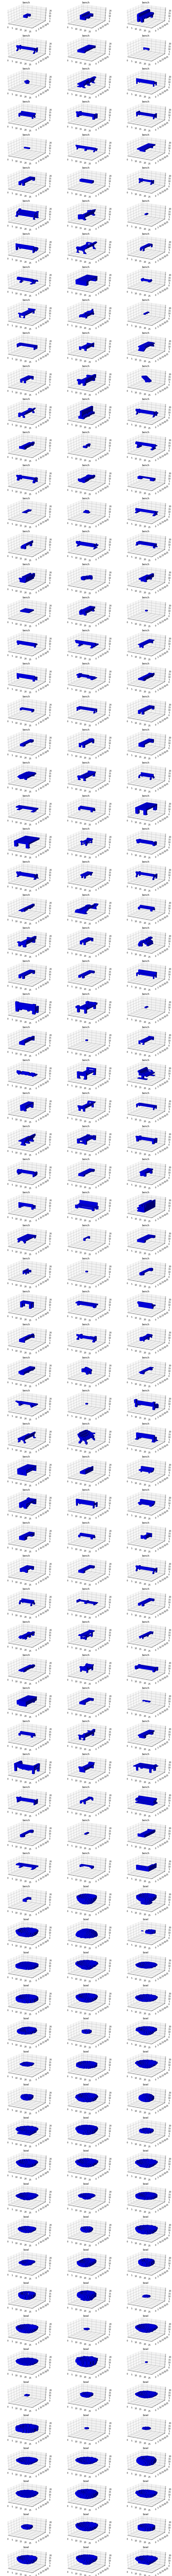

In [12]:
per_row = 3
num_figs = len(training)
cols = num_figs // per_row
fig, ax= plt.subplots(cols, per_row, subplot_kw={'projection': '3d'}, figsize=[15, 3 * cols])    

for i in range(0,num_figs):
    cube1 = (training[i][:,:,:] >= 1)
    ax[i//per_row, i%per_row].voxels(cube1, facecolors="blue")
    ax[i//per_row, i%per_row].set_title(base_labels[training_labels[i]])

plt.show()